In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import statistics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import math
import glob
from itertools import combinations
from matplotlib import pyplot as plt
from Bio import Phylo
import biotite
from pca_plot import *
from vst_function import *

In [2]:
## Read and merge files 
anotation = pd.read_csv('../data/SGDP_anotation.csv', sep=',', encoding='latin-1')

ids_hg19 = pd.DataFrame()
ids_hg19['SAMPLE'] = anotation['3-Illumina_ID']
ids_hg19['REGION'] = anotation['10-Region']


In [3]:
def read_file(file):
    """
    Read a file to a dict of lists.

    :param str file: Path to a sample file.
    :return: dict of lists of records
    :rtype: dict
    """
    vcf_dict = []
    #df = pd.DataFrame()
    with open(file, 'r') as invcf:
        for line in invcf:
            if line.startswith('track'):
                continue
                
    
    
            line = line.strip().split()
            CHR = line[0]
            START = line[1]
            END = line[2]
            SCORE = line[3]
            name = str(file.split('/')[-1]) 
            
            if SCORE == '2':
                continue
            
            vcf_dict.append([name, CHR, START,END, SCORE])
            
            
    return vcf_dict



def read_multiple_files(path_of_files):
    """
    Read the path of vcf files to a dataframe.
    :param str file: Path to a files.
    :return: dict of lists of  records
    :rtype: dict
    """
    files = glob.glob(path_of_files+'*')
    chm13list = []
    for file in files:
        #return pd.DataFrame(read_vcf(file))
        chm13list.append(read_file(file))
    
    return (chm13list)


df = read_multiple_files('../data/CHM13_SGDP/')

Output = []
  
# Using iteration
for temp in df:
    for elem in temp:
        Output.append(elem)

chm13 = pd.DataFrame(Output)

chm13.columns = ['SAMPLE', 'CHR', 'START', 'END', 'SCORE']
chm13['START'] = chm13['START'].astype(int)
chm13['END'] = chm13['END'].astype(int)
chm13['SCORE'] = chm13['SCORE'].astype(int)


## Keeping only samples that are on old cnvs 
chm13 = chm13.merge(ids_hg19, on=['SAMPLE'])

chm13


SAMPLE         CHR     START       END  SCORE  \
0         LP6005441-DNA_G12  CP068254.1         0      1000    661   
1         LP6005441-DNA_G12  CP068254.1      1000      2228    687   
2         LP6005441-DNA_G12  CP068254.1      2228      3378    647   
3         LP6005441-DNA_G12  CP068254.1      3378      4522    658   
4         LP6005441-DNA_G12  CP068254.1      4522      5522    704   
...                     ...         ...       ...       ...    ...   
35659700  LP6005442-DNA_D01  CP086569.2  62447554  62448825     20   
35659701  LP6005442-DNA_D01  CP086569.2  62448825  62449825     21   
35659702  LP6005442-DNA_D01  CP086569.2  62449825  62450825     22   
35659703  LP6005442-DNA_D01  CP086569.2  62450825  62451825     23   
35659704  LP6005442-DNA_D01  CP086569.2  62451825  62460029     25   

               REGION  
0         WestEurasia  
1         WestEurasia  
2         WestEurasia  
3         WestEurasia  
4         WestEurasia  
...               ...  
35659700     EastAsia  
35659701     EastAsia  
35659702     EastAsia  
35659703     EastAsia  
35659704     EastAsia  

[35659705 rows x 6 columns]

In [6]:
## ADDING DUPLICATION/DELETION COLUMN 

deletions = chm13[chm13['SCORE'] < 2 ] 
deletions['TYPE'] = 'DELETION'
duplications= chm13[chm13['SCORE'] > 2] 
duplications['TYPE'] = 'DUPLICATION'

frames = [deletions,duplications]

chm13 = pd.concat(frames)
chm13

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


SAMPLE         CHR     START       END  SCORE    REGION  \
16        LP6005441-DNA_B02  CP068255.2     79662     98643      1    Africa   
17        LP6005441-DNA_B02  CP068255.2    105118    116978      1    Africa   
18        LP6005441-DNA_B02  CP068255.2    142723    147744      1    Africa   
19        LP6005441-DNA_B02  CP068255.2    147744    149510      1    Africa   
21        LP6005441-DNA_B02  CP068255.2    158982    162403      1    Africa   
...                     ...         ...       ...       ...    ...       ...   
35659700  LP6005442-DNA_H01  CP086569.2  62447554  62448825     20  EastAsia   
35659701  LP6005442-DNA_H01  CP086569.2  62448825  62449825     22  EastAsia   
35659702  LP6005442-DNA_H01  CP086569.2  62449825  62450825     24  EastAsia   
35659703  LP6005442-DNA_H01  CP086569.2  62450825  62451825     22  EastAsia   
35659704  LP6005442-DNA_H01  CP086569.2  62451825  62460029     25  EastAsia   

          LENGHT         TYPE  
16         18981     DELETION  
17         11860     DELETION  
18          5021     DELETION  
19          1766     DELETION  
21          3421     DELETION  
...          ...          ...  
35659700    1271  DUPLICATION  
35659701    1000  DUPLICATION  
35659702    1000  DUPLICATION  
35659703    1000  DUPLICATION  
35659704    8204  DUPLICATION  

[35659705 rows x 8 columns]

In [7]:
### Getting gene anotation to filtering 
header_list = ['CHR','START', 'END', 'NAME', 'SCORE', 'STRAND', 'END-2', 'END-3', 'TYPE_CODE','BLOCKS', 'LENGTH', 'NORELATIVE'] 
gene_anotation = pd.read_table('/branchinecta/jbazanwilliamson/gene_anotation_chm13', names = header_list)
#gene_anotation = gene_anotation[gene_anotation['TYPE']=='76,85,212'] # only selecting protein-coding genes

feature_table = pd.read_table('/branchinecta/jbazanwilliamson/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chr

report = pd.read_table('/branchinecta/jbazanwilliamson/GCF_009914755.1_T2T-CHM13v2.0_assembly_report.txt')

chm13_gene_anotation = feature_table.merge(report, left_on='genomic_accession', right_on='RefSeq-Accn')
chm13_gene_anotation[chm13_gene_anotation['class'] == 'protein_coding']
gene_anotation = pd.DataFrame()
gene_anotation['CHR'] = chm13_gene_anotation['GenBank-Accn']
gene_anotation['START'] = chm13_gene_anotation['start']
gene_anotation['END'] = chm13_gene_anotation['end']
gene_anotation['CHR_2'] = chm13_gene_anotation['chromosome'] 





/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [8]:
#chm13 = pd.read_csv('../data/chm13_gene_regions.csv', index_col=0)
chm13['LENGHT'] = chm13['END'] - chm13['START']
chm13['TYPE'].value_counts()

DUPLICATION    24637132
DELETION       11022573
Name: TYPE, dtype: int64

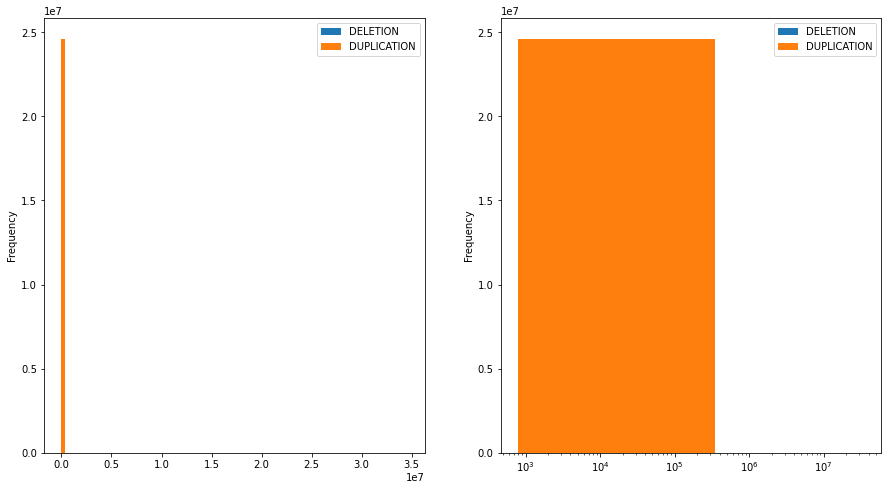

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

df_plot= chm13.groupby(['TYPE'])['LENGHT']

df_plot.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[0]) # alpha for transparency

plt.xscale('log')
#plt.show()

df_plot = chm13.groupby(['TYPE'])['LENGHT']

df_plot.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[1]) # alpha for transparency

plt.show()

In [11]:
#subsetting deletions and duplications
deletions = chm13[chm13['TYPE'] =='DELETION']
duplications = chm13[chm13['TYPE'] == 'DUPLICATION']

In [12]:
#change to df when using telomeres and centromeres filtration
final_cnv = deletions.pivot_table(index=["CHR", "START", "END"], 
                    columns='SAMPLE', 
                    values='SCORE').reset_index()


final_cnv

SAMPLE         CHR     START       END  LP6005441-DNA_A01  LP6005441-DNA_A03  \
0       CP068254.1     14661     15778                NaN                NaN   
1       CP068255.2         0      3514                NaN                0.0   
2       CP068255.2      3514      8916                NaN                NaN   
3       CP068255.2      8916     12222                NaN                NaN   
4       CP068255.2     12222     70111                1.0                NaN   
...            ...       ...       ...                ...                ...   
623957  CP086569.2  62380980  62392131                NaN                NaN   
623958  CP086569.2  62392131  62403013                NaN                NaN   
623959  CP086569.2  62411230  62422895                NaN                NaN   
623960  CP086569.2  62422895  62423895                NaN                NaN   
623961  CP086569.2  62423895  62425307                NaN                NaN   

SAMPLE  LP6005441-DNA_A04  LP6005441-DNA_A05  LP6005441-DNA_A06  \
0                     NaN                NaN                NaN   
1                     NaN                NaN                NaN   
2                     NaN                NaN                NaN   
3                     NaN                NaN                NaN   
4                     1.0                NaN                1.0   
...                   ...                ...                ...   
623957                NaN                NaN                NaN   
623958                NaN                NaN                NaN   
623959                NaN                NaN                NaN   
623960                NaN                NaN                NaN   
623961                NaN                NaN                NaN   

SAMPLE  LP6005441-DNA_A08  LP6005441-DNA_A09  ...  LP6005677-DNA_D03  \
0                     NaN                NaN  ...                NaN   
1                     NaN                NaN  ...                NaN   
2                     NaN                NaN  ...                NaN   
3                     NaN                NaN  ...                NaN   
4                     NaN                NaN  ...                NaN   
...                   ...                ...  ...                ...   
623957                NaN                1.0  ...                NaN   
623958                NaN                1.0  ...                NaN   
623959                NaN                1.0  ...                NaN   
623960                NaN                1.0  ...                NaN   
623961                NaN                1.0  ...                NaN   

SAMPLE  LP6005677-DNA_E01  LP6005677-DNA_F01  LP6005677-DNA_G01  \
0                     NaN                NaN                NaN   
1                     NaN                NaN                NaN   
2                     NaN                NaN                NaN   
3                     NaN                NaN                NaN   
4                     1.0                NaN                NaN   
...                   ...                ...                ...   
623957                NaN                NaN                NaN   
623958                NaN                NaN                NaN   
623959                NaN                NaN                NaN   
623960                NaN                NaN                NaN   
623961                NaN                NaN                NaN   

SAMPLE  LP6007068-DNA_A01  LP6007069-DNA_A01  SS6004471  SS6004477  SS6004478  \
0                     NaN                NaN        NaN        NaN        NaN   
1                     NaN                NaN        NaN        NaN        NaN   
2                     1.0                NaN        NaN        NaN        1.0   
3                     NaN                NaN        NaN        NaN        NaN   
4                     1.0                NaN        NaN        NaN        1.0   
...                   ...                ...        ...        ...        ... 

In [13]:
from scipy import stats
#final_cnv = final_cnv.iloc[new]
final = final_cnv.iloc[:,3:284]
counts = final
counts = counts.fillna(2)

#counts = counts[counts.columns.intersection(counts_a.columns)]

#counts = counts.drop(columns=['LP6005592-DNA_G03',
#                     'LP6005443-DNA_E10',
#                     'LP6005442-DNA_E04'])

counts = counts.T
counts = counts.sort_index()
counts

0       1       2       3       4       5       6       \
SAMPLE                                                                      
LP6005441-DNA_A01     2.0     2.0     2.0     2.0     1.0     1.0     1.0   
LP6005441-DNA_A03     2.0     0.0     2.0     2.0     2.0     2.0     2.0   
LP6005441-DNA_A04     2.0     2.0     2.0     2.0     1.0     2.0     2.0   
LP6005441-DNA_A05     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
LP6005441-DNA_A06     2.0     2.0     2.0     2.0     1.0     2.0     2.0   
...                   ...     ...     ...     ...     ...     ...     ...   
LP6007069-DNA_A01     2.0     2.0     2.0     2.0     2.0     2.0     1.0   
SS6004471             2.0     2.0     2.0     2.0     2.0     2.0     2.0   
SS6004477             2.0     2.0     2.0     2.0     2.0     2.0     1.0   
SS6004478             2.0     2.0     1.0     2.0     1.0     2.0     1.0   
SS6004480             2.0     1.0     2.0     2.0     1.0     2.0     1.0   

                   7       8       9       ...  623952  623953  623954  \
SAMPLE                                     ...                           
LP6005441-DNA_A01     1.0     1.0     2.0  ...     2.0     2.0     2.0   
LP6005441-DNA_A03     2.0     1.0     2.0  ...     2.0     2.0     2.0   
LP6005441-DNA_A04     2.0     1.0     2.0  ...     2.0     2.0     2.0   
LP6005441-DNA_A05     2.0     1.0     2.0  ...     2.0     2.0     2.0   
LP6005441-DNA_A06     2.0     1.0     2.0  ...     2.0     2.0     2.0   
...                   ...     ...     ...  ...     ...     ...     ...   
LP6007069-DNA_A01     2.0     1.0     2.0  ...     2.0     2.0     2.0   
SS6004471             2.0     1.0     2.0  ...     2.0     2.0     2.0   
SS6004477             2.0     1.0     2.0  ...     2.0     2.0     2.0   
SS6004478             2.0     1.0     2.0  ...     2.0     2.0     2.0   
SS6004480             2.0     1.0     2.0  ...     2.0     2.0     2.0   

                   623955  623956  623957  623958  623959  623960  623961  
SAMPLE                                                                     
LP6005441-DNA_A01     2.0     2.0     2.0     2.0     2.0     2.0     2.0  
LP6005441-DNA_A03     2.0     2.0     2.0     2.0     2.0     2.0     2.0  
LP6005441-DNA_A04     2.0     2.0     2.0     2.0     2.0     2.0     2.0  
LP6005441-DNA_A05     2.0     2.0     2.0     2.0     2.0     2.0     2.0  
LP6005441-DNA_A06     2.0     2.0     2.0     2.0     2.0     2.0     2.0  
...                   ...     ...     ...     ...     ...     ...     ...  
LP6007069-DNA_A01     2.0     2.0     2.0     2.0     2.0     2.0     2.0  
SS6004471             2.0     2.0     2.0     2.0     2.0     2.0     2.0  
SS6004477             2.0     2.0     2.0     2.0     2.0     2.0     2.0  
SS6004478             2.0     2.0     2.0     2.0     2.0     2.0     2.0  
SS6004480             2.0     2.0     2.0     2.0     2.0     2.0     2.0  

[269 rows x 623962 columns]

In [26]:
features = ids_hg19.set_index('SAMPLE').merge(counts, left_index=True, right_index=True)
features = features.loc[:,['REGION']]
features = features.sort_index()
features 

REGION
SAMPLE                        
LP6005441-DNA_A01  WestEurasia
LP6005441-DNA_A03      Oceania
LP6005441-DNA_A04      America
LP6005441-DNA_A05  WestEurasia
LP6005441-DNA_A06  WestEurasia
...                        ...
LP6007069-DNA_A01  WestEurasia
SS6004471               Africa
SS6004477              Oceania
SS6004478              Oceania
SS6004480               Africa

[269 rows x 1 columns]

In [15]:
#PCA
pca = PCA(n_components=10)
pca_results = pca.fit_transform(counts)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3', 'component_4',
                                  'component_5',
                                  'component_6',
                                  'component_7',
                                  'component_8',
                                  'component_9',
                                   'component_10'
                                  ],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
df_pca

REGION  component_1  component_2  component_3  \
SAMPLE                                                                  
LP6005441-DNA_A01  WestEurasia   -90.701167    -7.008768    -3.038642   
LP6005441-DNA_A03      Oceania   148.826941     0.006565    -1.831490   
LP6005441-DNA_A04      America   148.443956     0.579923    -2.780700   
LP6005441-DNA_A05  WestEurasia   -90.746500    -7.345963    -3.852065   
LP6005441-DNA_A06  WestEurasia   -90.818197    -7.535282    -3.897274   
...                        ...          ...          ...          ...   
LP6007069-DNA_A01  WestEurasia   141.356220     3.688741     9.941928   
SS6004471               Africa   -91.545456     4.311335     8.745933   
SS6004477              Oceania   -91.184387    -2.078388     7.286714   
SS6004478              Oceania   144.789671     4.153975    10.573162   
SS6004480               Africa   -91.315627    -3.690158     5.482391   

                   component_4  component_5  component_6  component_7  \
SAMPLE                                                                  
LP6005441-DNA_A01    -6.780870    -2.894285     1.399671    -6.194300   
LP6005441-DNA_A03    -4.689363    -1.214211    -0.488604    -1.947200   
LP6005441-DNA_A04    -5.533423    -0.620130     2.990475    -7.940150   
LP6005441-DNA_A05    -7.110198    -2.053986     3.181465    -7.735741   
LP6005441-DNA_A06    -8.446110    -2.613702     4.179289   -11.949606   
...                        ...          ...          ...          ...   
LP6007069-DNA_A01   129.373242    30.432180     8.988445     0.791181   
SS6004471           125.532728    27.177847    17.469614   -31.364584   
SS6004477            95.785669    18.694732     6.017290    -9.811765   
SS6004478           131.455871    30.577078    12.742636   -14.763207   
SS6004480           102.534656    22.342553    12.595001   -14.592020   

                   component_8  component_9  component_10  
SAMPLE                                                     
LP6005441-DNA_A01    -2.219931    -1.281536     -1.855942  
LP6005441-DNA_A03     8.531750    -2.933948     -6.894372  
LP6005441-DNA_A04    -0.166817    -0.870788     -1.205095  
LP6005441-DNA_A05    -7.117250     2.411815      2.604276  
LP6005441-DNA_A06    -4.482880     0.719855      1.252614  
...                        ...          ...           ...  
LP6007069-DNA_A01   -43.491039    -9.782792     -9.434271  
SS6004471            88.043073    53.062024     73.252287  
SS6004477            38.255992    -3.739838    -11.343702  
SS6004478           -14.974628   -20.911062    -34.057467  
SS6004480           -32.098143    -4.744486     -4.435761  

[269 rows x 11 columns]

In [16]:
pca.explained_variance_ratio_

array([0.57072833, 0.07170629, 0.0481527 , 0.01547214, 0.0135502 ,
       0.0094313 , 0.00894106, 0.00414389, 0.00337016, 0.00327604])

             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia   -90.701167    -7.008768    -3.038642    -6.780870    -2.894285   
Oceania       148.826941     0.006565    -1.831490    -4.689363    -1.214211   
America       148.443956     0.579923    -2.780700    -5.533423    -0.620130   
WestEurasia   -90.746500    -7.345963    -3.852065    -7.110198    -2.053986   
WestEurasia   -90.818197    -7.535282    -3.897274    -8.446110    -2.613702   
...                  ...          ...          ...          ...          ...   
WestEurasia   141.356220     3.688741     9.941928   129.373242    30.432180   
Africa        -91.545456     4.311335     8.745933   125.532728    27.177847   
Oceania       -91.184387    -2.078388     7.286714    95.785669    18.694732   
Oceania       144.789671     4.153975    10.573162   131.455871    30.577078   
Africa        -91.315627    -3.690158   

Count of groups by factor: 7
             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia   -90.701167    -7.008768    -3.038642    -6.780870    -2.894285   
Oceania       148.826941     0.006565    -1.831490    -4.689363    -1.214211   
America       148.443956     0.579923    -2.780700    -5.533423    -0.620130   
WestEurasia   -90.746500    -7.345963    -3.852065    -7.110198    -2.053986   
WestEurasia   -90.818197    -7.535282    -3.897274    -8.446110    -2.613702   
...                  ...          ...          ...          ...          ...   
WestEurasia   141.356220     3.688741     9.941928   129.373242    30.432180   
Africa        -91.545456     4.311335     8.745933   125.532728    27.177847   
Oceania       -91.184387    -2.078388     7.286714    95.785669    18.694732   
Oceania       144.789671     4.153975    10.573162   131.455871    30.577078   
Africa     

Count of groups by factor: 7
             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia   -90.701167    -7.008768    -3.038642    -6.780870    -2.894285   
Oceania       148.826941     0.006565    -1.831490    -4.689363    -1.214211   
America       148.443956     0.579923    -2.780700    -5.533423    -0.620130   
WestEurasia   -90.746500    -7.345963    -3.852065    -7.110198    -2.053986   
WestEurasia   -90.818197    -7.535282    -3.897274    -8.446110    -2.613702   
...                  ...          ...          ...          ...          ...   
WestEurasia   141.356220     3.688741     9.941928   129.373242    30.432180   
Africa        -91.545456     4.311335     8.745933   125.532728    27.177847   
Oceania       -91.184387    -2.078388     7.286714    95.785669    18.694732   
Oceania       144.789671     4.153975    10.573162   131.455871    30.577078   
Africa     

/branchinecta/jbazanwilliamson/cnv_analysis/cnv_sgdp/scripts/pca_plot.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  tight_layout=True


Count of groups by factor: 7
             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia   -90.701167    -7.008768    -3.038642    -6.780870    -2.894285   
Oceania       148.826941     0.006565    -1.831490    -4.689363    -1.214211   
America       148.443956     0.579923    -2.780700    -5.533423    -0.620130   
WestEurasia   -90.746500    -7.345963    -3.852065    -7.110198    -2.053986   
WestEurasia   -90.818197    -7.535282    -3.897274    -8.446110    -2.613702   
...                  ...          ...          ...          ...          ...   
WestEurasia   141.356220     3.688741     9.941928   129.373242    30.432180   
Africa        -91.545456     4.311335     8.745933   125.532728    27.177847   
Oceania       -91.184387    -2.078388     7.286714    95.785669    18.694732   
Oceania       144.789671     4.153975    10.573162   131.455871    30.577078   
Africa     

Count of groups by factor: 7
             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia   -90.701167    -7.008768    -3.038642    -6.780870    -2.894285   
Oceania       148.826941     0.006565    -1.831490    -4.689363    -1.214211   
America       148.443956     0.579923    -2.780700    -5.533423    -0.620130   
WestEurasia   -90.746500    -7.345963    -3.852065    -7.110198    -2.053986   
WestEurasia   -90.818197    -7.535282    -3.897274    -8.446110    -2.613702   
...                  ...          ...          ...          ...          ...   
WestEurasia   141.356220     3.688741     9.941928   129.373242    30.432180   
Africa        -91.545456     4.311335     8.745933   125.532728    27.177847   
Oceania       -91.184387    -2.078388     7.286714    95.785669    18.694732   
Oceania       144.789671     4.153975    10.573162   131.455871    30.577078   
Africa     

             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia   -90.701167    -7.008768    -3.038642    -6.780870    -2.894285   
Oceania       148.826941     0.006565    -1.831490    -4.689363    -1.214211   
America       148.443956     0.579923    -2.780700    -5.533423    -0.620130   
WestEurasia   -90.746500    -7.345963    -3.852065    -7.110198    -2.053986   
WestEurasia   -90.818197    -7.535282    -3.897274    -8.446110    -2.613702   
...                  ...          ...          ...          ...          ...   
WestEurasia   141.356220     3.688741     9.941928   129.373242    30.432180   
Africa        -91.545456     4.311335     8.745933   125.532728    27.177847   
Oceania       -91.184387    -2.078388     7.286714    95.785669    18.694732   
Oceania       144.789671     4.153975    10.573162   131.455871    30.577078   
Africa        -91.315627    -3.690158   

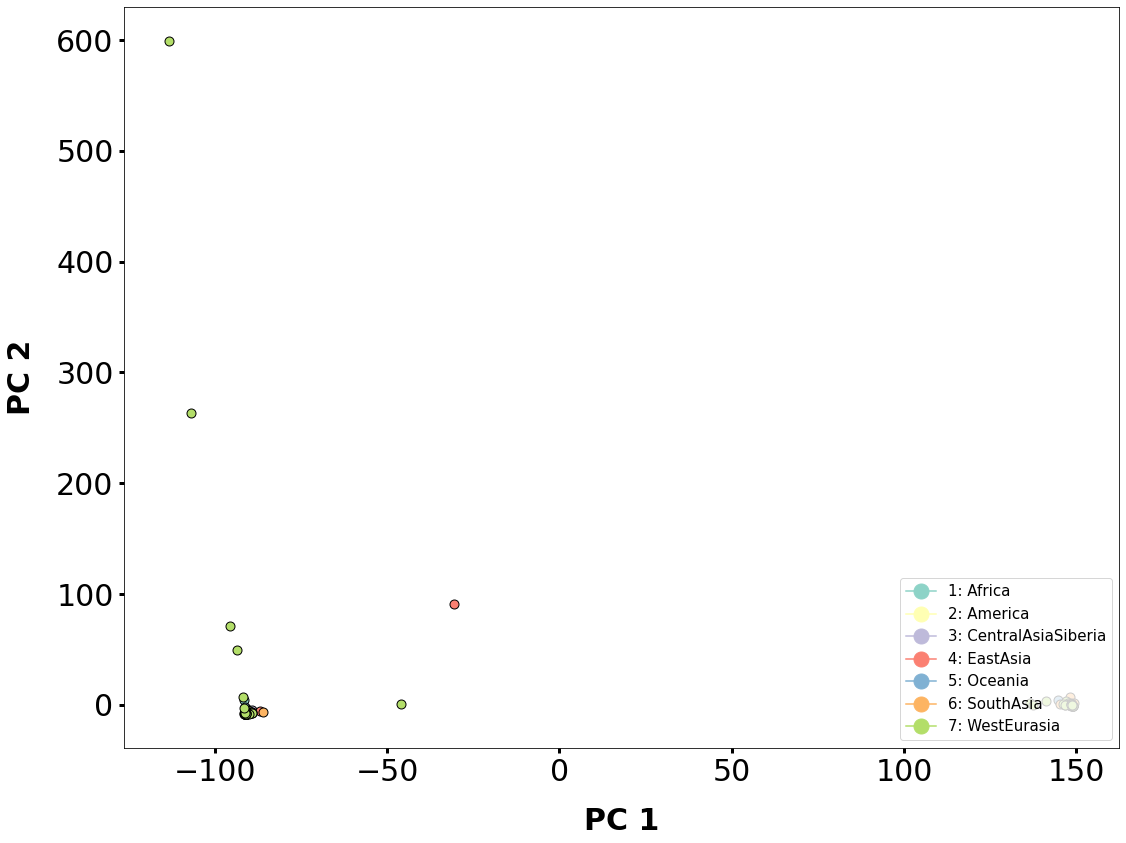

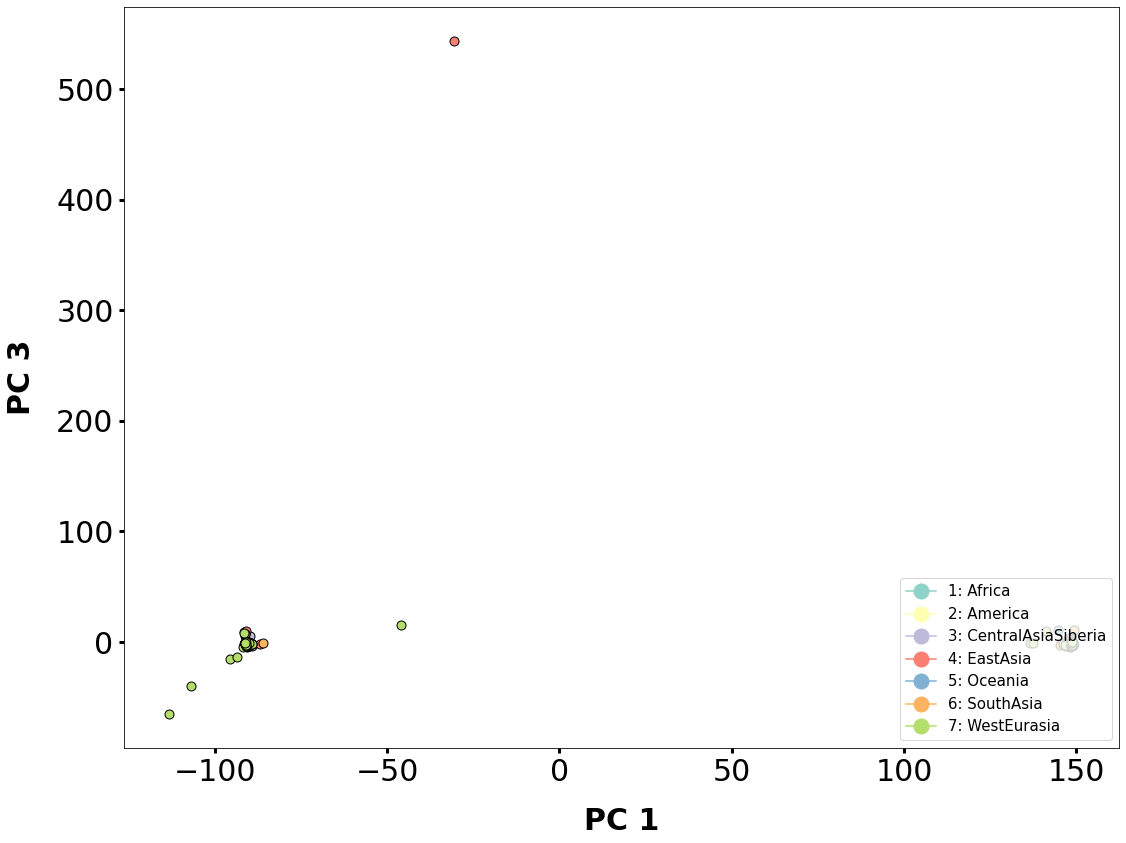

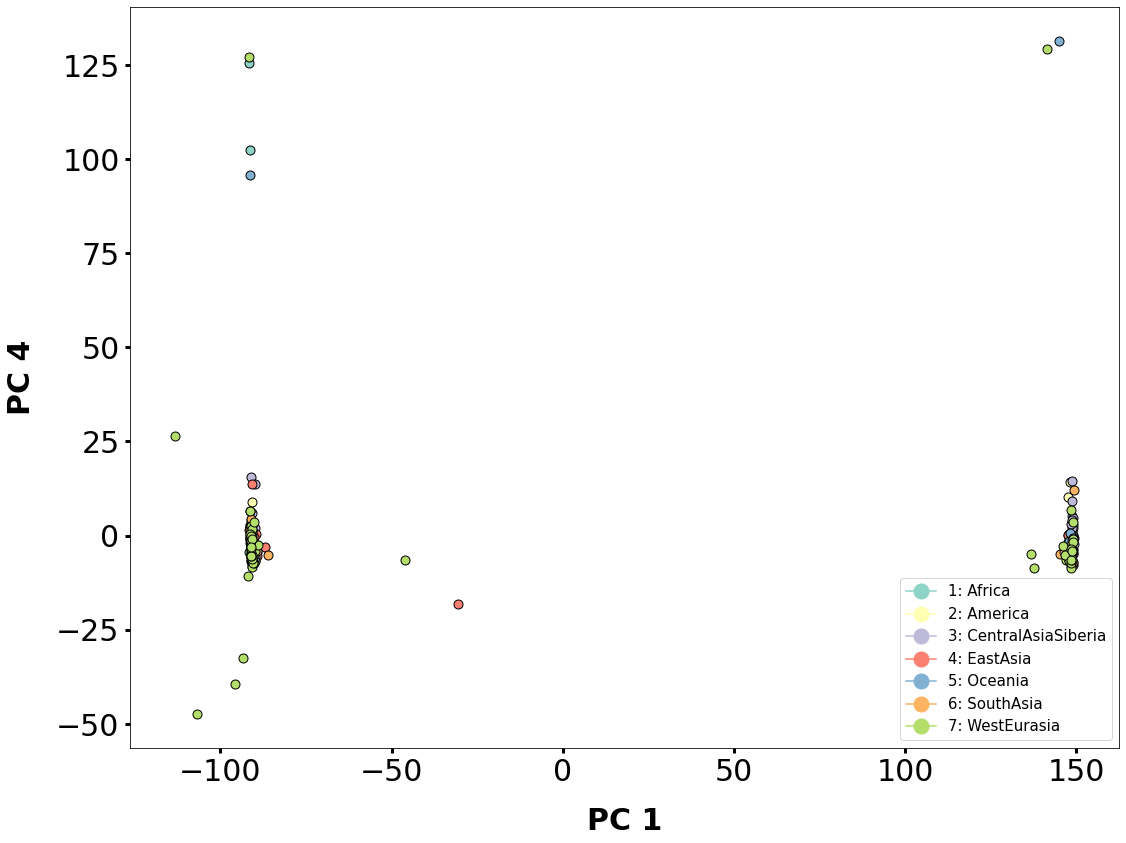

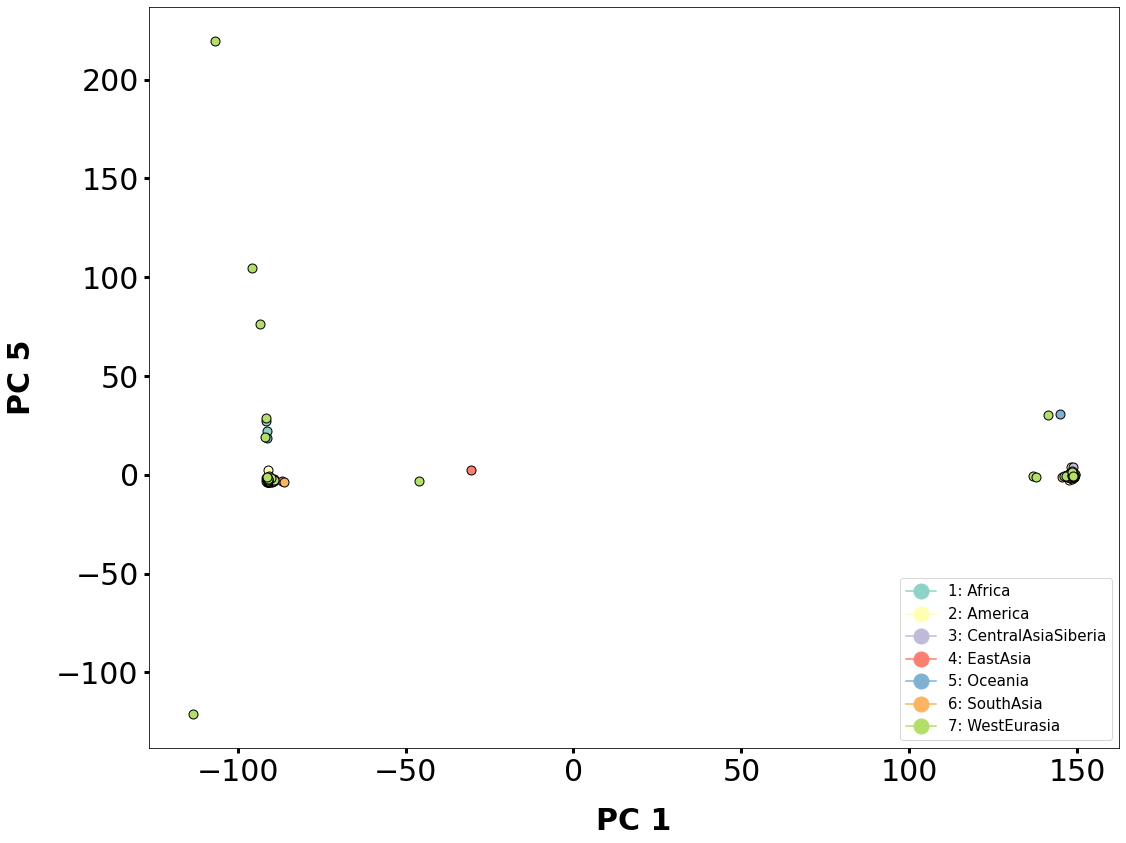

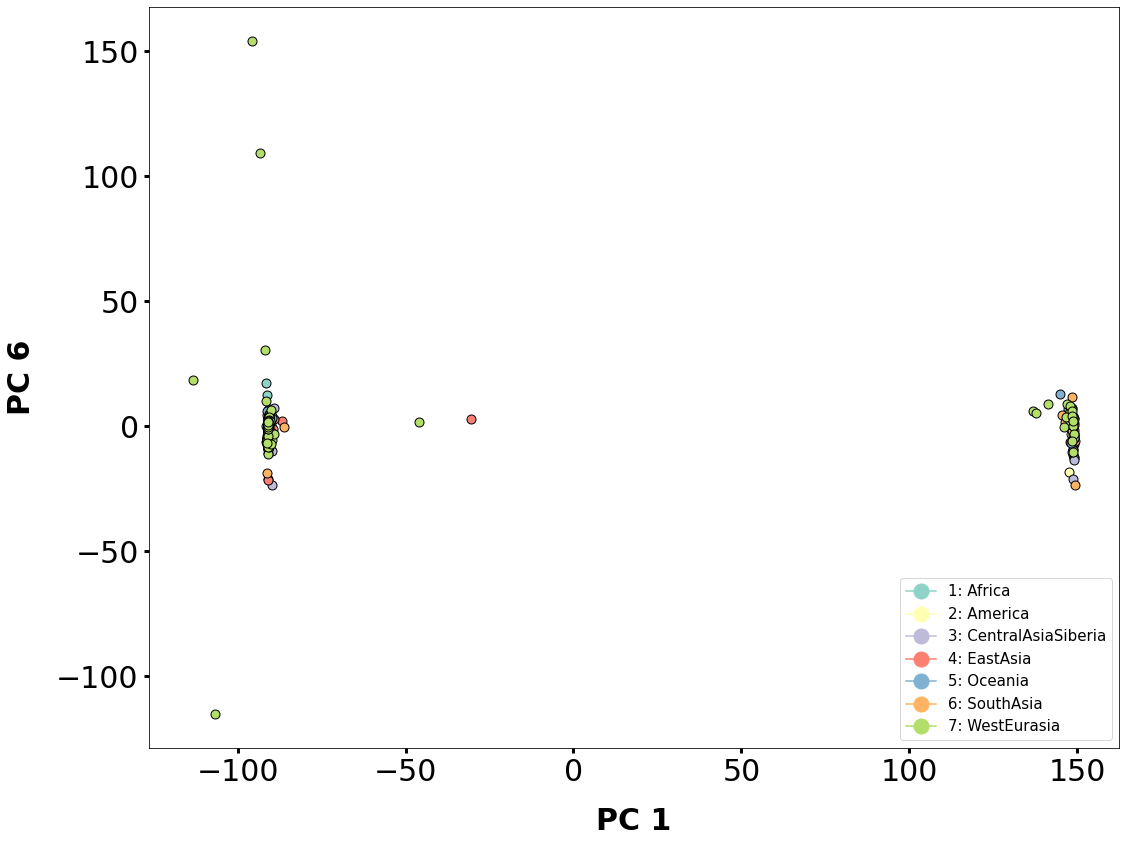

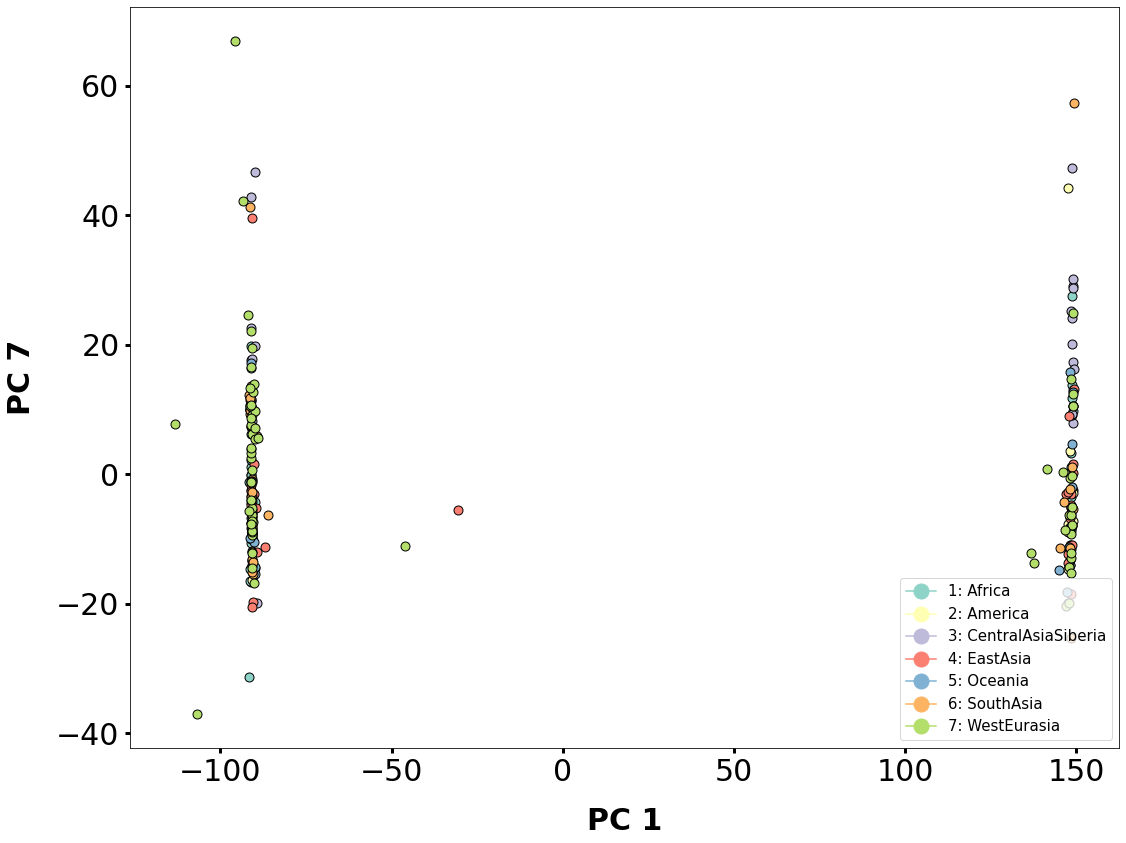

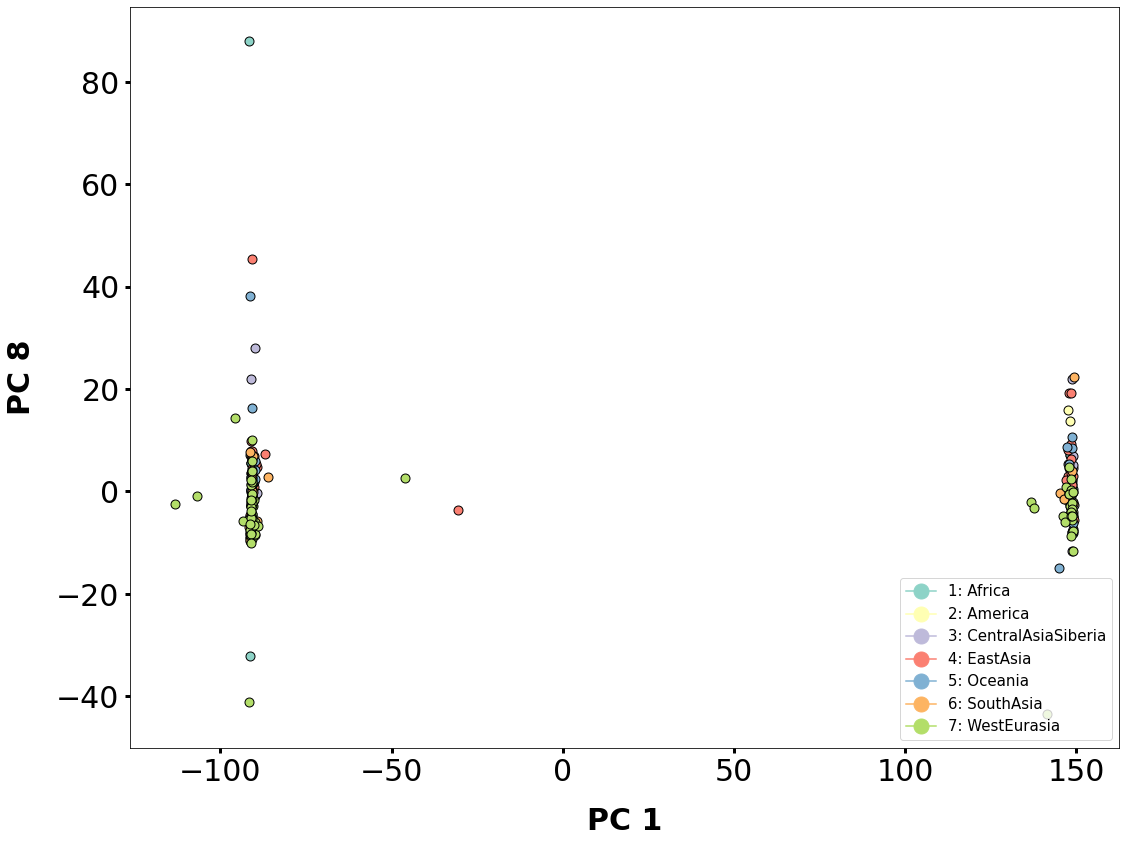

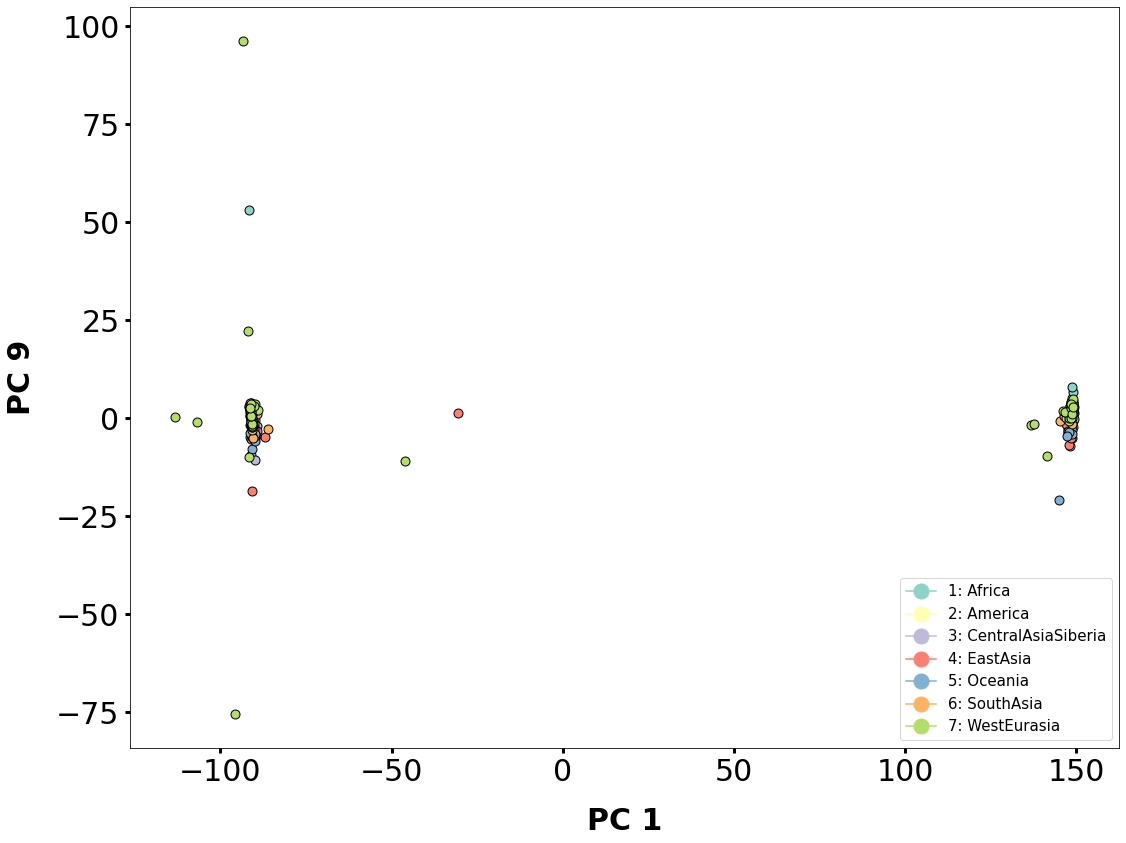

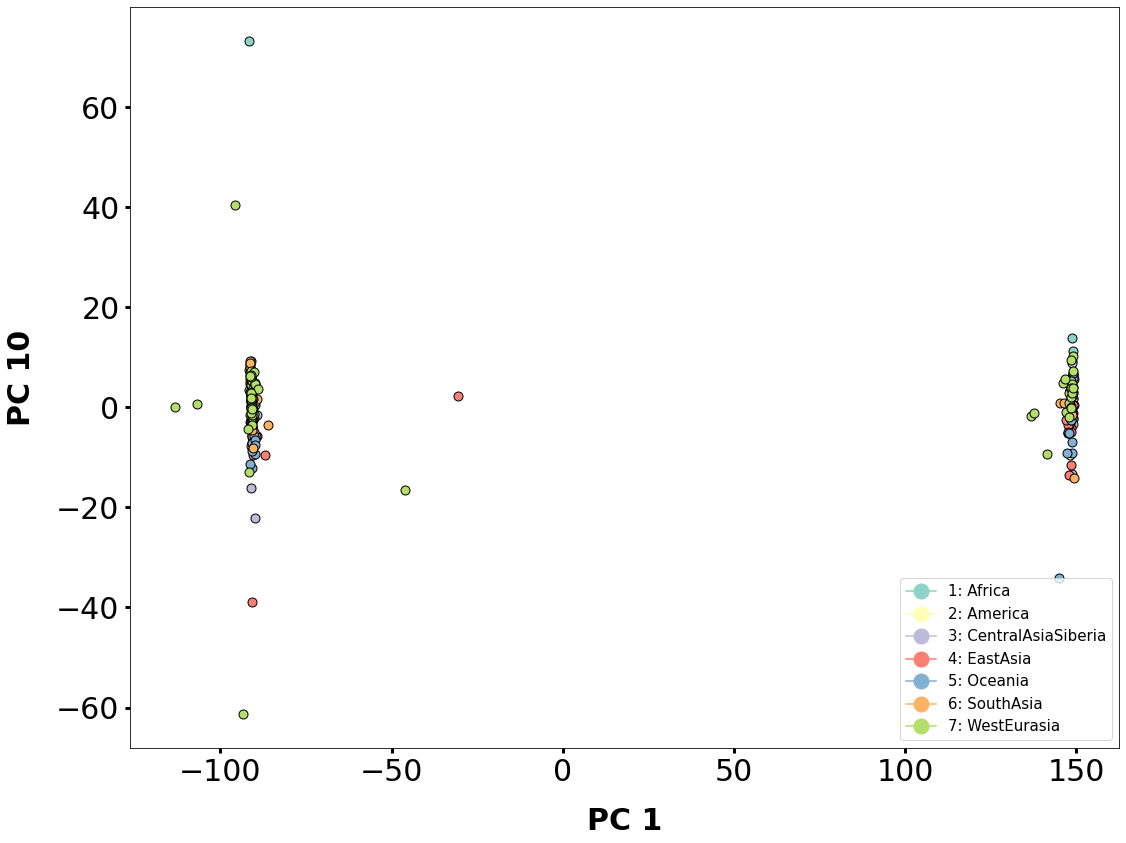

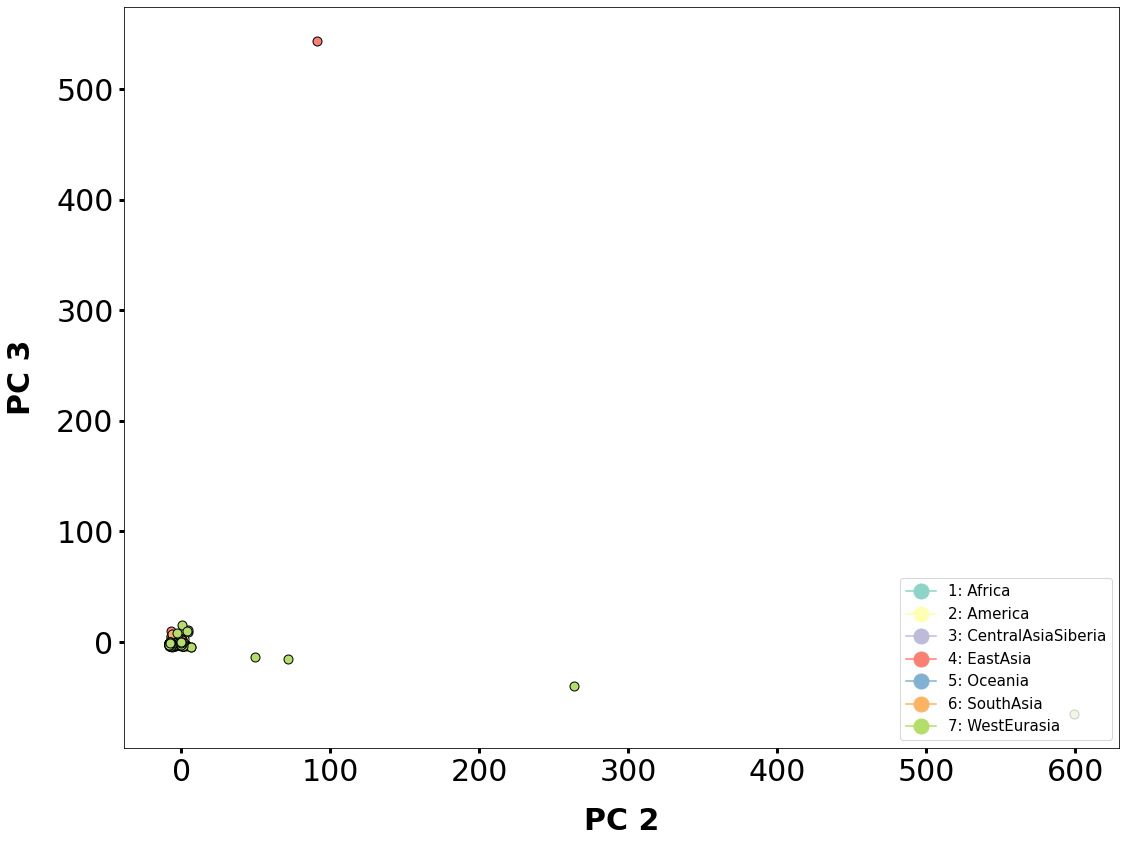

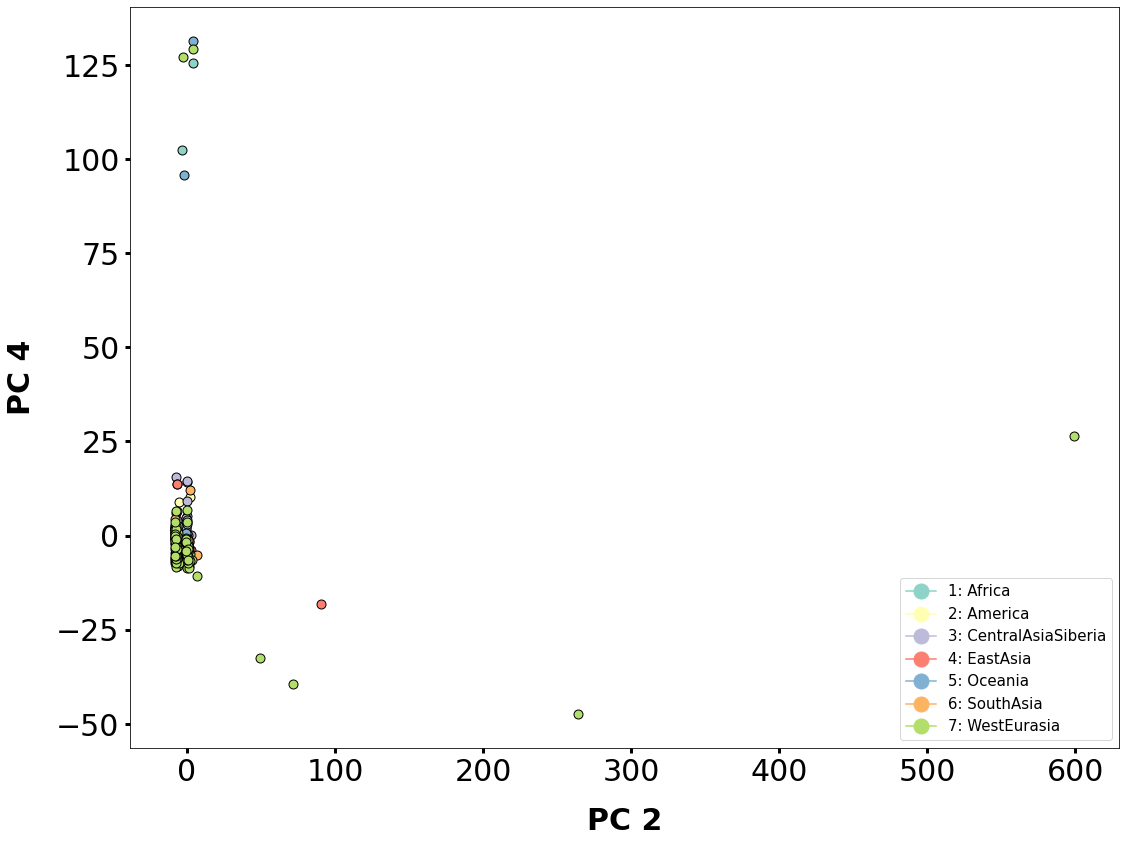

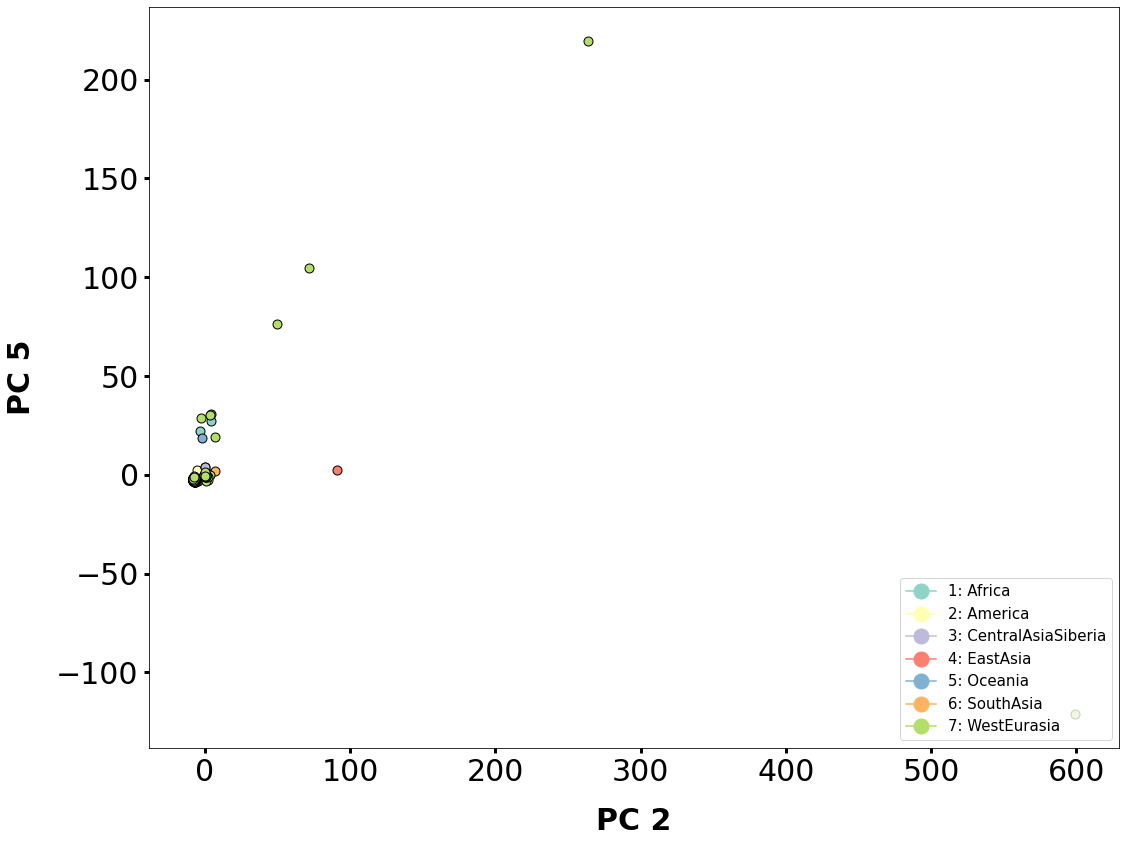

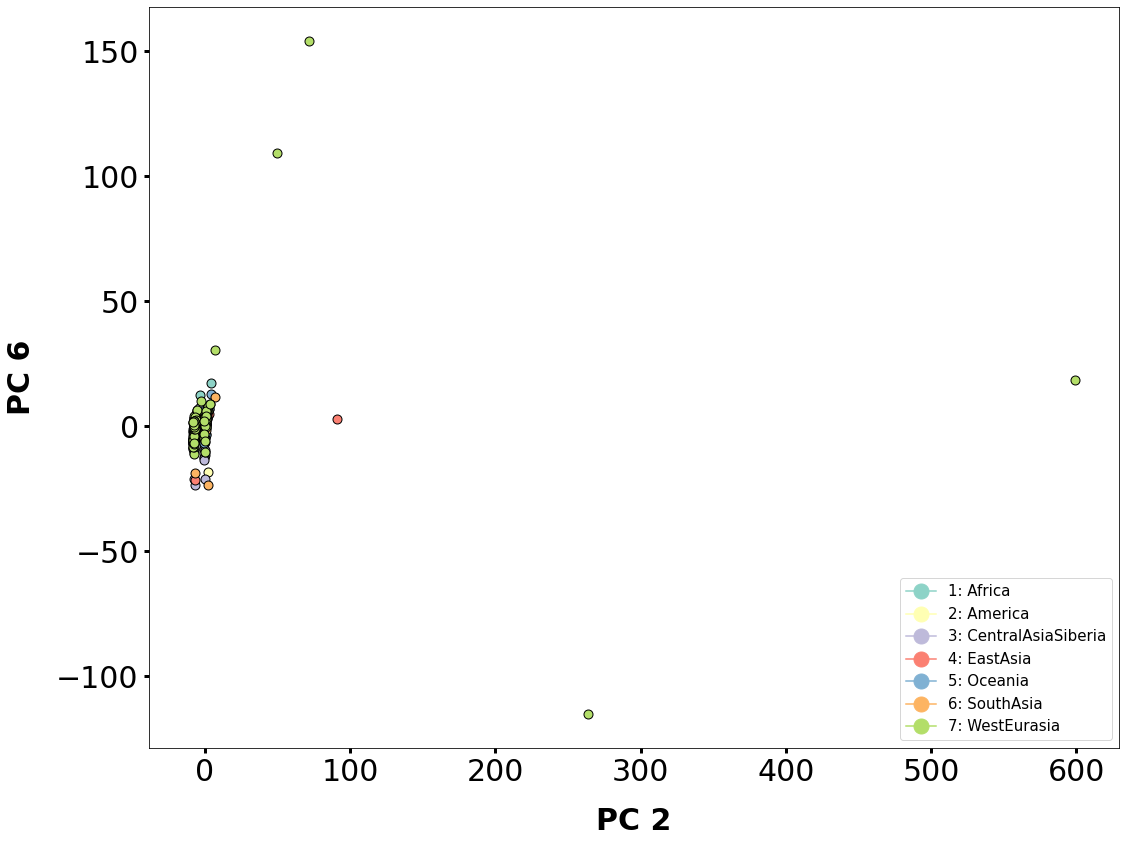

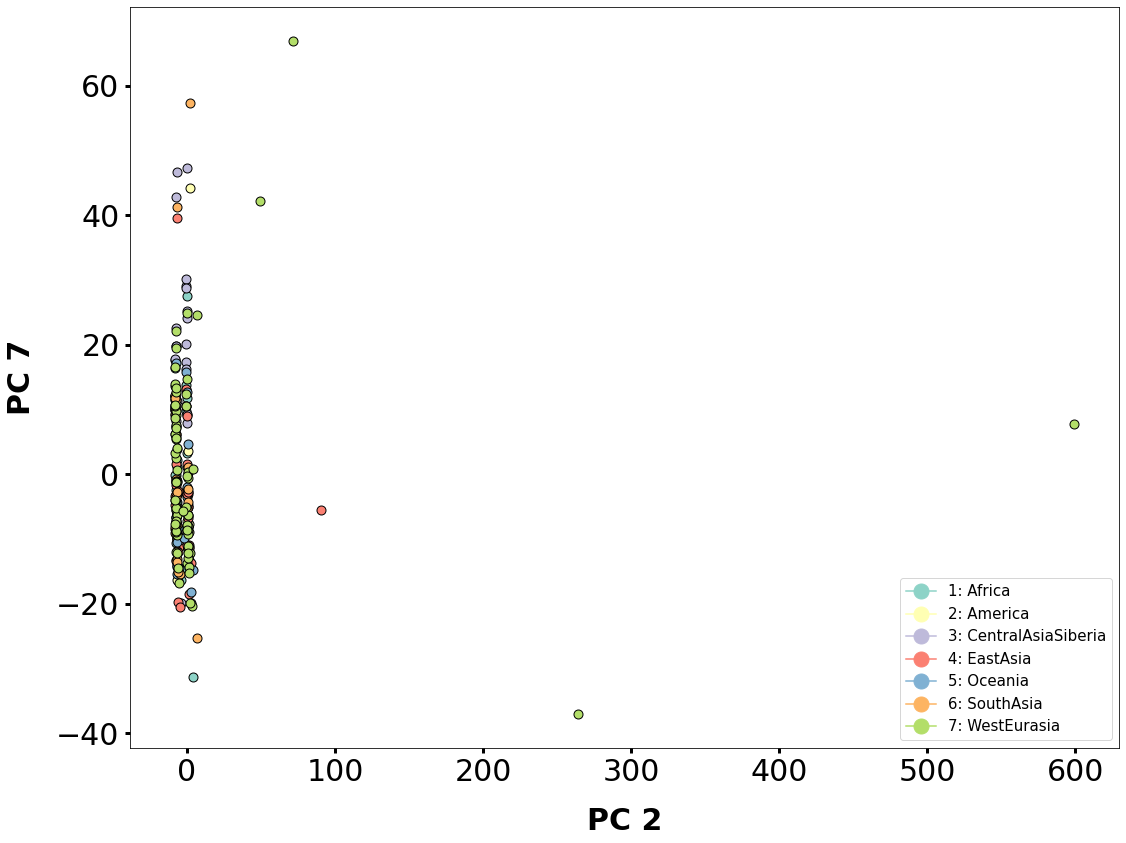

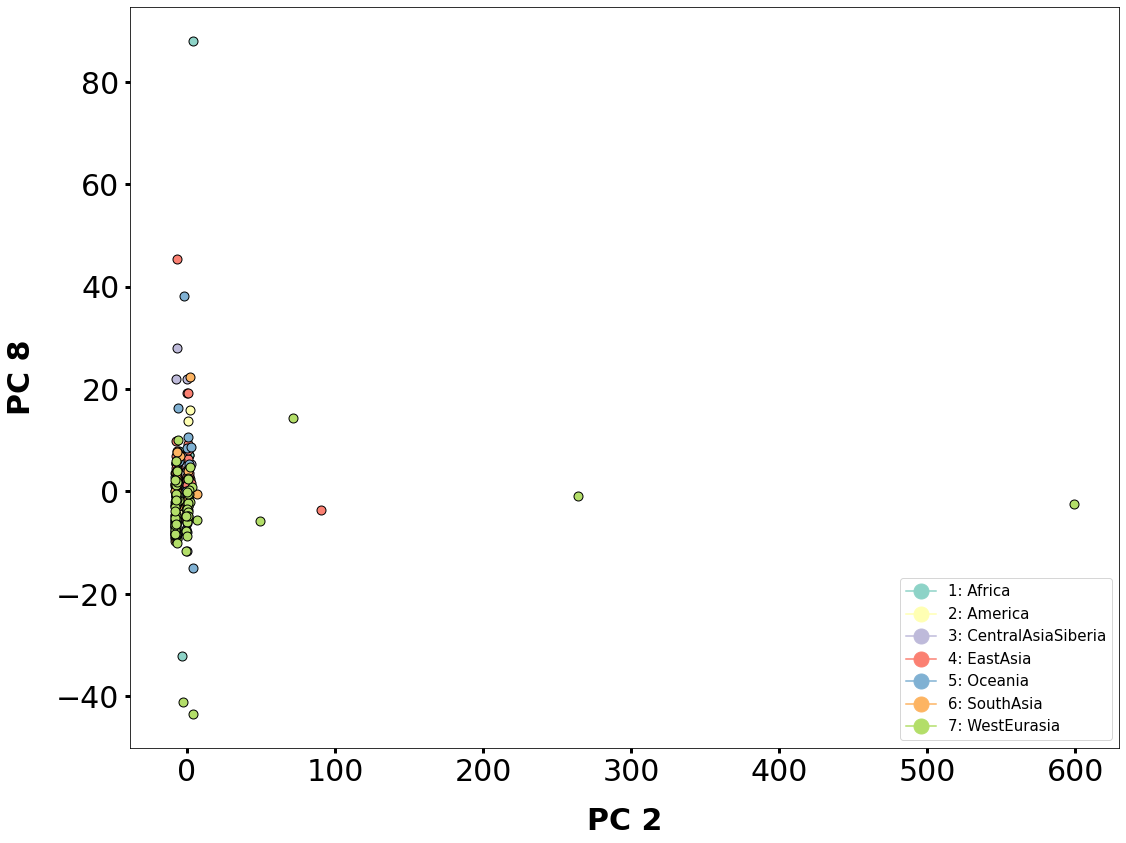

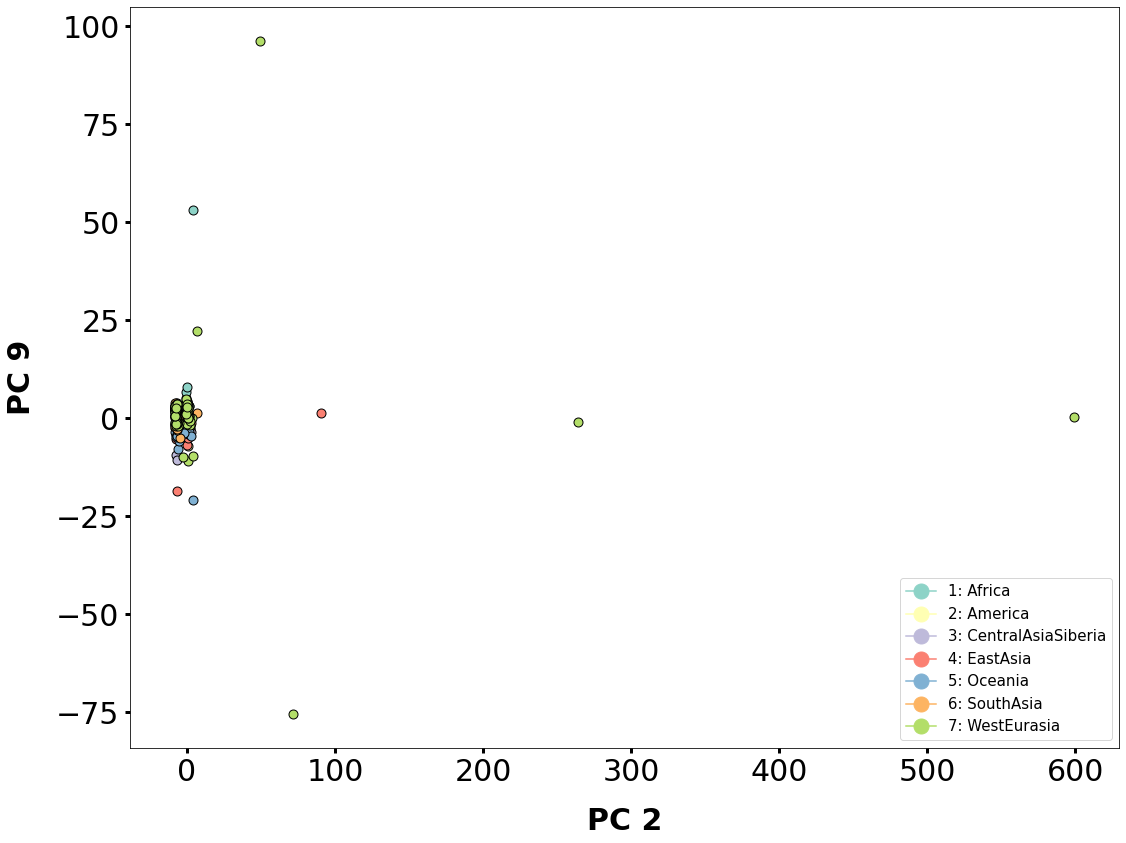

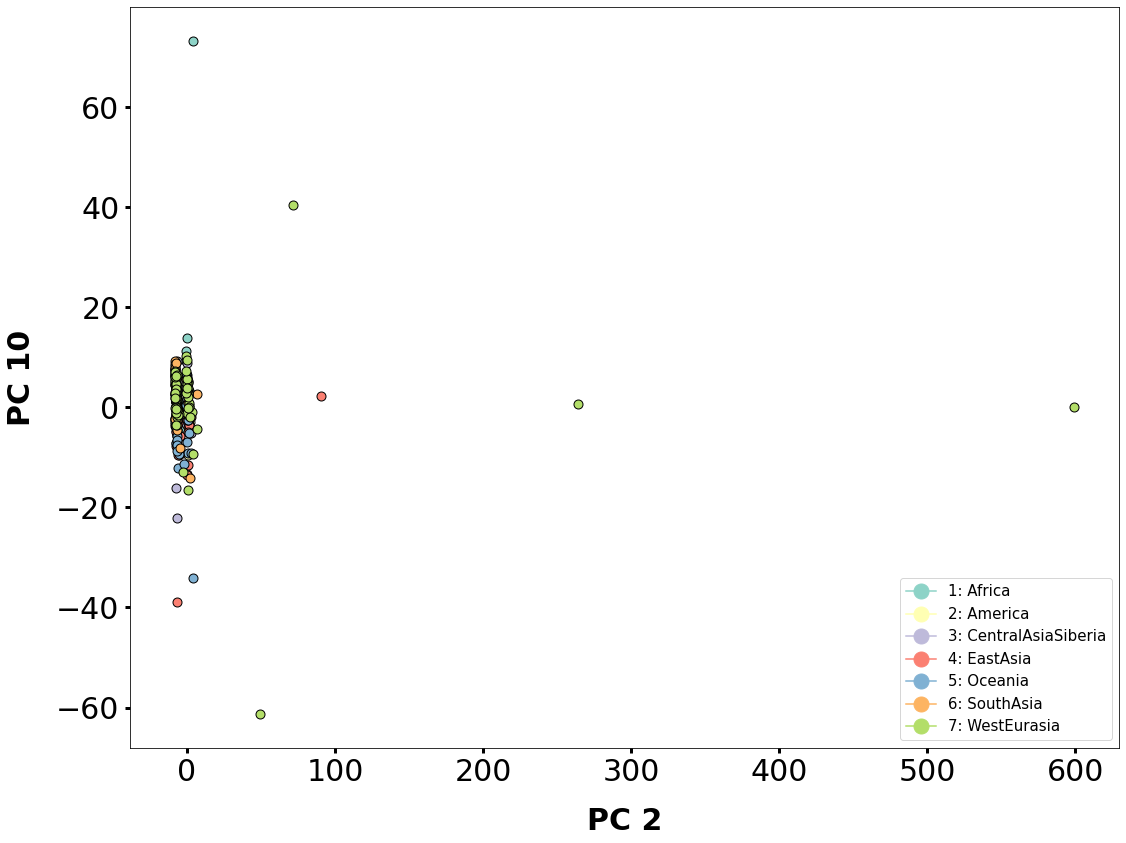

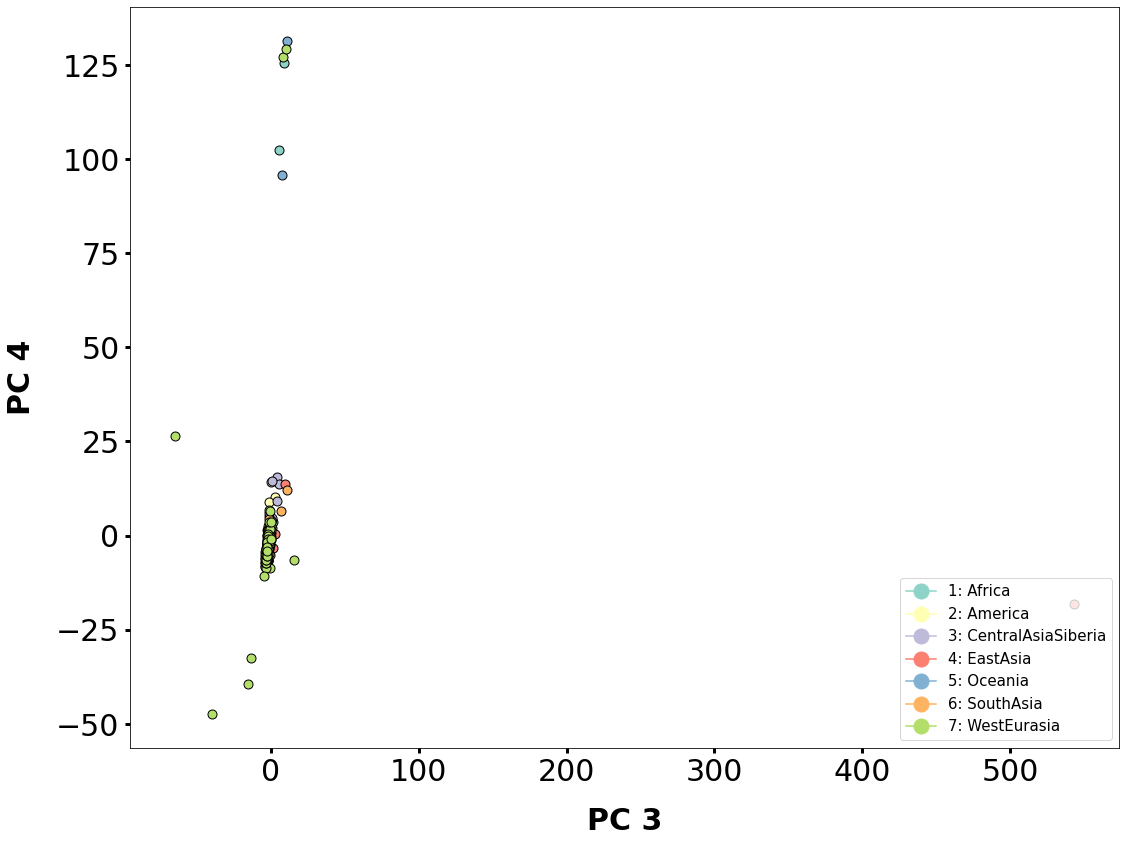

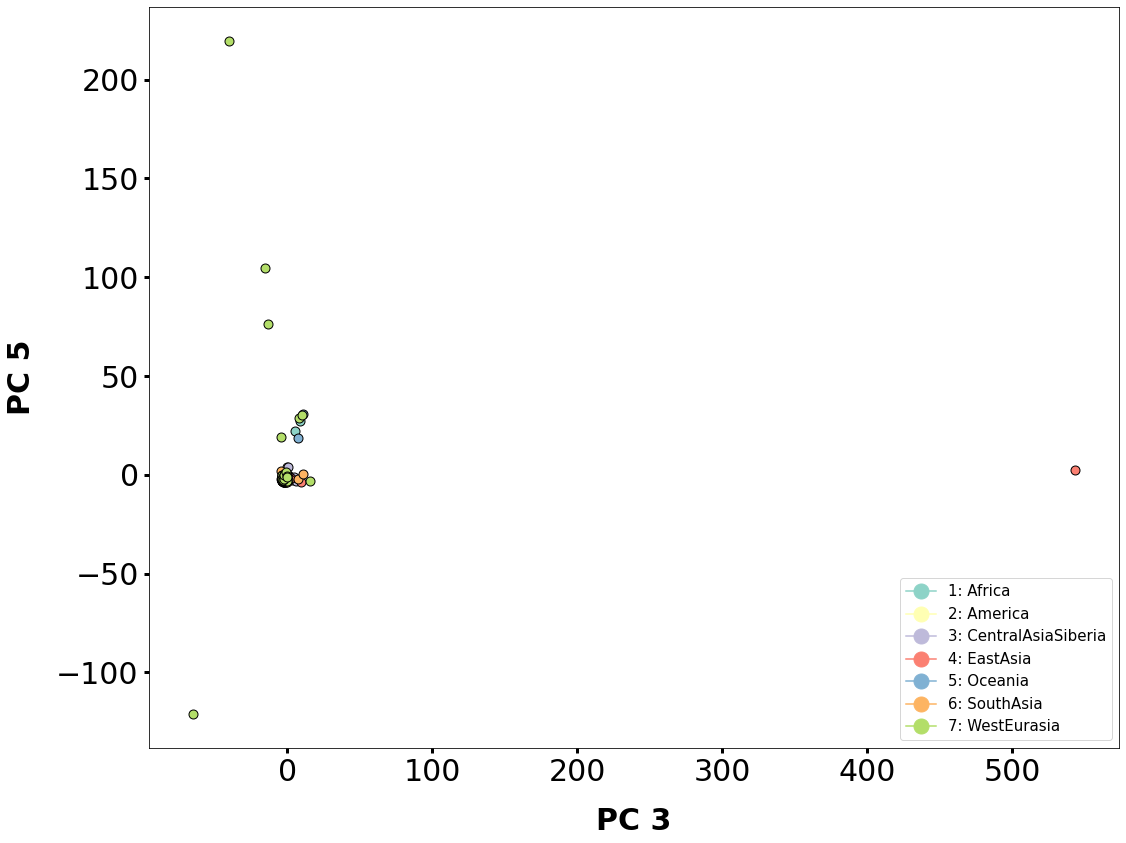

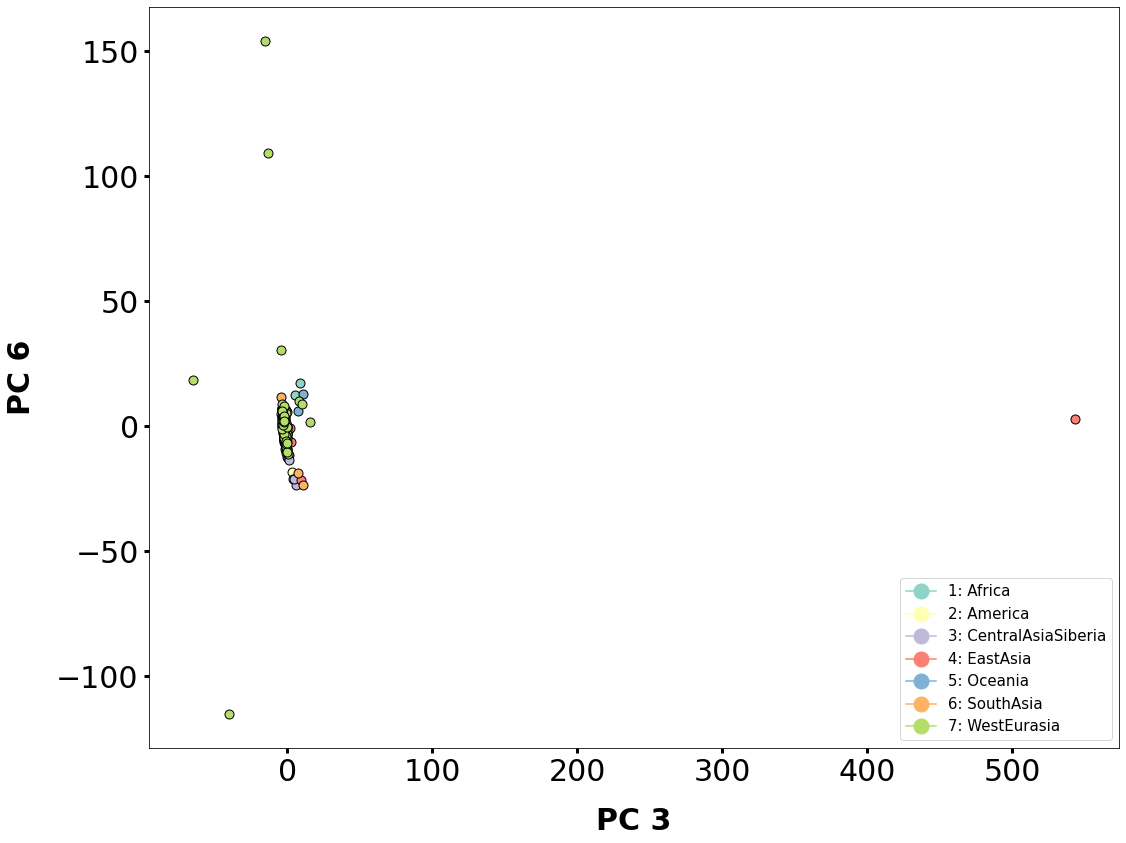

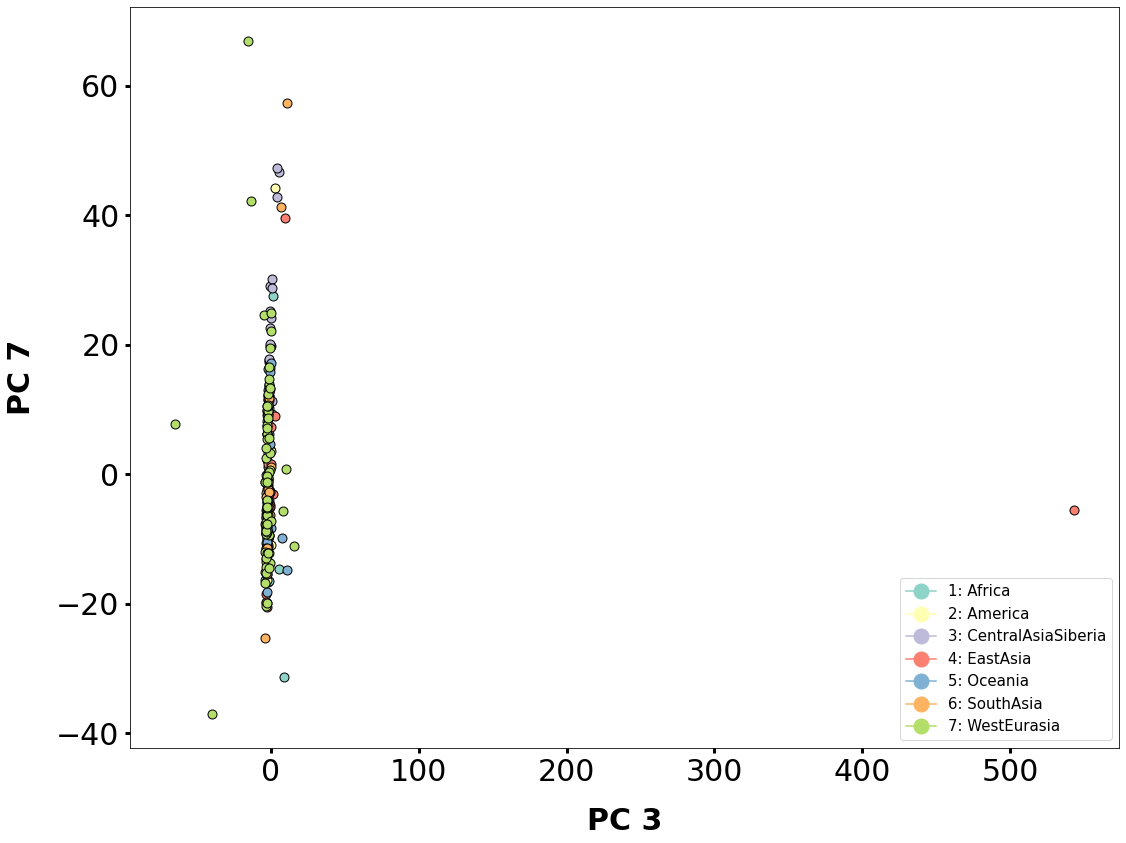

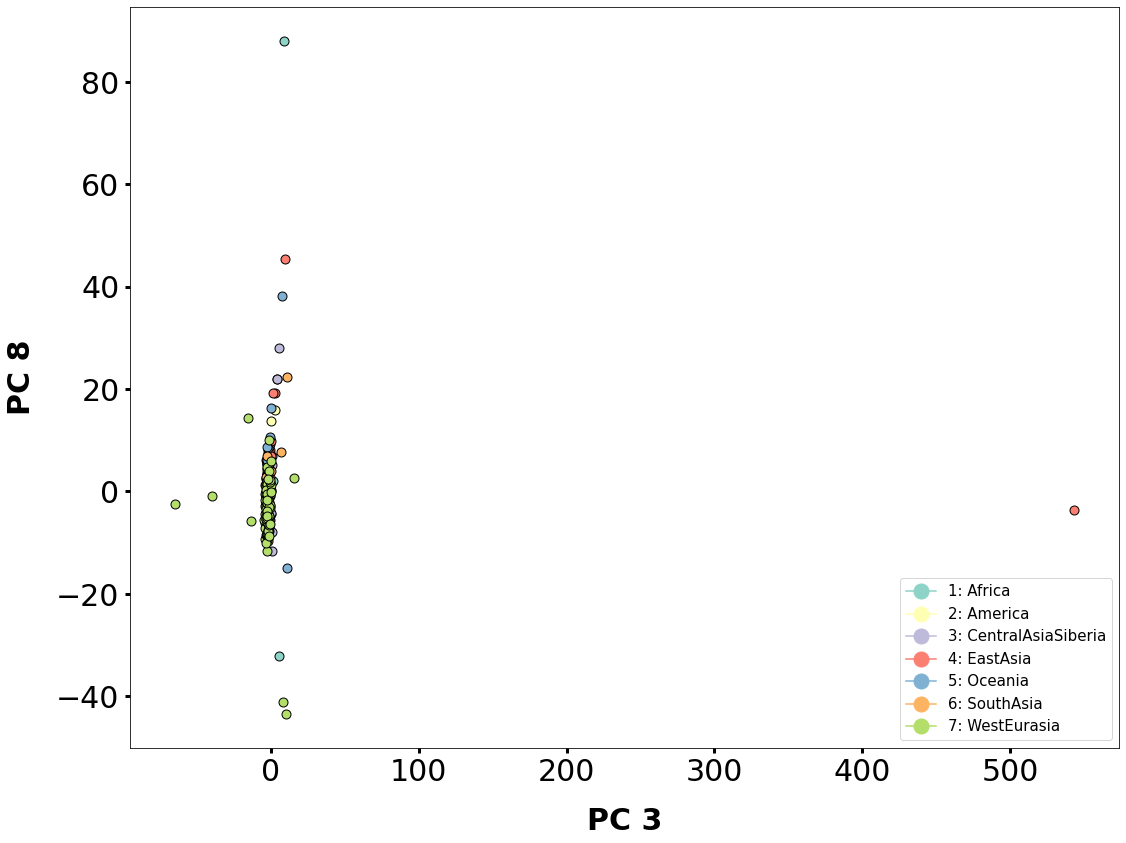

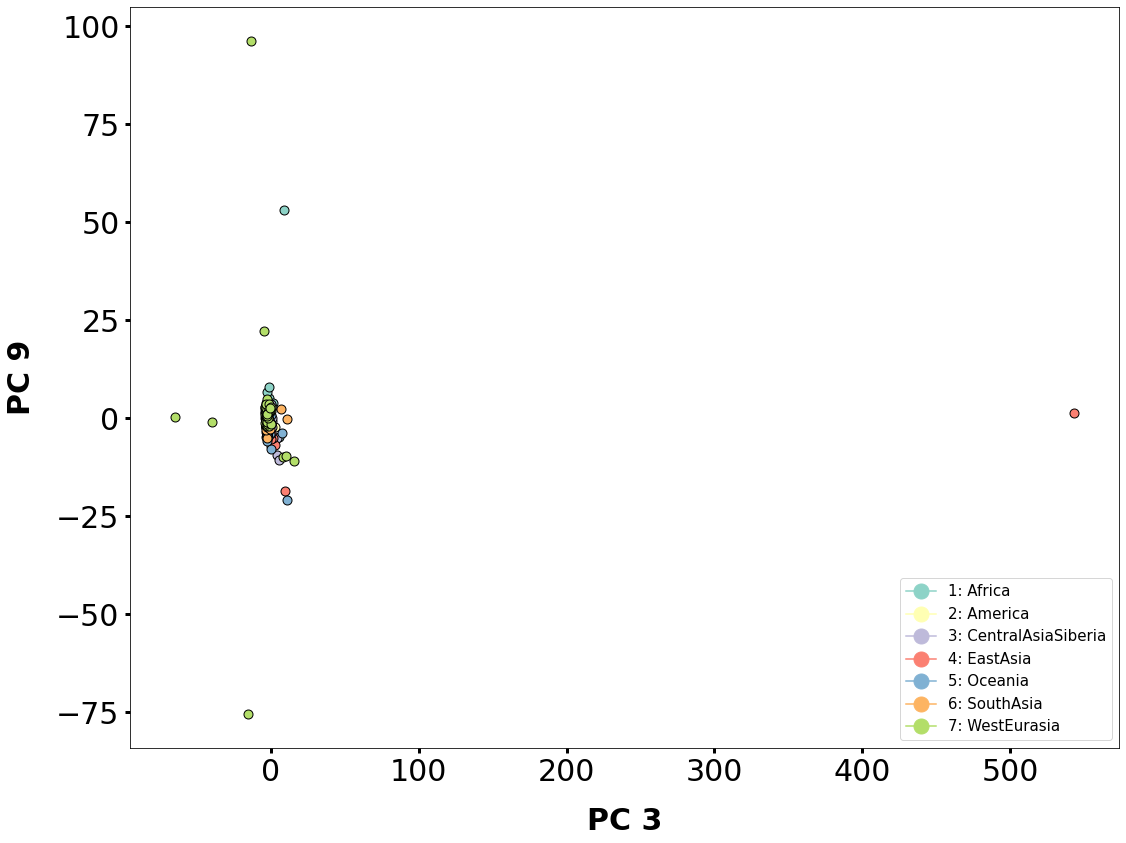

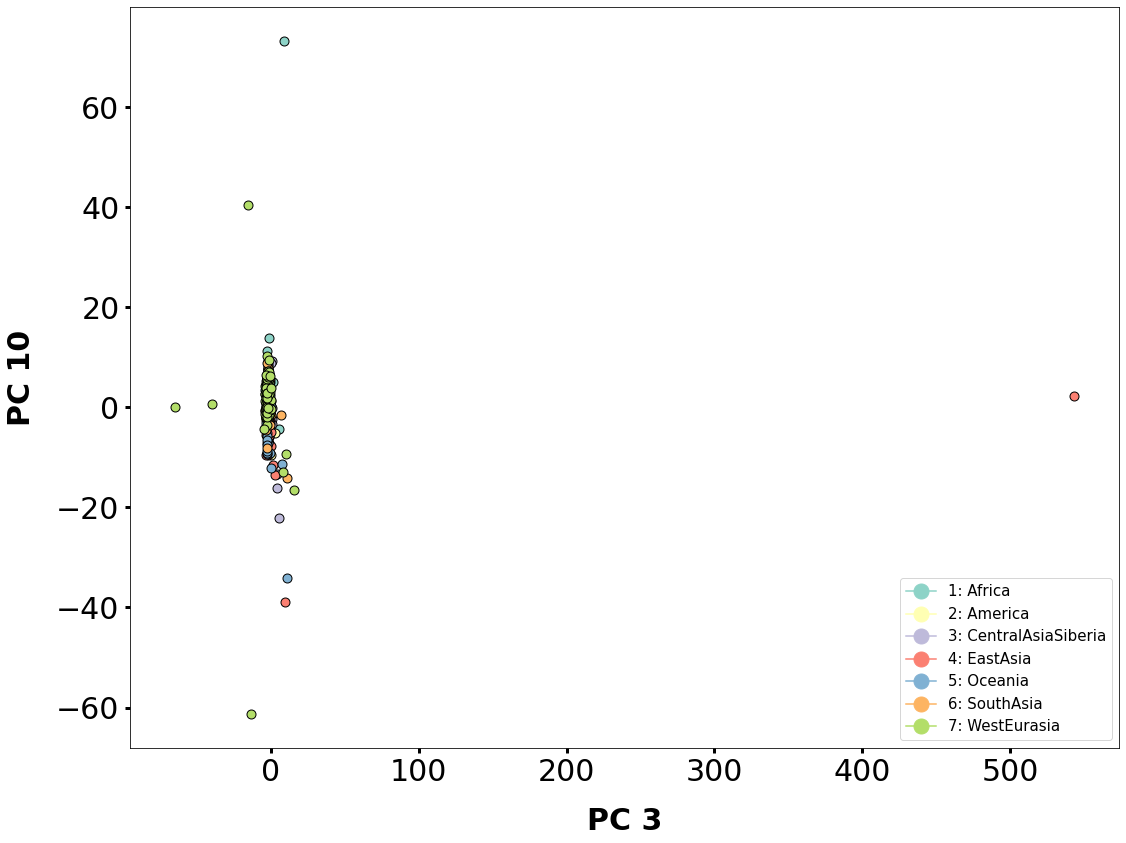

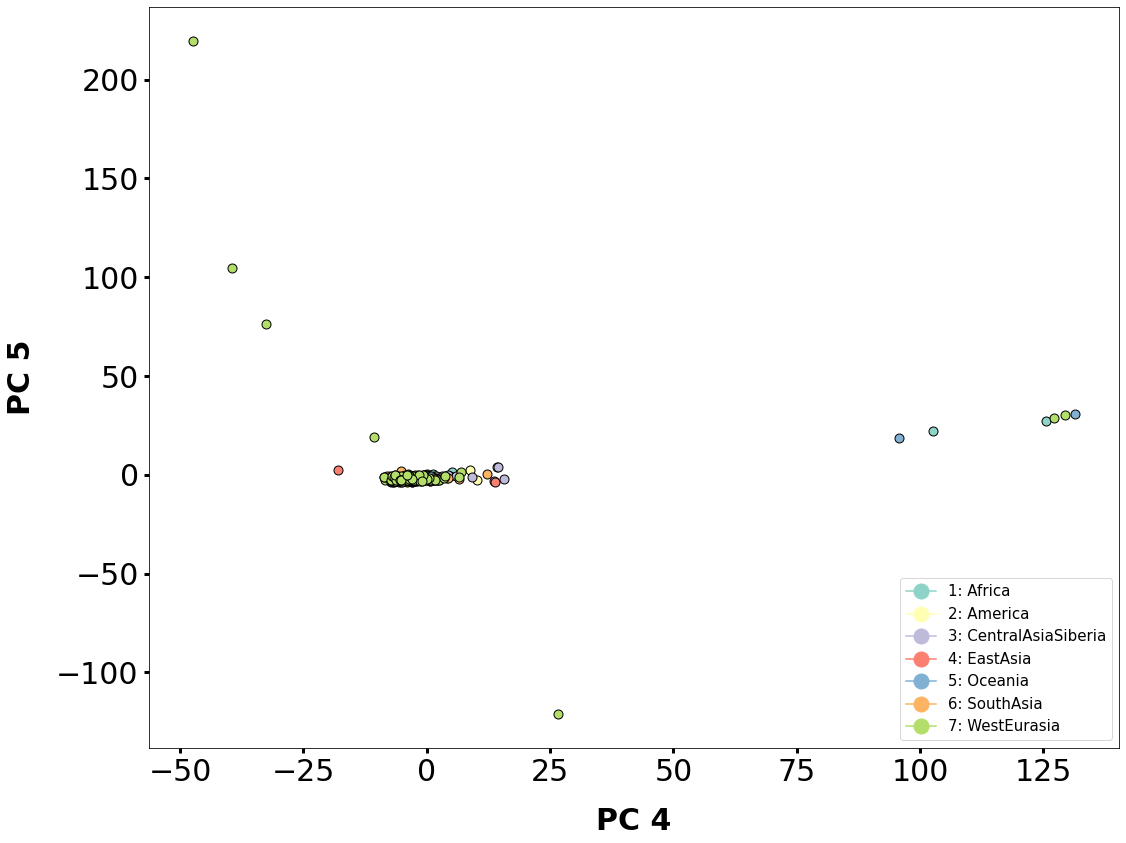

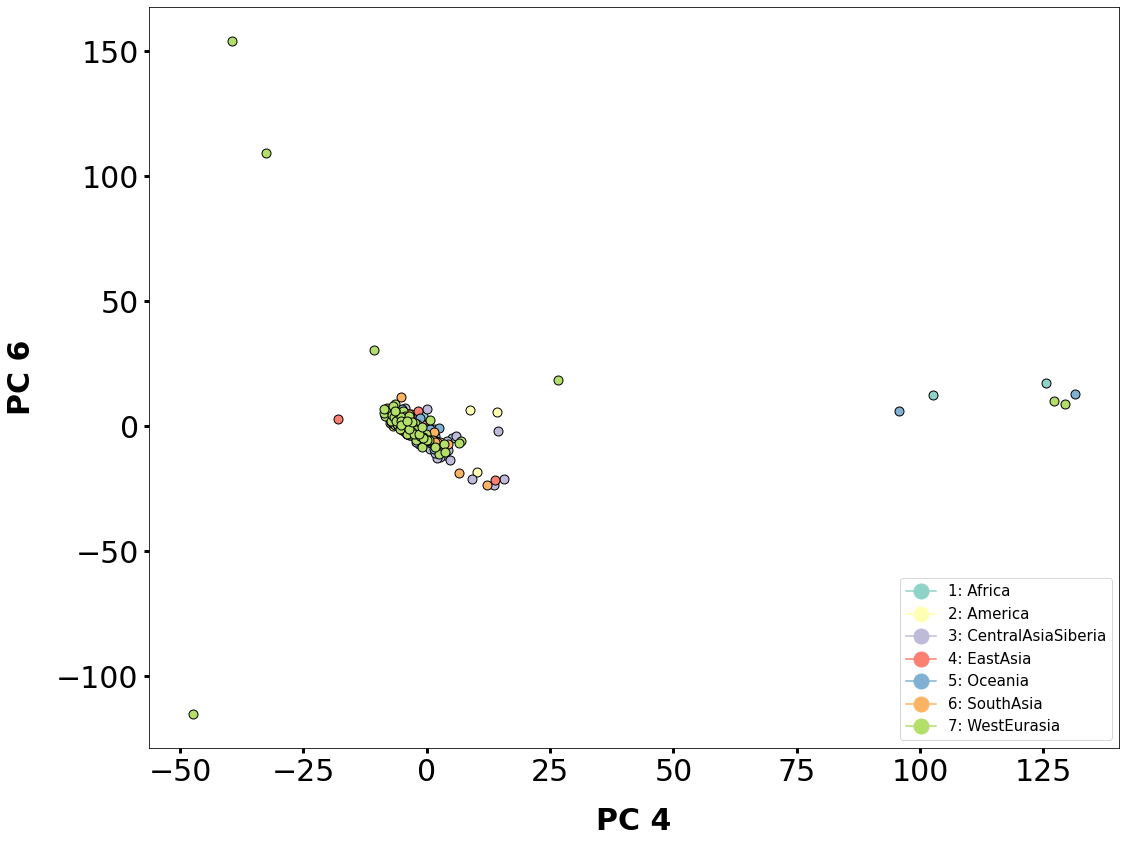

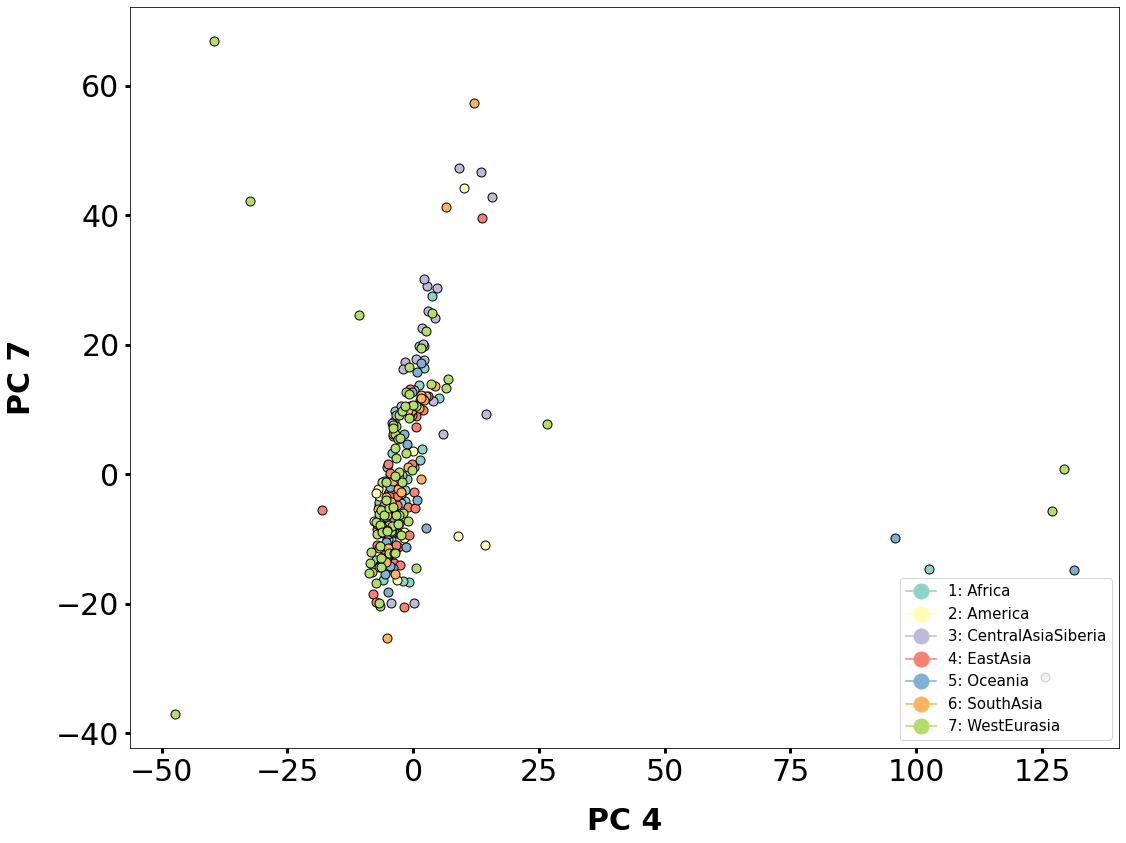

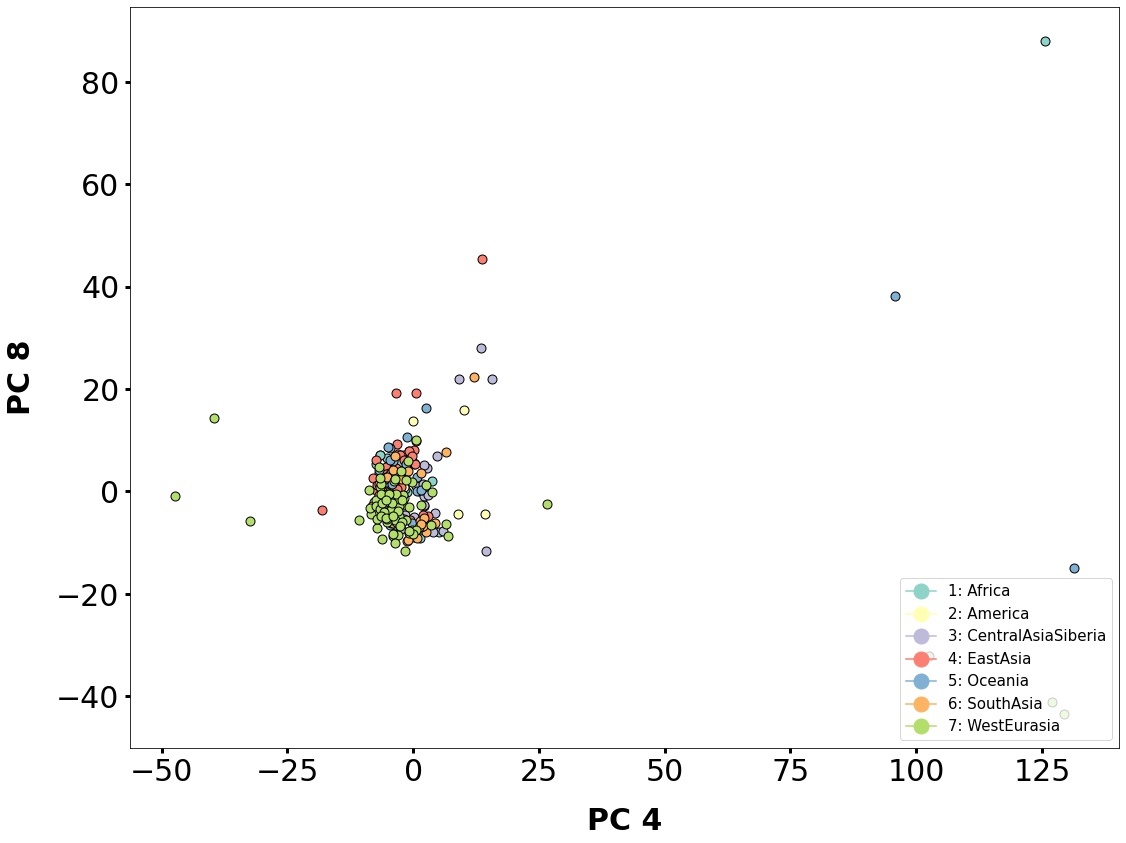

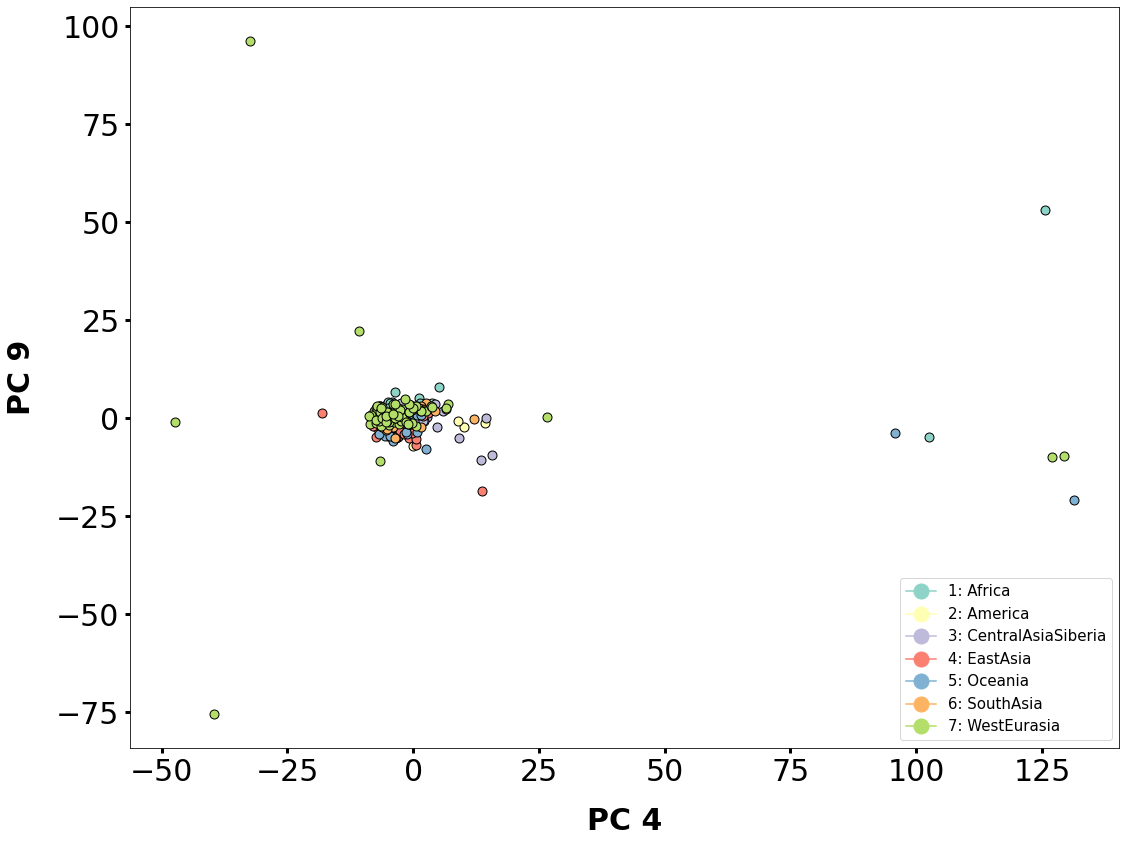

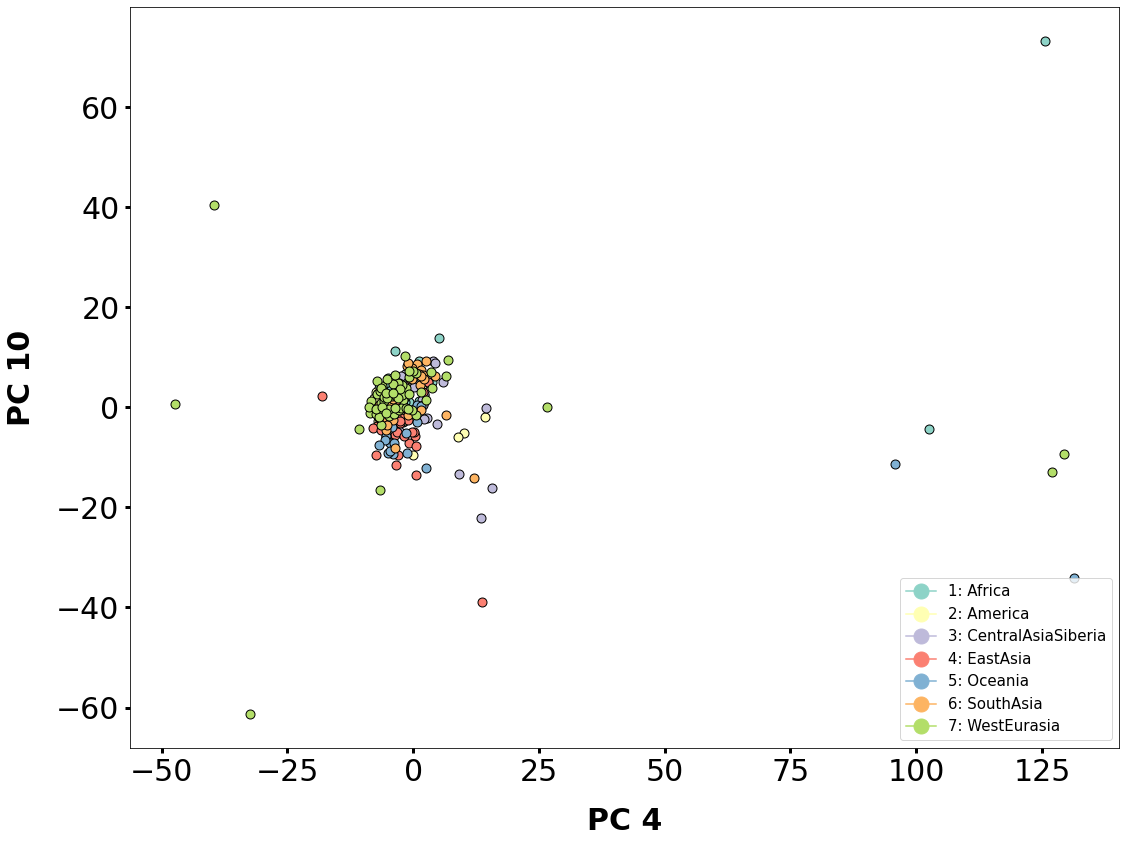

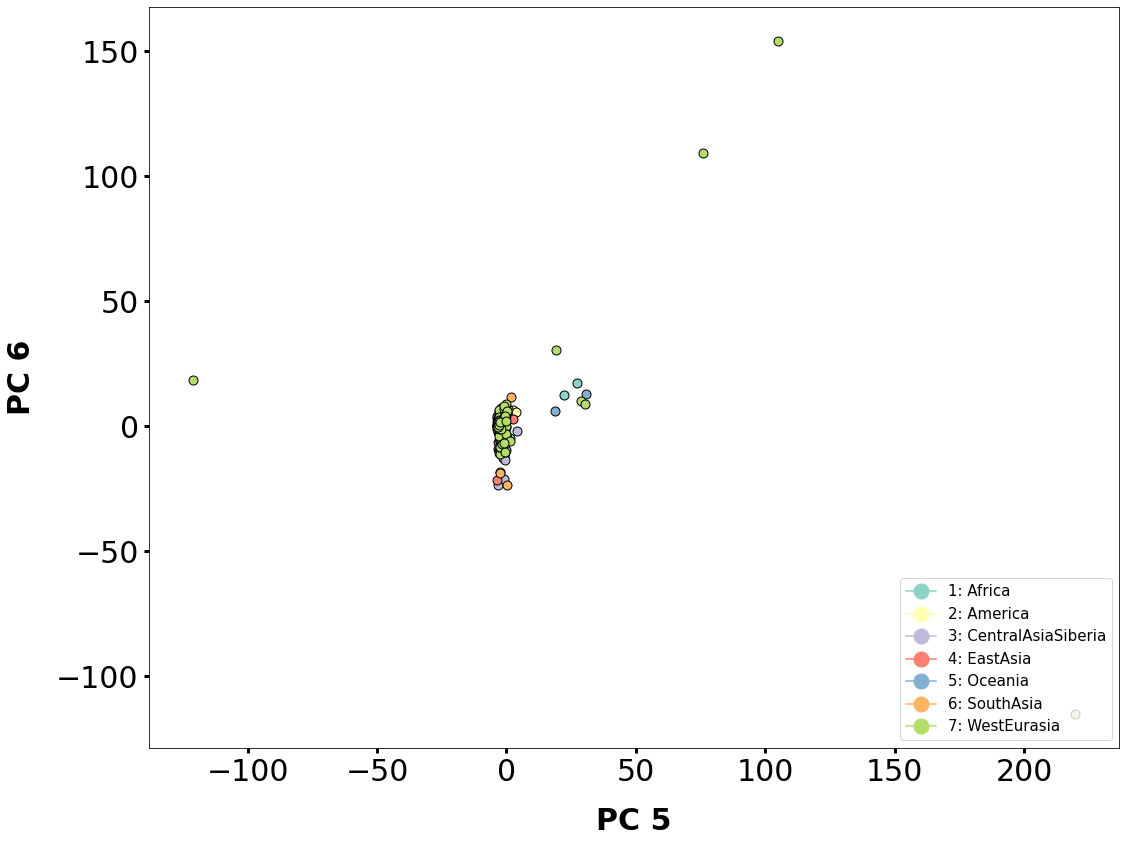

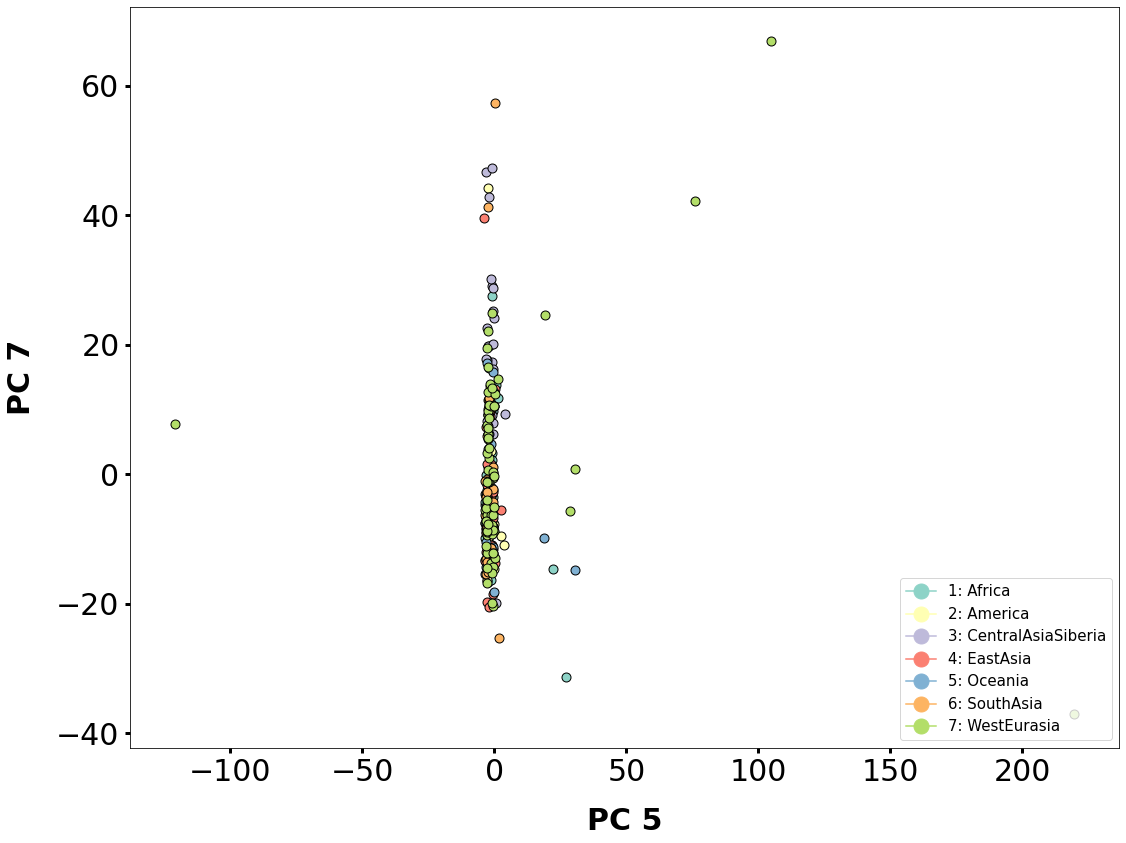

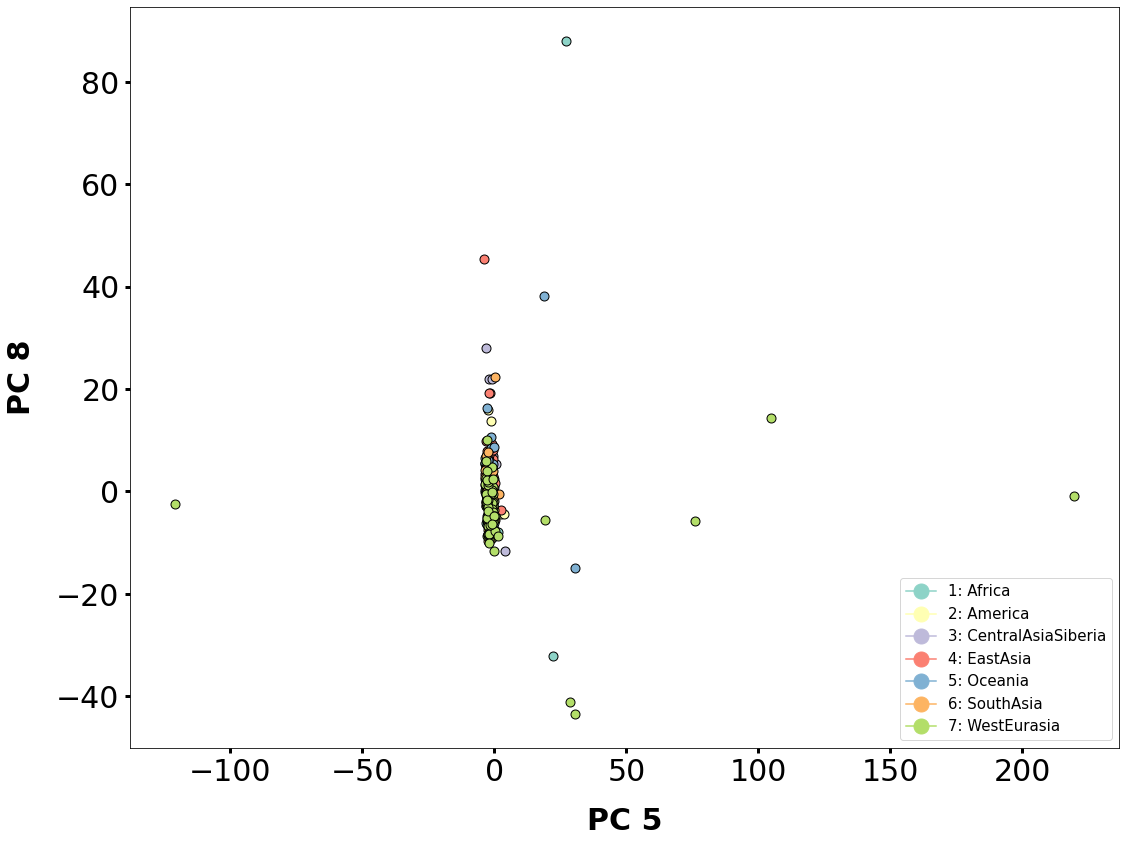

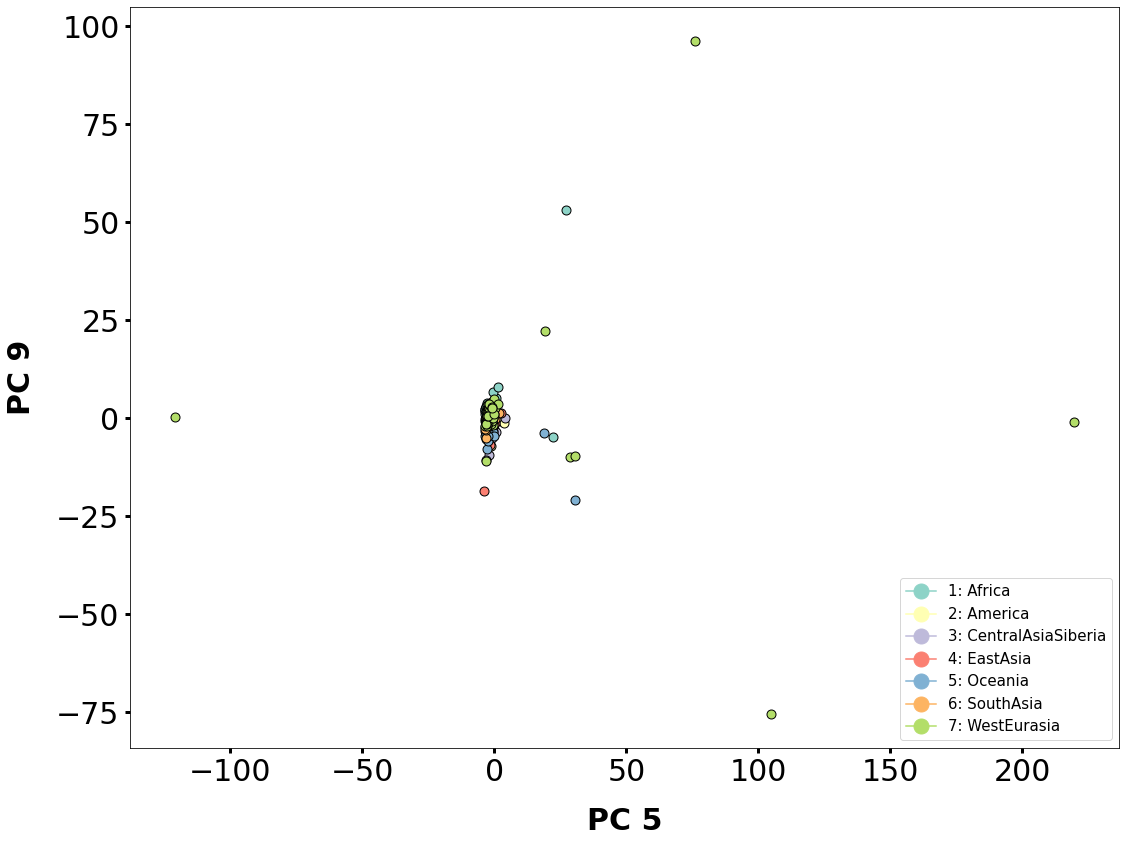

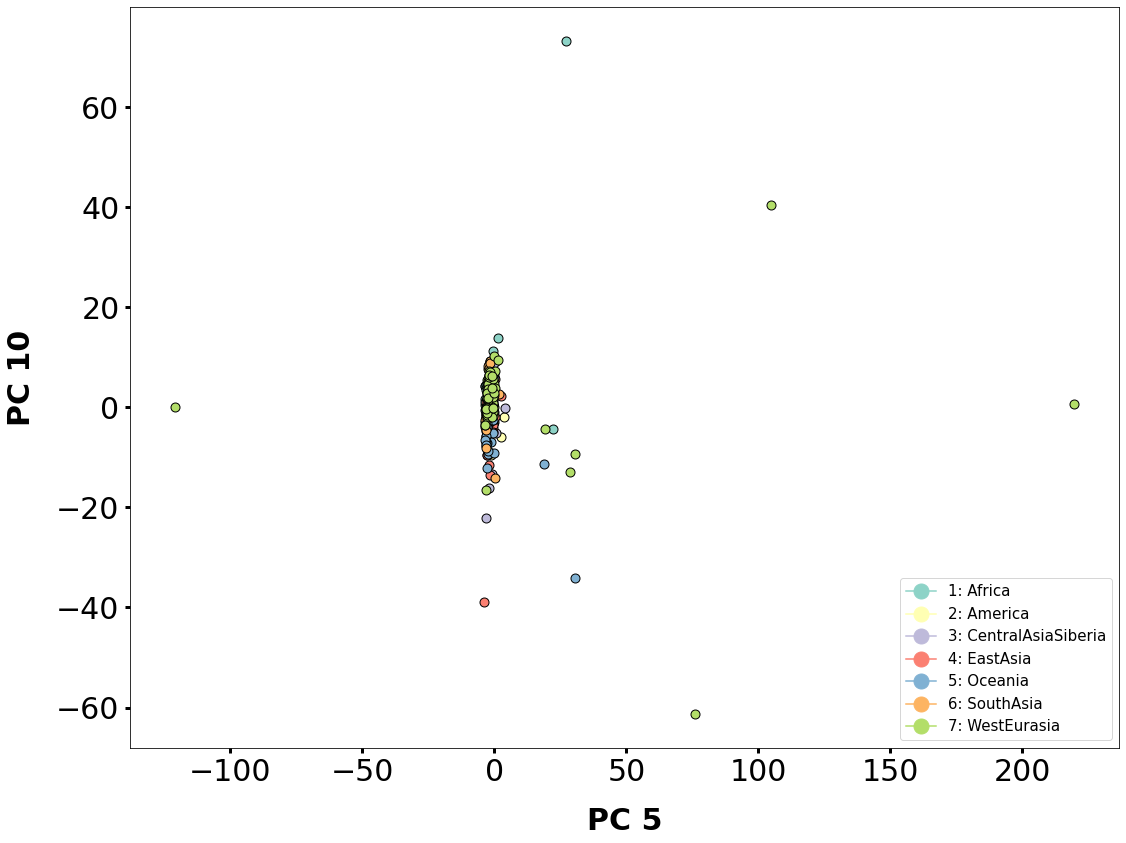

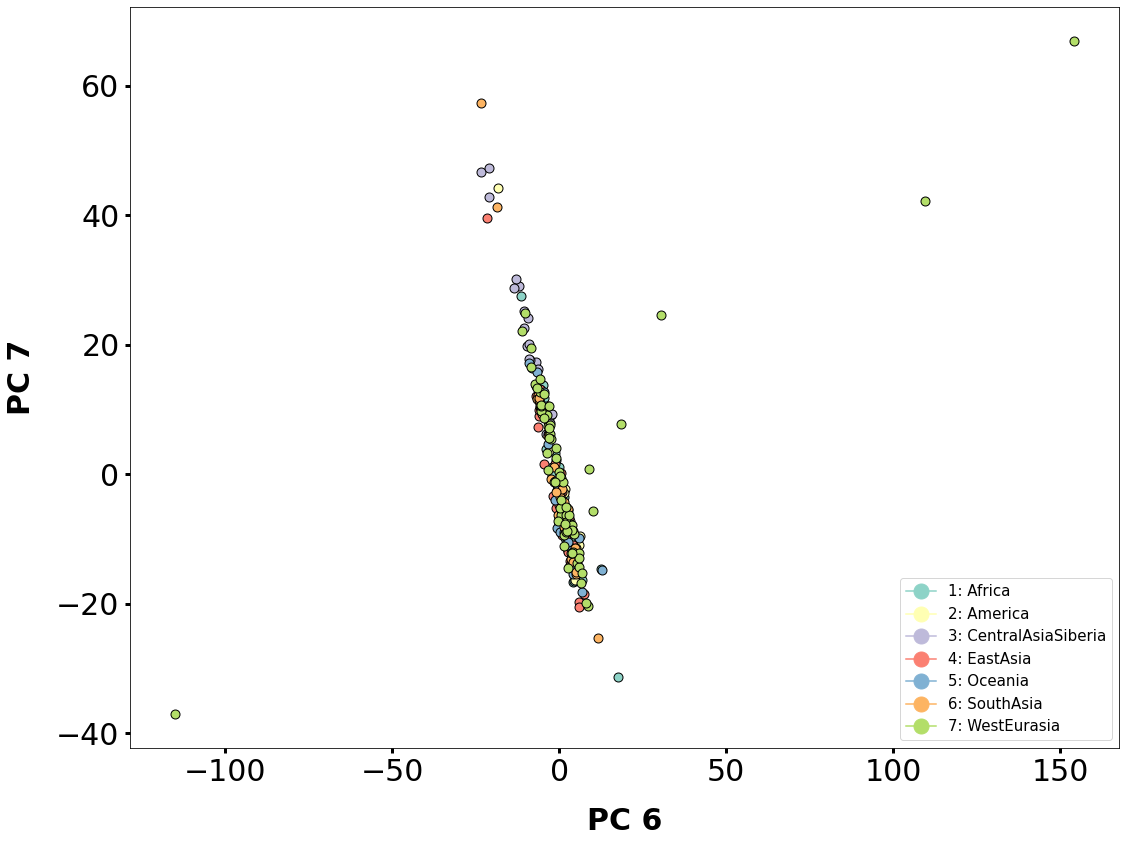

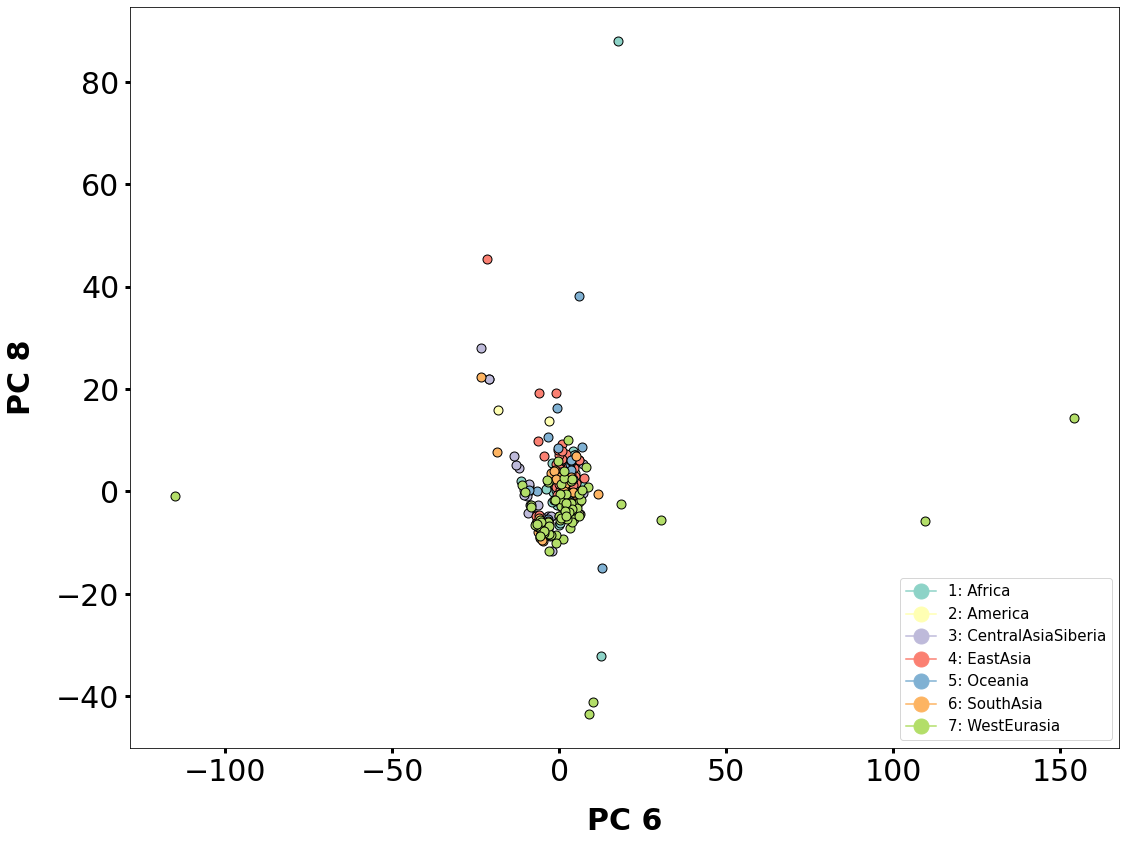

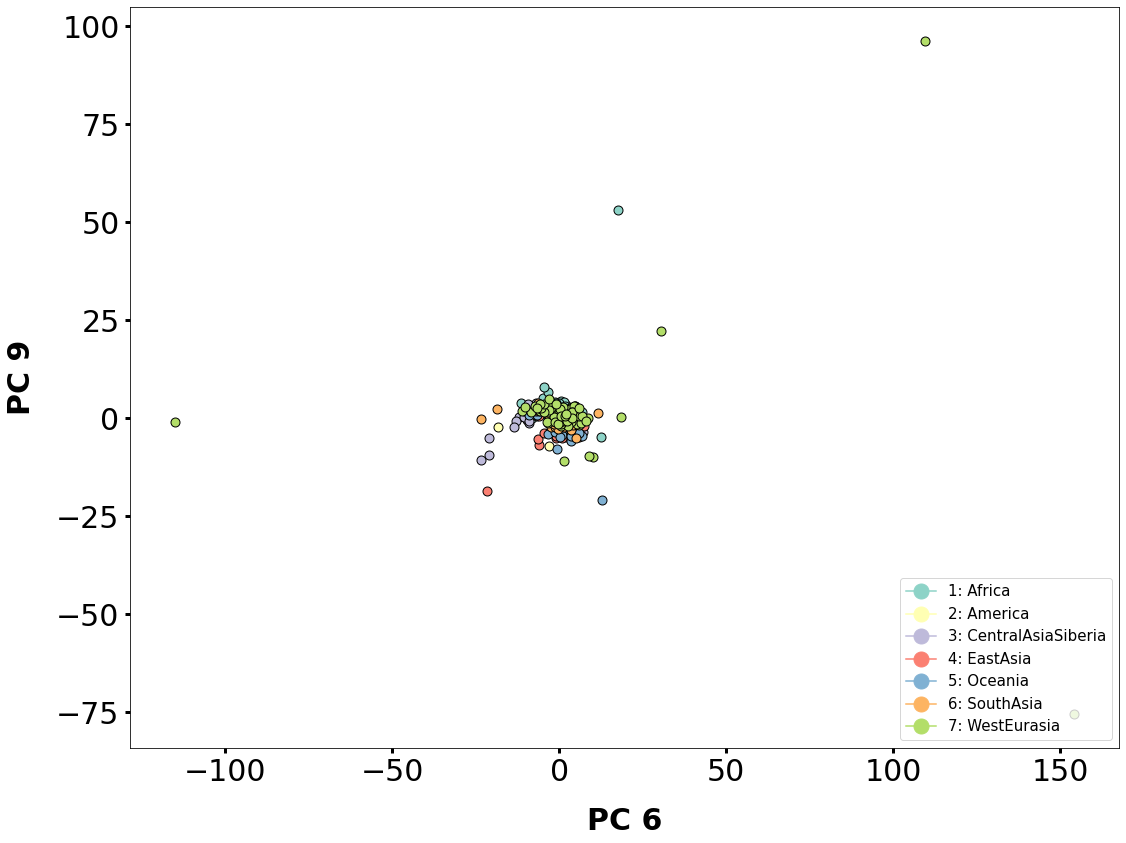

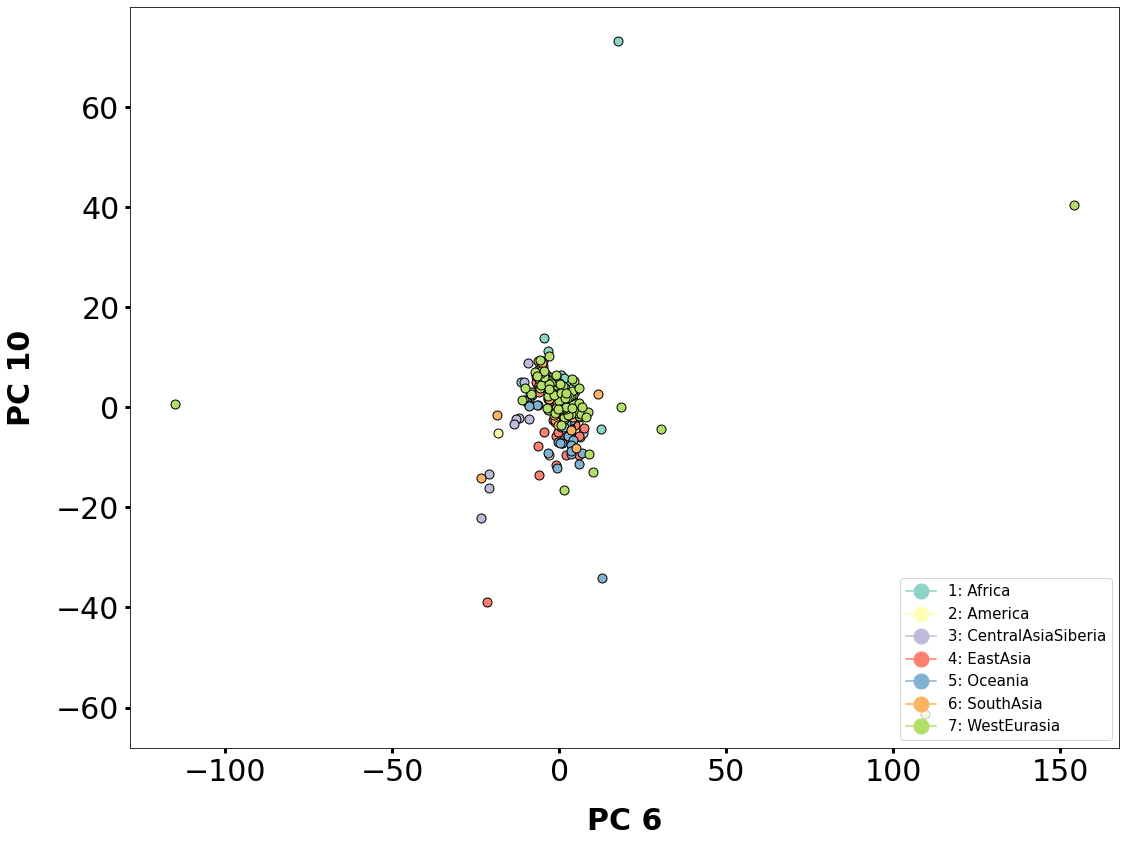

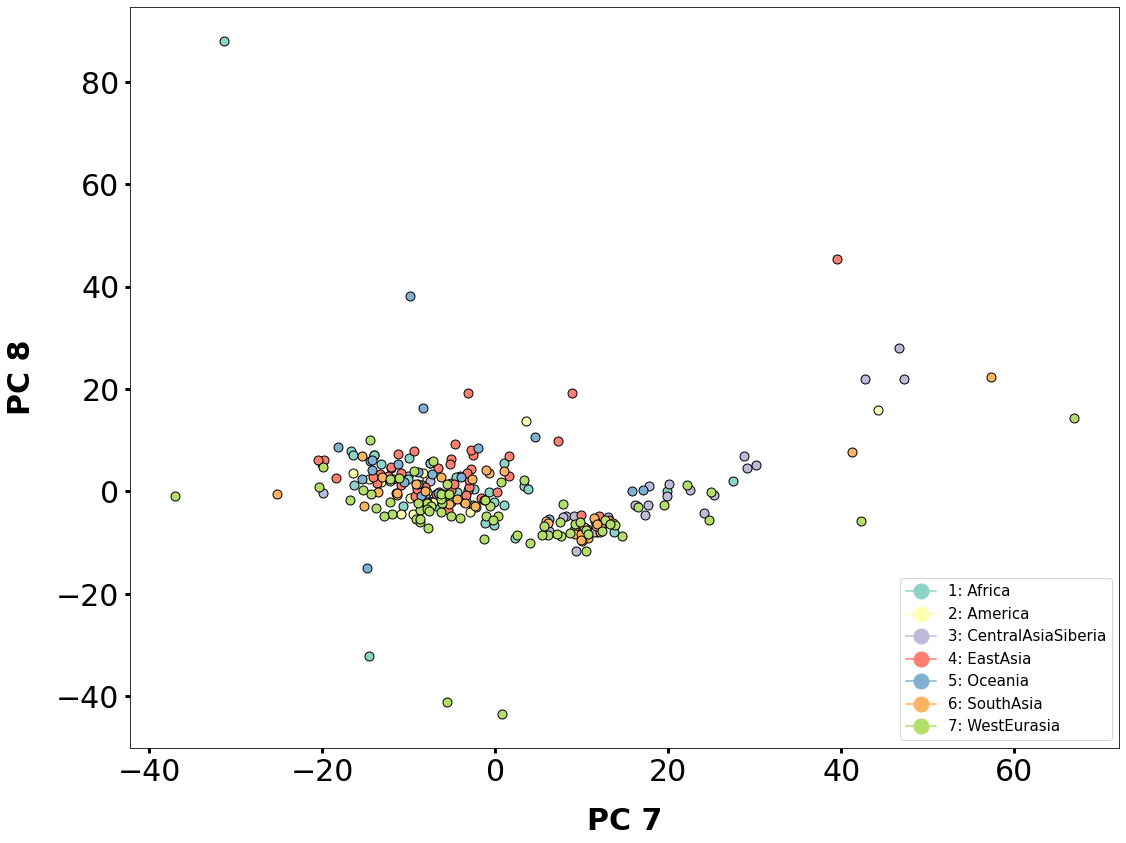

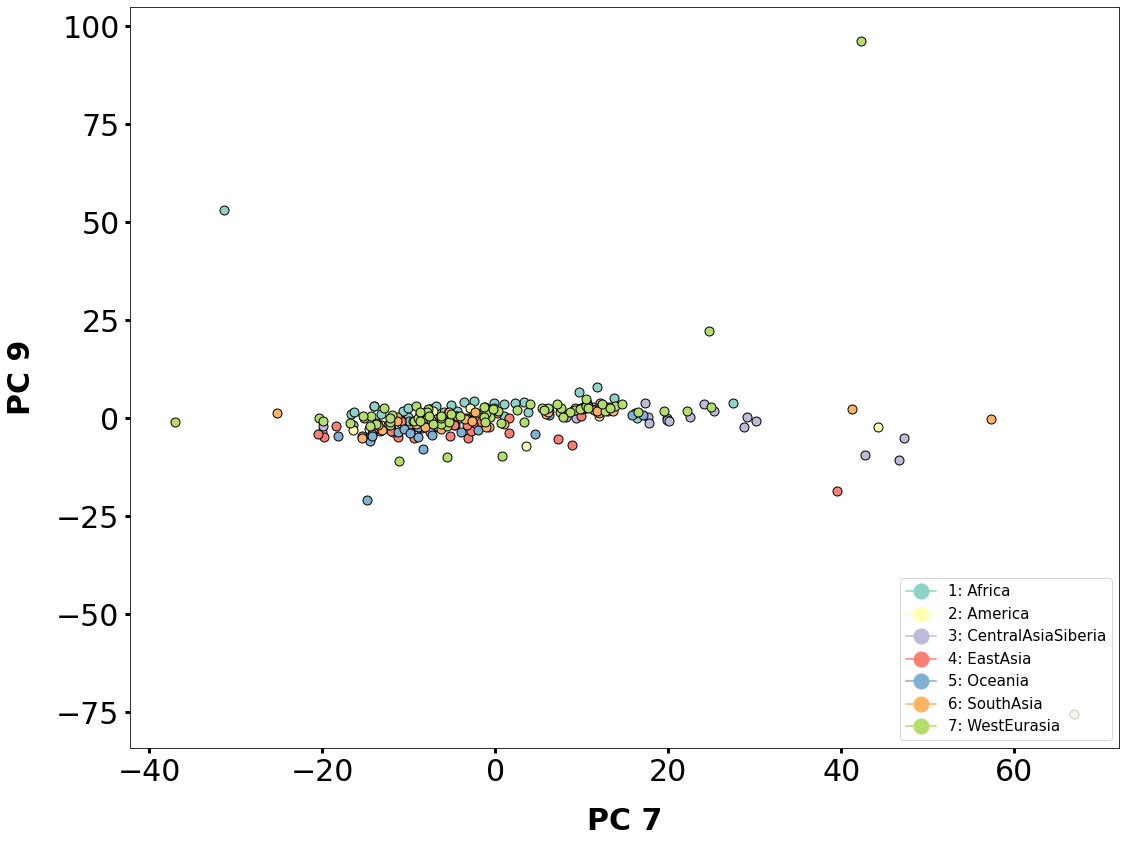

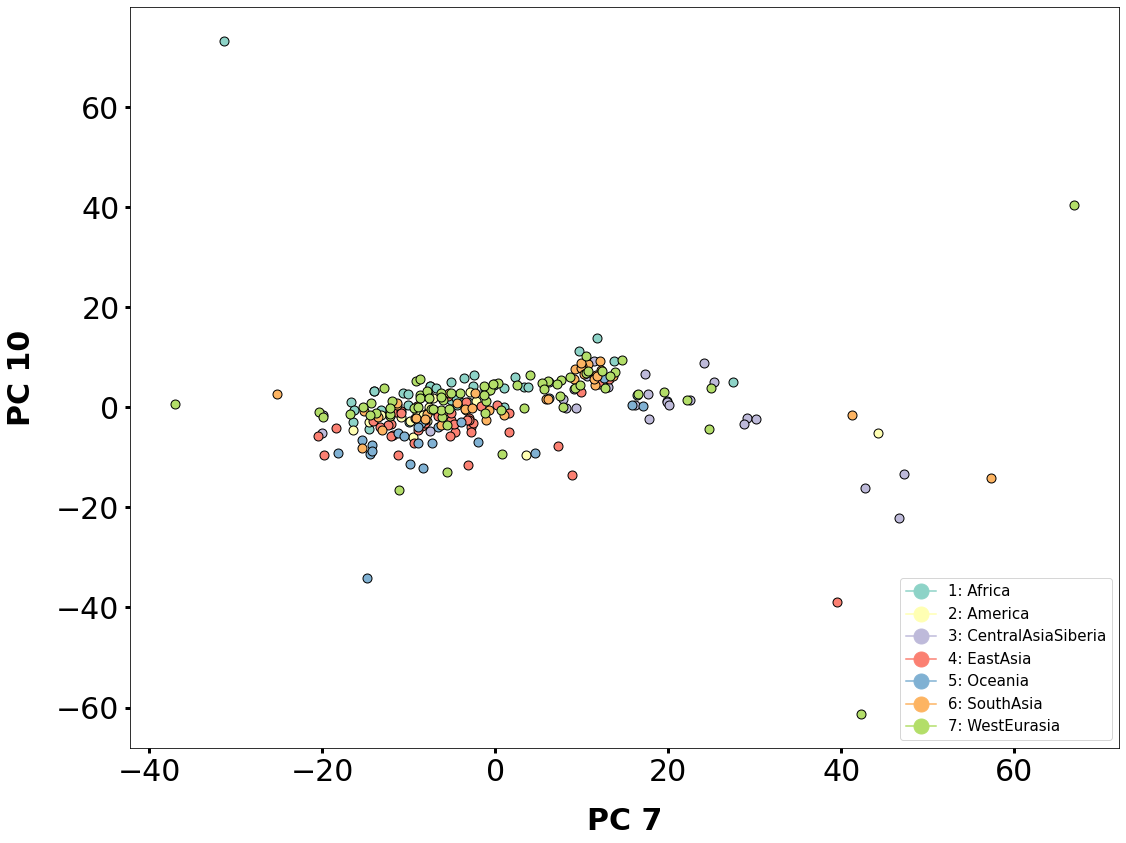

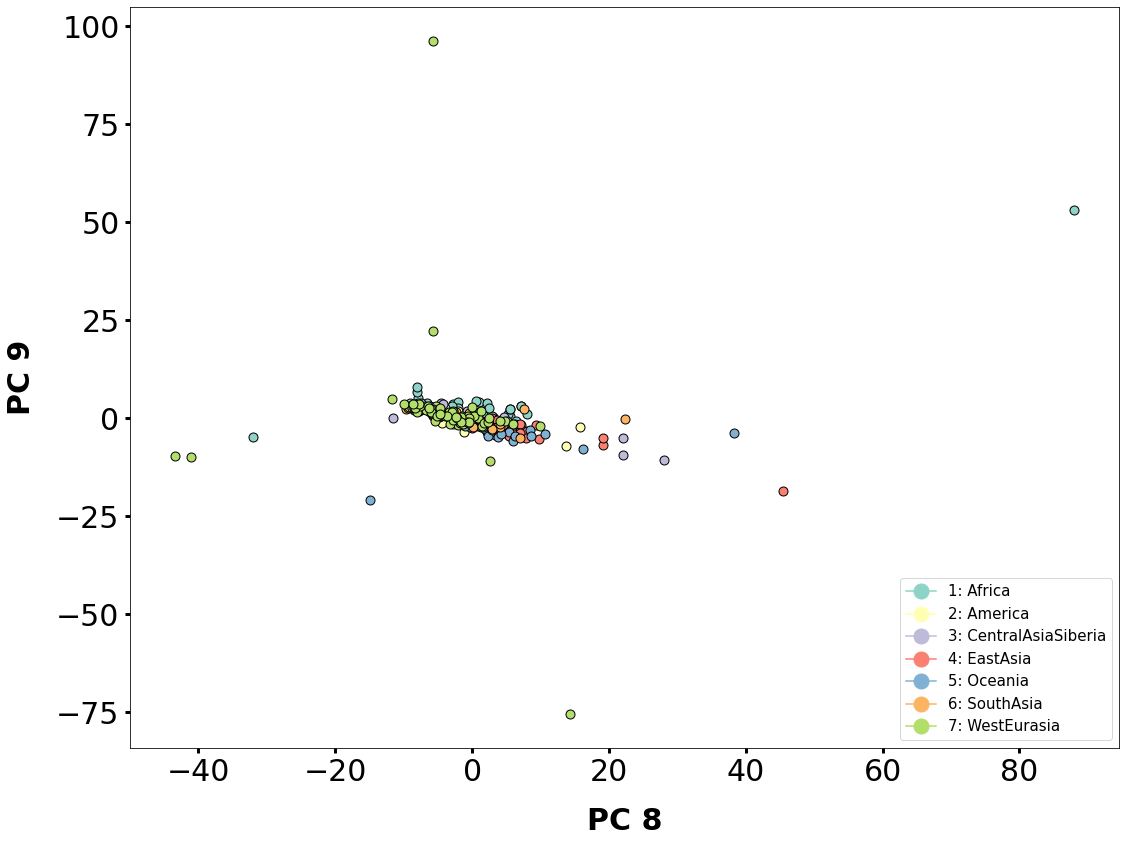

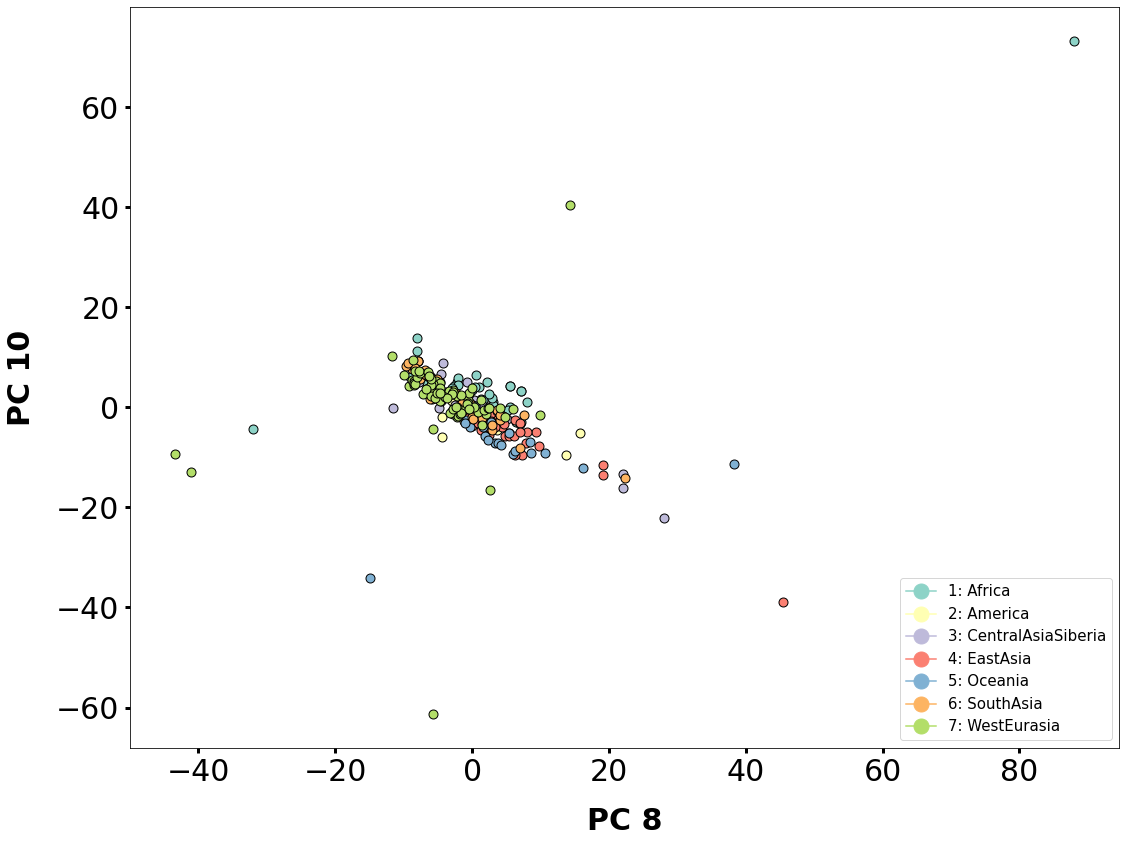

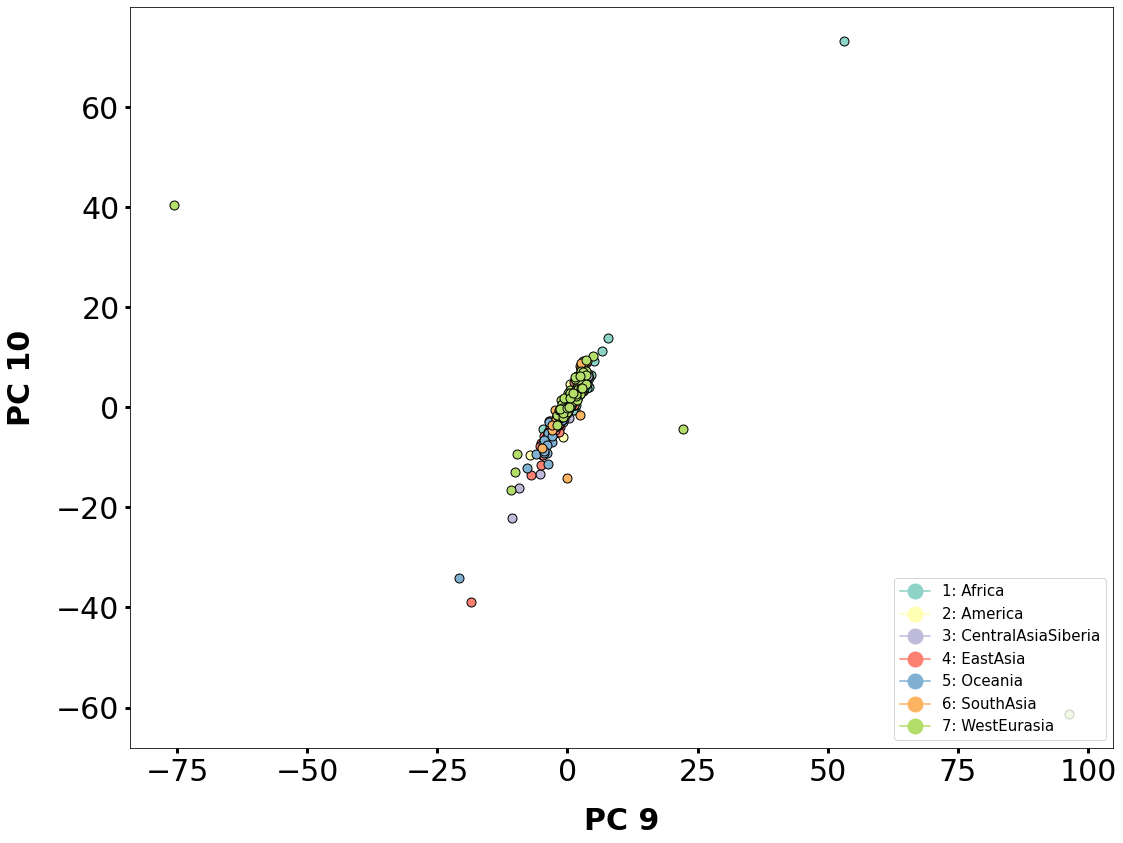

In [17]:
components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='REGION', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))
#    plot_scatter_cluster(data=df_pca, abscissa='component_8', ordinate='component_9', label_horizontal='Component 1', label_vertical='Component 3', factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    

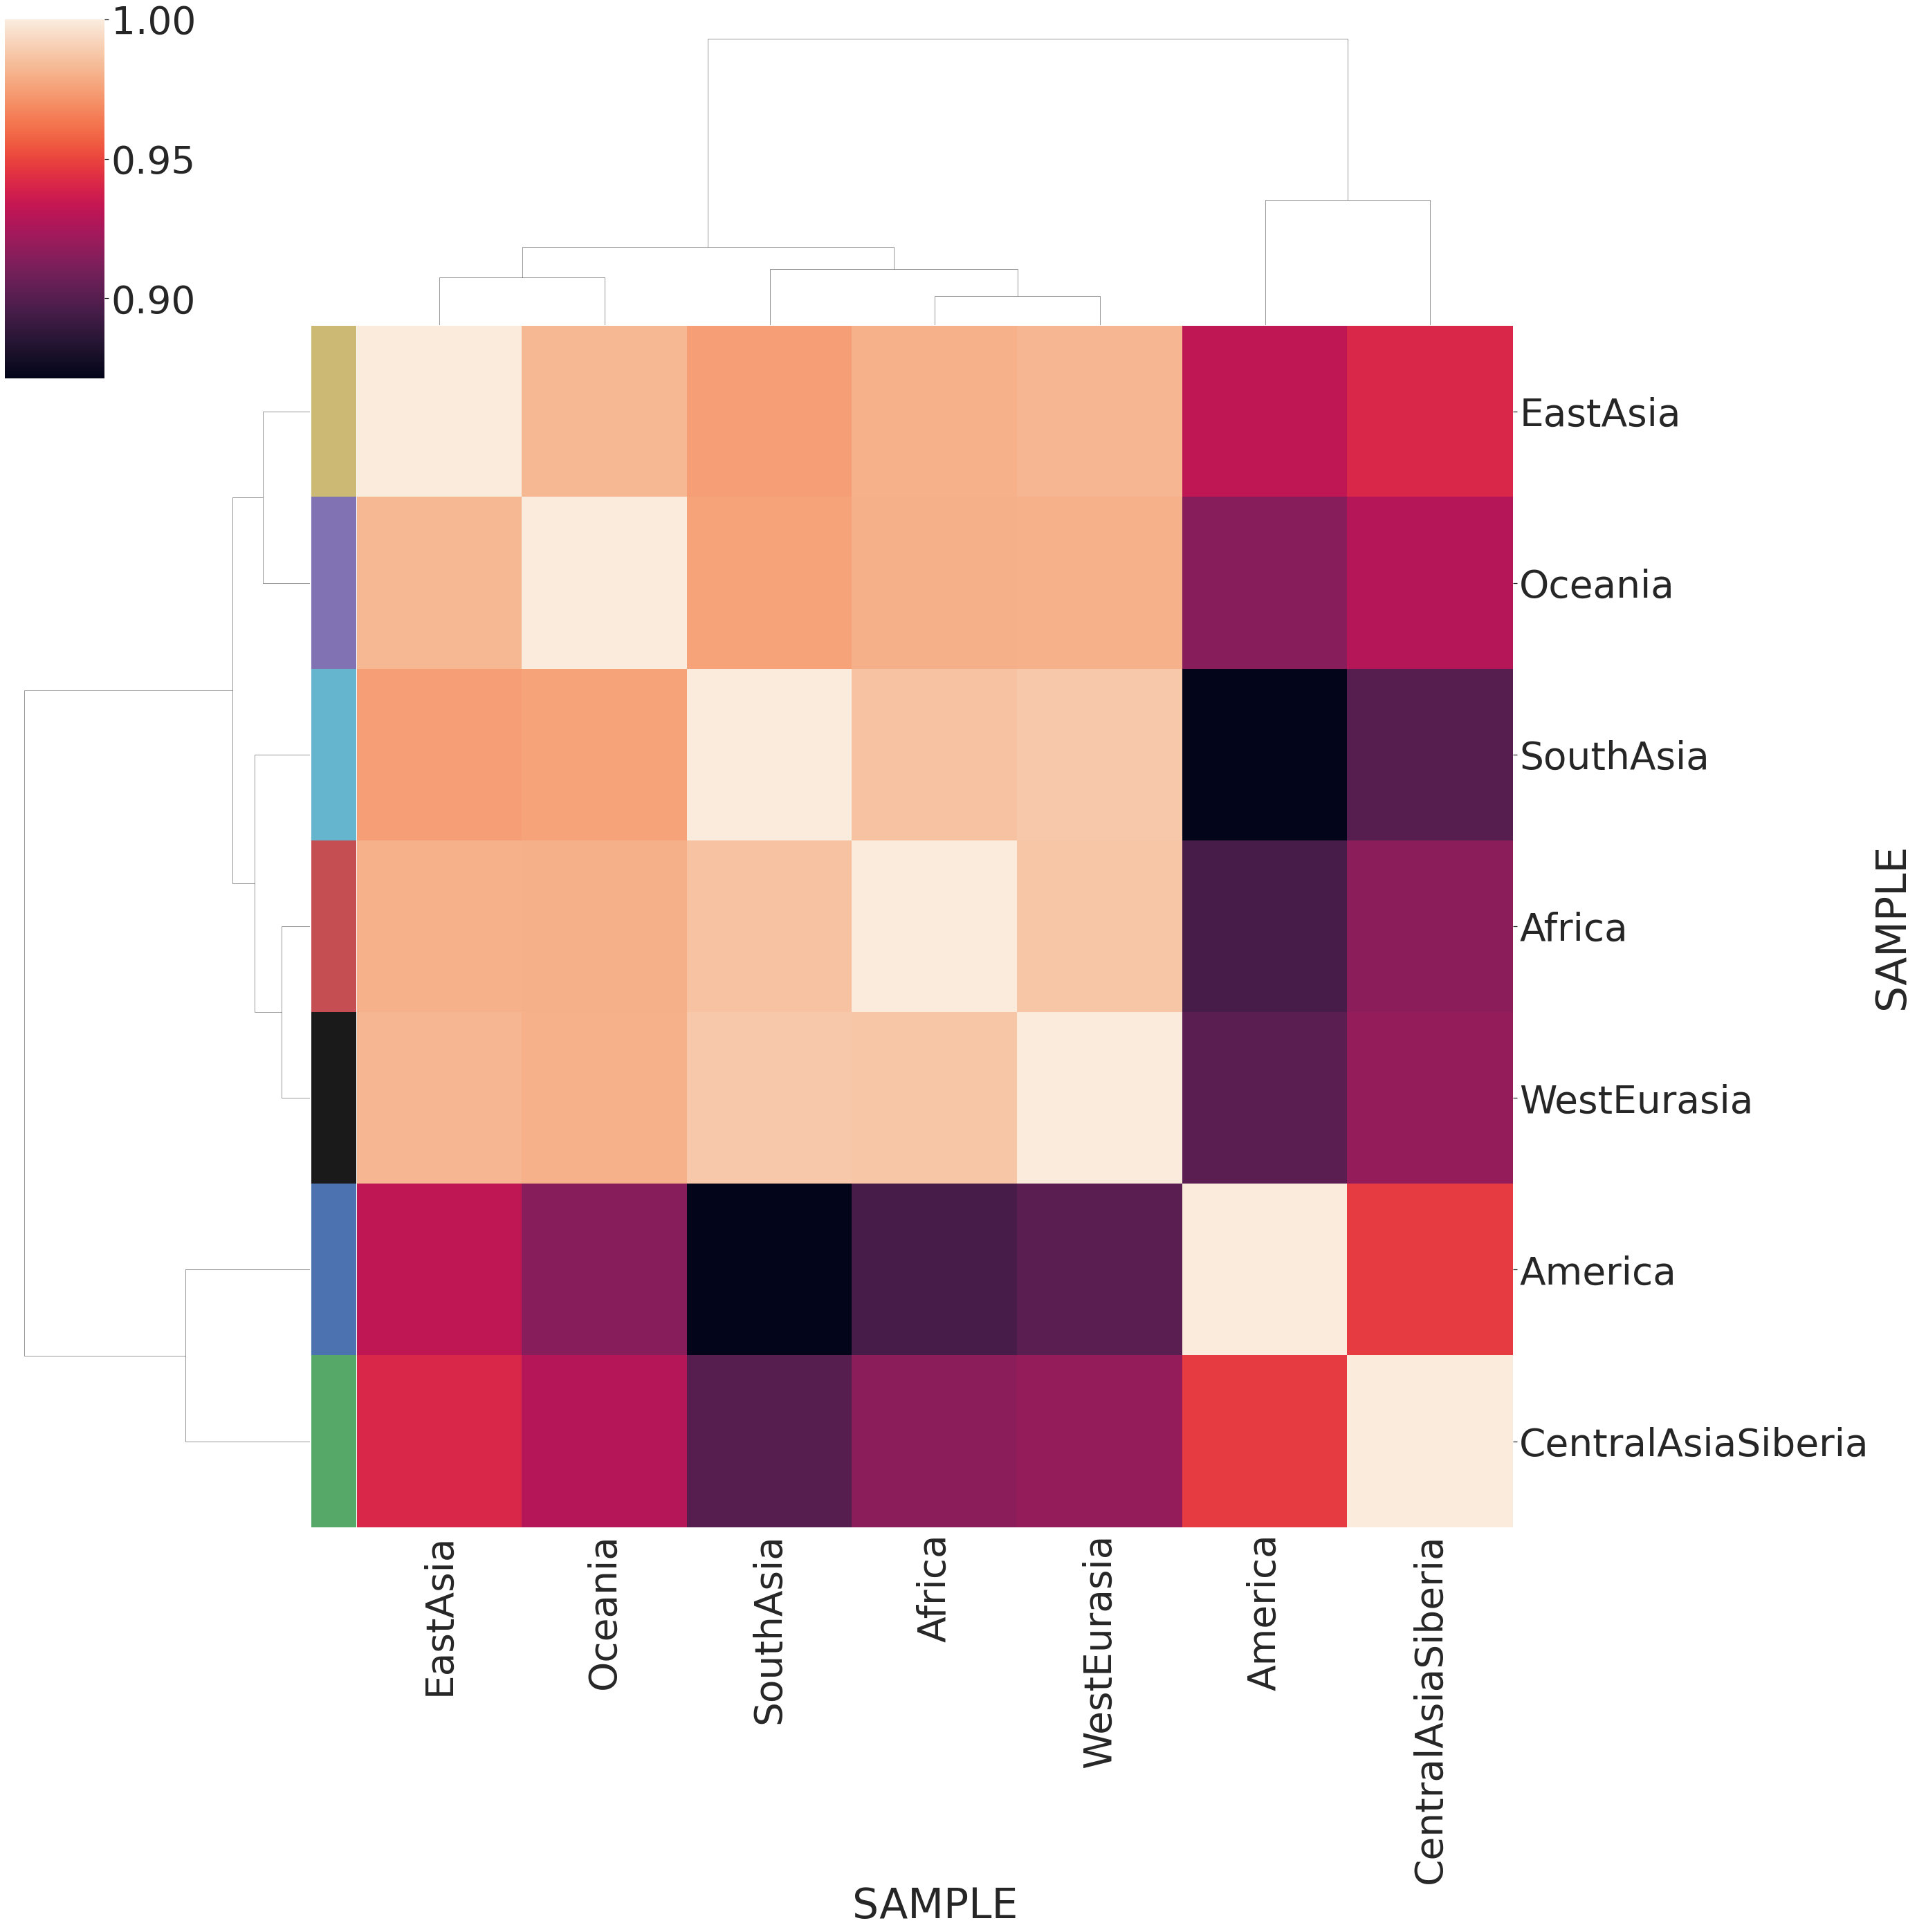

In [27]:
freq = final_cnv.iloc[:,3:283]
freq_input = freq.rename(columns=features['REGION'])
df = freq_input.T
#df = df.reset_index()

#df.groupby('SAMPLE').count().div(df.groupby('SAMPLE').size(),0)


df = df.notnull().groupby(level=0).mean()

df = df.T

lut = dict(zip(df.columns.unique(), "rbgymck"))
lut

seaborn.set(font_scale=5)
corrmatrix = df.corr(method='pearson')
row_colors = df.columns.map(lut)
seaborn.clustermap(corrmatrix, row_colors=row_colors, row_cluster=True, figsize=(40,40))
#plt.savefig('clustermap_regions.pdf')

In [79]:
feature_table = pd.read_table('/branchinecta/jbazanwilliamson/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chromosome')
report = pd.read_table('/branchinecta/jbazanwilliamson/GCF_009914755.1_T2T-CHM13v2.0_assembly_report.txt')

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [82]:
chm13_gene_anotation = feature_table.merge(report, left_on='genomic_accession', right_on='RefSeq-Accn')
chm13_gene_anotation[chm13_gene_anotation['class'] == 'protein_coding']
chm13_gene_anotation


# feature                   class         assembly     assembly_unit  \
0           gene          protein_coding  GCF_009914755.1  Primary Assembly   
1           mRNA                     NaN  GCF_009914755.1  Primary Assembly   
2            CDS            with_protein  GCF_009914755.1  Primary Assembly   
3           gene                  lncRNA  GCF_009914755.1  Primary Assembly   
4          ncRNA                  lncRNA  GCF_009914755.1  Primary Assembly   
...          ...                     ...              ...               ...   
236307      gene          protein_coding  GCF_009914755.1  Primary Assembly   
236308      mRNA                     NaN  GCF_009914755.1  Primary Assembly   
236309       CDS            with_protein  GCF_009914755.1  Primary Assembly   
236310      gene  transcribed_pseudogene  GCF_009914755.1  Primary Assembly   
236311  misc_RNA                     NaN  GCF_009914755.1  Primary Assembly   

          seq_type chromosome genomic_accession     start       end strand  \
0       chromosome          1       NC_060925.1     11134     37628      -   
1       chromosome          1       NC_060925.1     11134     37628      -   
2       chromosome          1       NC_060925.1     13463     37628      -   
3       chromosome          1       NC_060925.1     20892     23710      -   
4       chromosome          1       NC_060925.1     20892     23710      -   
...            ...        ...               ...       ...       ...    ...   
236307  chromosome          Y       NC_060948.1  62446549  62449392      +   
236308  chromosome          Y       NC_060948.1  62446549  62449392      +   
236309  chromosome          Y       NC_060948.1  62446549  62449100      +   
236310  chromosome          Y       NC_060948.1  62449384  62451910      -   
236311  chromosome          Y       NC_060948.1  62449384  62451910      -   

        ... Sequence-Name       Sequence-Role Assigned-Molecule  \
0       ...             1  assembled-molecule                 1   
1       ...             1  assembled-molecule                 1   
2       ...             1  assembled-molecule                 1   
3       ...             1  assembled-molecule                 1   
4       ...             1  assembled-molecule                 1   
...     ...           ...                 ...               ...   
236307  ...             Y  assembled-molecule                 Y   
236308  ...             Y  assembled-molecule                 Y   
236309  ...             Y  assembled-molecule                 Y   
236310  ...             Y  assembled-molecule                 Y   
236311  ...             Y  assembled-molecule                 Y   

       Assigned-Molecule-Location/Type GenBank-Accn  Relationship  \
0                           Chromosome   CP068277.2             =   
1                           Chromosome   CP068277.2             =   
2                           Chromosome   CP068277.2             =   
3                           Chromosome   CP068277.2             =   
4                           Chromosome   CP068277.2             =   
...                                ...          ...           ...   
236307                      Chromosome   CP086569.2             =   
236308                      Chromosome   CP086569.2             =   
236309                      Chromosome   CP086569.2             =   
236310                      Chromosome   CP086569.2             =   
236311                      Chromosome   CP086569.2             =   

        RefSeq-Accn     Assembly-Unit  Sequence-Length UCSC-style-name  
0       NC_060925.1  Primary Assembly        248387328              na  
1       NC_060925.1  Primary Assembly        248387328              na  
2       NC_060925.1  Primary Assembly        248387328              na  
3       NC_060925.1  Primary Assembly        248387328              na  
4       NC_060925.1  Primary Assembly        248387328              na  
...             ...               ...            

# feature           class         assembly     assembly_unit  \
0           gene  protein_coding  GCF_009914755.1  Primary Assembly   
7           gene  protein_coding  GCF_009914755.1  Primary Assembly   
42          gene  protein_coding  GCF_009914755.1  Primary Assembly   
49          gene  protein_coding  GCF_009914755.1  Primary Assembly   
52          gene  protein_coding  GCF_009914755.1  Primary Assembly   
...          ...             ...              ...               ...   
232256      gene  protein_coding  GCF_009914755.1  Primary Assembly   
236280      gene  protein_coding  GCF_009914755.1  Primary Assembly   
236288      gene  protein_coding  GCF_009914755.1  Primary Assembly   
236300      gene  protein_coding  GCF_009914755.1  Primary Assembly   
236307      gene  protein_coding  GCF_009914755.1  Primary Assembly   

          seq_type chromosome genomic_accession     start       end strand  \
0       chromosome          1       NC_060925.1     11134     37628      -   
7       chromosome          1       NC_060925.1    111940    112877      -   
42      chromosome          1       NC_060925.1    353566    373316      +   
49      chromosome          1       NC_060925.1    372945    388041      -   
52      chromosome          1       NC_060925.1    389374    394430      +   
...            ...        ...               ...       ...       ...    ...   
232256  chromosome          Y       NC_060948.1  36480752  36497801      +   
236280  chromosome          Y       NC_060948.1  62190003  62204700      +   
236288  chromosome          Y       NC_060948.1  62306325  62368760      +   
236300  chromosome          Y       NC_060948.1  62422687  62435805      +   
236307  chromosome          Y       NC_060948.1  62446549  62449392      +   

        ... Sequence-Name       Sequence-Role Assigned-Molecule  \
0       ...             1  assembled-molecule                 1   
7       ...             1  assembled-molecule                 1   
42      ...             1  assembled-molecule                 1   
49      ...             1  assembled-molecule                 1   
52      ...             1  assembled-molecule                 1   
...     ...           ...                 ...               ...   
232256  ...             Y  assembled-molecule                 Y   
236280  ...             Y  assembled-molecule                 Y   
236288  ...             Y  assembled-molecule                 Y   
236300  ...             Y  assembled-molecule                 Y   
236307  ...             Y  assembled-molecule                 Y   

       Assigned-Molecule-Location/Type GenBank-Accn  Relationship  \
0                           Chromosome   CP068277.2             =   
7                           Chromosome   CP068277.2             =   
42                          Chromosome   CP068277.2             =   
49                          Chromosome   CP068277.2             =   
52                          Chromosome   CP068277.2             =   
...                                ...          ...           ...   
232256                      Chromosome   CP086569.2             =   
236280                      Chromosome   CP086569.2             =   
236288                      Chromosome   CP086569.2             =   
236300                      Chromosome   CP086569.2             =   
236307                      Chromosome   CP086569.2             =   

        RefSeq-Accn     Assembly-Unit  Sequence-Length UCSC-style-name  
0       NC_060925.1  Primary Assembly        248387328              na  
7       NC_060925.1  Primary Assembly        248387328              na  
42      NC_060925.1  Primary Assembly        248387328              na  
49      NC_060925.1  Primary Assembly        248387328              na  
52      NC_060925.1  Primary Assembly        248387328              na  
...             ...               ...              ...             ...  
232256  NC_060948.1  Primary Assembly         62460029              na  

In [59]:
new

# feature                   class         assembly  \
chromosome                                                      
1               gene          protein_coding  GCF_009914755.1   
1               mRNA                     NaN  GCF_009914755.1   
1                CDS            with_protein  GCF_009914755.1   
1               gene                  lncRNA  GCF_009914755.1   
1              ncRNA                  lncRNA  GCF_009914755.1   
...              ...                     ...              ...   
Y               gene          protein_coding  GCF_009914755.1   
Y               mRNA                     NaN  GCF_009914755.1   
Y                CDS            with_protein  GCF_009914755.1   
Y               gene  transcribed_pseudogene  GCF_009914755.1   
Y           misc_RNA                     NaN  GCF_009914755.1   

               assembly_unit    seq_type genomic_accession     start  \
chromosome                                                             
1           Primary Assembly  chromosome       NC_060925.1     11134   
1           Primary Assembly  chromosome       NC_060925.1     11134   
1           Primary Assembly  chromosome       NC_060925.1     13463   
1           Primary Assembly  chromosome       NC_060925.1     20892   
1           Primary Assembly  chromosome       NC_060925.1     20892   
...                      ...         ...               ...       ...   
Y           Primary Assembly  chromosome       NC_060948.1  62446549   
Y           Primary Assembly  chromosome       NC_060948.1  62446549   
Y           Primary Assembly  chromosome       NC_060948.1  62446549   
Y           Primary Assembly  chromosome       NC_060948.1  62449384   
Y           Primary Assembly  chromosome       NC_060948.1  62449384   

                 end strand product_accession  non-redundant_refseq  \
chromosome                                                            
1              37628      -               NaN                   NaN   
1              37628      -    XM_047443605.1                   NaN   
1              37628      -    XP_047299561.1                   NaN   
1              23710      -               NaN                   NaN   
1              23710      -    XR_007069731.1                   NaN   
...              ...    ...               ...                   ...   
Y           62449392      +               NaN                   NaN   
Y           62449392      +    XM_047447183.1                   NaN   
Y           62449100      +    XP_047303139.1                   NaN   
Y           62451910      -               NaN                   NaN   
Y           62451910      -       NR_110561.1                   NaN   

           related_accession  \
chromosome                     
1                        NaN   
1             XP_047299561.1   
1             XM_047443605.1   
1                        NaN   
1                        NaN   
...                      ...   
Y                        NaN   
Y             XP_047303139.1   
Y             XM_047447183.1   
Y                        NaN   
Y                        NaN   

                                                         name        symbol  \
chromosome                                                                    
1                                                         NaN  LOC105378947   
1           proline-rich extensin-like protein EPR1, trans...  LOC105378947   
1             uncharacterized protein LOC105378947 isoform X2  LOC105378947   
1                                                         NaN  LOC124905685   
1                                uncharacterized LOC124905685  LOC124905685   
...                                                       ...           ...   
Y                                                         NaN  LOC124908905   
Y                           WAS protein family homolog 6-like  LOC124908905   
Y                           WAS protein family homolog 6-like  LOC124908905   
Y                 

<h1> VST

In [20]:
#change to df when using telomeres and centromeres filtration
input_vst = chm13.pivot_table(index=["CHR", "START", "END"], 
                    columns='SAMPLE', 
                    values='SCORE').reset_index()


input_vst

SAMPLE          CHR     START       END  LP6005441-DNA_A01  LP6005441-DNA_A03  \
0        CP068254.1         0      1000              755.0              729.0   
1        CP068254.1      1000      2228              778.0              741.0   
2        CP068254.1      2228      3378              703.0              704.0   
3        CP068254.1      3378      4522              724.0              706.0   
4        CP068254.1      4522      5522              795.0              762.0   
...             ...       ...       ...                ...                ...   
1014252  CP086569.2  62447554  62448825               18.0               24.0   
1014253  CP086569.2  62448825  62449825               19.0               25.0   
1014254  CP086569.2  62449825  62450825               21.0               27.0   
1014255  CP086569.2  62450825  62451825               20.0               26.0   
1014256  CP086569.2  62451825  62460029               20.0               27.0   

SAMPLE   LP6005441-DNA_A04  LP6005441-DNA_A05  LP6005441-DNA_A06  \
0                    817.0              921.0              947.0   
1                    836.0              946.0              989.0   
2                    780.0              885.0              936.0   
3                    799.0              898.0              945.0   
4                    868.0              972.0             1025.0   
...                    ...                ...                ...   
1014252               22.0               22.0               19.0   
1014253               22.0               24.0               21.0   
1014254               24.0               26.0               21.0   
1014255               23.0               25.0               21.0   
1014256               24.0               24.0               23.0   

SAMPLE   LP6005441-DNA_A08  LP6005441-DNA_A09  ...  LP6005677-DNA_D03  \
0                    792.0              695.0  ...               91.0   
1                    814.0              717.0  ...               93.0   
2                    765.0              670.0  ...               82.0   
3                    784.0              687.0  ...               85.0   
4                    838.0              742.0  ...               90.0   
...                    ...                ...  ...                ...   
1014252               23.0               25.0  ...               25.0   
1014253               25.0               27.0  ...               25.0   
1014254               25.0               29.0  ...               27.0   
1014255               24.0               27.0  ...               26.0   
1014256               27.0               30.0  ...               28.0   

SAMPLE   LP6005677-DNA_E01  LP6005677-DNA_F01  LP6005677-DNA_G01  \
0                    728.0              847.0              217.0   
1                    759.0              879.0              226.0   
2                    696.0              829.0              205.0   
3                    735.0              845.0              214.0   
4                    766.0              901.0              219.0   
...                    ...                ...                ...   
1014252               17.0               21.0               24.0   
1014253               19.0               22.0               25.0   
1014254               20.0               24.0               26.0   
1014255               19.0               22.0               25.0   
1014256               21.0               24.0               28.0   

SAMPLE   LP6007068-DNA_A01  LP6007069-DNA_A01  SS6004471  SS6004477  \
0                    171.0              217.0      725.0      731.0   
1                    179.0              223.0      773.0      754.0   
2                    155.0              197.0      708.0      684.0   
3                    168.0              211.0      735.0      709.0   
4                    177.0              225.0      791.0      766.0   
...                    ...                ...        ...        ...   
1014252            

In [22]:
coordinates = input_vst.iloc[:,0:2]
cnvs = input_vst.iloc[:,3:284]
cnvs = cnvs.T
cnvs = cnvs.fillna(2)
cnvs

0        1        2        3        4        5        \
SAMPLE                                                                    
LP6005441-DNA_A01    755.0    778.0    703.0    724.0    795.0    816.0   
LP6005441-DNA_A03    729.0    741.0    704.0    706.0    762.0    788.0   
LP6005441-DNA_A04    817.0    836.0    780.0    799.0    868.0    874.0   
LP6005441-DNA_A05    921.0    946.0    885.0    898.0    972.0   1060.0   
LP6005441-DNA_A06    947.0    989.0    936.0    945.0   1025.0   1051.0   
...                    ...      ...      ...      ...      ...      ...   
LP6007069-DNA_A01    217.0    223.0    197.0    211.0    225.0    244.0   
SS6004471            725.0    773.0    708.0    735.0    791.0    857.0   
SS6004477            731.0    754.0    684.0    709.0    766.0    806.0   
SS6004478           1022.0   1135.0   1024.0   1085.0   1182.0   1271.0   
SS6004480            227.0    243.0    221.0    228.0    241.0    241.0   

                   6        7        8        9        ...  1014247  1014248  \
SAMPLE                                                 ...                     
LP6005441-DNA_A01    800.0    824.0    827.0    824.0  ...      5.0      5.0   
LP6005441-DNA_A03    778.0    790.0    788.0    800.0  ...      7.0      5.0   
LP6005441-DNA_A04    867.0    883.0    891.0    894.0  ...      6.0      5.0   
LP6005441-DNA_A05   1027.0   1039.0   1052.0   1047.0  ...      7.0      5.0   
LP6005441-DNA_A06   1042.0   1062.0   1068.0   1078.0  ...      5.0      4.0   
...                    ...      ...      ...      ...  ...      ...      ...   
LP6007069-DNA_A01    229.0    225.0    215.0    249.0  ...      7.0      4.0   
SS6004471            827.0    877.0    763.0    895.0  ...      6.0      3.0   
SS6004477            792.0    850.0    723.0    868.0  ...      7.0      5.0   
SS6004478           1253.0   1294.0   1128.0   1355.0  ...      7.0      5.0   
SS6004480            240.0    257.0    229.0    263.0  ...      6.0      4.0   

                   1014249  1014250  1014251  1014252  1014253  1014254  \
SAMPLE                                                                    
LP6005441-DNA_A01      4.0     13.0     18.0     18.0     19.0     21.0   
LP6005441-DNA_A03      4.0     17.0     23.0     24.0     25.0     27.0   
LP6005441-DNA_A04      4.0     14.0     20.0     22.0     22.0     24.0   
LP6005441-DNA_A05      4.0     15.0     21.0     22.0     24.0     26.0   
LP6005441-DNA_A06      3.0     13.0     18.0     19.0     21.0     21.0   
...                    ...      ...      ...      ...      ...      ...   
LP6007069-DNA_A01      3.0     16.0     18.0     23.0     23.0     27.0   
SS6004471              2.0     14.0     15.0     19.0     19.0     23.0   
SS6004477              4.0     16.0     18.0     21.0     22.0     26.0   
SS6004478              4.0     16.0     17.0     22.0     22.0     26.0   
SS6004480              3.0     15.0     18.0     23.0     24.0     26.0   

                   1014255  1014256  
SAMPLE                               
LP6005441-DNA_A01     20.0     20.0  
LP6005441-DNA_A03     26.0     27.0  
LP6005441-DNA_A04     23.0     24.0  
LP6005441-DNA_A05     25.0     24.0  
LP6005441-DNA_A06     21.0     23.0  
...                    ...      ...  
LP6007069-DNA_A01     28.0     26.0  
SS6004471             22.0     23.0  
SS6004477             27.0     27.0  
SS6004478             26.0     25.0  
SS6004480             28.0     29.0  

[269 rows x 1014257 columns]

In [30]:
dt = features.merge(cnvs, left_index=True, right_index=True)
dt

REGION       0       1       2       3       4  \
SAMPLE                                                                   
LP6005441-DNA_A01  WestEurasia   755.0   778.0   703.0   724.0   795.0   
LP6005441-DNA_A03      Oceania   729.0   741.0   704.0   706.0   762.0   
LP6005441-DNA_A04      America   817.0   836.0   780.0   799.0   868.0   
LP6005441-DNA_A05  WestEurasia   921.0   946.0   885.0   898.0   972.0   
LP6005441-DNA_A06  WestEurasia   947.0   989.0   936.0   945.0  1025.0   
...                        ...     ...     ...     ...     ...     ...   
LP6007069-DNA_A01  WestEurasia   217.0   223.0   197.0   211.0   225.0   
SS6004471               Africa   725.0   773.0   708.0   735.0   791.0   
SS6004477              Oceania   731.0   754.0   684.0   709.0   766.0   
SS6004478              Oceania  1022.0  1135.0  1024.0  1085.0  1182.0   
SS6004480               Africa   227.0   243.0   221.0   228.0   241.0   

                        5       6       7       8  ...  1014247  1014248  \
SAMPLE                                             ...                     
LP6005441-DNA_A01   816.0   800.0   824.0   827.0  ...      5.0      5.0   
LP6005441-DNA_A03   788.0   778.0   790.0   788.0  ...      7.0      5.0   
LP6005441-DNA_A04   874.0   867.0   883.0   891.0  ...      6.0      5.0   
LP6005441-DNA_A05  1060.0  1027.0  1039.0  1052.0  ...      7.0      5.0   
LP6005441-DNA_A06  1051.0  1042.0  1062.0  1068.0  ...      5.0      4.0   
...                   ...     ...     ...     ...  ...      ...      ...   
LP6007069-DNA_A01   244.0   229.0   225.0   215.0  ...      7.0      4.0   
SS6004471           857.0   827.0   877.0   763.0  ...      6.0      3.0   
SS6004477           806.0   792.0   850.0   723.0  ...      7.0      5.0   
SS6004478          1271.0  1253.0  1294.0  1128.0  ...      7.0      5.0   
SS6004480           241.0   240.0   257.0   229.0  ...      6.0      4.0   

                   1014249  1014250  1014251  1014252  1014253  1014254  \
SAMPLE                                                                    
LP6005441-DNA_A01      4.0     13.0     18.0     18.0     19.0     21.0   
LP6005441-DNA_A03      4.0     17.0     23.0     24.0     25.0     27.0   
LP6005441-DNA_A04      4.0     14.0     20.0     22.0     22.0     24.0   
LP6005441-DNA_A05      4.0     15.0     21.0     22.0     24.0     26.0   
LP6005441-DNA_A06      3.0     13.0     18.0     19.0     21.0     21.0   
...                    ...      ...      ...      ...      ...      ...   
LP6007069-DNA_A01      3.0     16.0     18.0     23.0     23.0     27.0   
SS6004471              2.0     14.0     15.0     19.0     19.0     23.0   
SS6004477              4.0     16.0     18.0     21.0     22.0     26.0   
SS6004478              4.0     16.0     17.0     22.0     22.0     26.0   
SS6004480              3.0     15.0     18.0     23.0     24.0     26.0   

                   1014255  1014256  
SAMPLE                               
LP6005441-DNA_A01     20.0     20.0  
LP6005441-DNA_A03     26.0     27.0  
LP6005441-DNA_A04     23.0     24.0  
LP6005441-DNA_A05     25.0     24.0  
LP6005441-DNA_A06     21.0     23.0  
...                    ...      ...  
LP6007069-DNA_A01     28.0     26.0  
SS6004471             22.0     23.0  
SS6004477             27.0     27.0  
SS6004478             26.0     25.0  
SS6004480             28.0     29.0  

[269 rows x 1014258 columns]

In [35]:
####### Groupby regions #######
dt_group = dt.groupby('REGION')

dt_groupped = []
regions = features['REGION'].unique()
for i in regions:
    dt_groupped.append(dt_group.get_group(str(i)))
    

#### Names to pair-population
regions = dt['REGION'].unique()
combination_names = []
for i in list(combinations(regions,2)):
    combination_names.append(i[0]+str('-')+i[1])

In [38]:
## VST for pair-population
vst_dt = []

combination_regions = list(combinations([0,1,2,3,4,5,6],2))
for region in combination_regions:
        statistic = vst((dt_groupped[region[0]]), (dt_groupped[region[1]]))
        vst_dt.append(statistic)

vst_dt = pd.DataFrame(vst_dt).set_axis(combination_names)
#vst_dt = vst_dt.T
vst_dt

0         1         2         3        \
WestEurasia-Oceania             0.045985  0.047368  0.045966  0.044114   
WestEurasia-America             0.164853  0.163914  0.163672  0.172263   
WestEurasia-Africa              0.029206  0.028568  0.028071  0.029022   
WestEurasia-EastAsia            0.133709  0.136333  0.137067  0.141461   
WestEurasia-SouthAsia           0.012222  0.012811  0.012657  0.013056   
WestEurasia-CentralAsiaSiberia  0.128360  0.127599  0.125846  0.125571   
Oceania-America                 0.146005  0.139690  0.144576  0.158886   
Oceania-Africa                  0.020153  0.021241  0.020949  0.019321   
Oceania-EastAsia                0.047947  0.047339  0.050100  0.055642   
Oceania-SouthAsia               0.089175  0.094859  0.092530  0.091477   
Oceania-CentralAsiaSiberia      0.407770  0.401649  0.401293  0.390188   
America-Africa                  0.135357  0.135626  0.138057  0.142519   
America-EastAsia                0.041029  0.039626  0.037968  0.040352   
America-SouthAsia               0.243946  0.249479  0.249665  0.261761   
America-CentralAsiaSiberia      0.556679  0.551855  0.555309  0.554326   
Africa-EastAsia                 0.068405  0.071693  0.074046  0.074520   
Africa-SouthAsia                0.054530  0.056107  0.055119  0.057636   
Africa-CentralAsiaSiberia       0.278148  0.273764  0.272982  0.269761   
EastAsia-SouthAsia              0.183220  0.192259  0.191932  0.198685   
EastAsia-CentralAsiaSiberia     0.468151  0.470172  0.467241  0.464466   
SouthAsia-CentralAsiaSiberia    0.120302  0.117967  0.117542  0.115285   

                                 4         5         6         7        \
WestEurasia-Oceania             0.045871  0.052004  0.047563  0.047480   
WestEurasia-America             0.162662  0.161379  0.161501  0.158729   
WestEurasia-Africa              0.027414  0.026095  0.027858  0.026456   
WestEurasia-EastAsia            0.133377  0.132643  0.134841  0.131004   
WestEurasia-SouthAsia           0.012950  0.012403  0.012744  0.012593   
WestEurasia-CentralAsiaSiberia  0.127175  0.127333  0.127931  0.128812   
Oceania-America                 0.141505  0.123610  0.134043  0.128636   
Oceania-Africa                  0.021265  0.026321  0.021904  0.023009   
Oceania-EastAsia                0.047166  0.038617  0.045562  0.042661   
Oceania-SouthAsia               0.093139  0.098670  0.094346  0.093108   
Oceania-CentralAsiaSiberia      0.400118  0.409687  0.402311  0.401412   
America-Africa                  0.137386  0.141923  0.135060  0.136097   
America-EastAsia                0.039171  0.039256  0.038004  0.039522   
America-SouthAsia               0.249052  0.242694  0.245536  0.240645   
America-CentralAsiaSiberia      0.554371  0.554696  0.551949  0.549335   
Africa-EastAsia                 0.071748  0.075210  0.072164  0.072221   
Africa-SouthAsia                0.054928  0.051160  0.054820  0.052287   
Africa-CentralAsiaSiberia       0.271641  0.272265  0.273976  0.272935   
EastAsia-SouthAsia              0.188872  0.184028  0.189129  0.184520   
EastAsia-CentralAsiaSiberia     0.463845  0.465986  0.467243  0.468942   
SouthAsia-CentralAsiaSiberia    0.117007  0.118912  0.118473  0.119937   

                                 8         9        ...   1014247   1014248  \
WestEurasia-Oceania             0.042693  0.051664  ...  0.116748  0.128961   
WestEurasia-America             0.159599  0.160680  ...  0.057433  0.109976   
WestEurasia-Africa              0.026523  0.025295  ...  0.049043  0.100303   
WestEurasia-EastAsia            0.132830  0.131453  ...  0.041474  0.084644   
WestEurasia-SouthAsia           0.012820  0.013019  ...  0.021029  0.009580   
WestEurasia-CentralAsiaSiberia  0.128061  0.129156  ...  0.061529  0.159274   
Oceania-America                 0.147021  0.121576  ...  0.050798  0.022727   
Oceania-Africa                  0.020269  0.026795  ...  0.295324  0.394228   
Oceania-EastAsia                0.051921  0.037914  ...  0.04761

In [52]:
filtering_vst = pd.DataFrame(vst_dt.T)>=0.2
filtering_vst = filtering_vst.loc[:, filtering_vst.any()]
#filtering_vst = filtering_vst.set_axis(combination_names)
filtering_vst


0        1        2        3        4        \
WestEurasia-Oceania               False    False    False    False    False   
WestEurasia-America               False    False    False    False    False   
WestEurasia-Africa                False    False    False    False    False   
WestEurasia-EastAsia              False    False    False    False    False   
WestEurasia-SouthAsia             False    False    False    False    False   
WestEurasia-CentralAsiaSiberia    False    False    False    False    False   
Oceania-America                   False    False    False    False    False   
Oceania-Africa                    False    False    False    False    False   
Oceania-EastAsia                  False    False    False    False    False   
Oceania-SouthAsia                 False    False    False    False    False   
Oceania-CentralAsiaSiberia         True     True     True     True     True   
America-Africa                    False    False    False    False    False   
America-EastAsia                  False    False    False    False    False   
America-SouthAsia                  True     True     True     True     True   
America-CentralAsiaSiberia         True     True     True     True     True   
Africa-EastAsia                   False    False    False    False    False   
Africa-SouthAsia                  False    False    False    False    False   
Africa-CentralAsiaSiberia          True     True     True     True     True   
EastAsia-SouthAsia                False    False    False    False    False   
EastAsia-CentralAsiaSiberia        True     True     True     True     True   
SouthAsia-CentralAsiaSiberia      False    False    False    False    False   

                                5        6        7        8        9        \
WestEurasia-Oceania               False    False    False    False    False   
WestEurasia-America               False    False    False    False    False   
WestEurasia-Africa                False    False    False    False    False   
WestEurasia-EastAsia              False    False    False    False    False   
WestEurasia-SouthAsia             False    False    False    False    False   
WestEurasia-CentralAsiaSiberia    False    False    False    False    False   
Oceania-America                   False    False    False    False    False   
Oceania-Africa                    False    False    False    False    False   
Oceania-EastAsia                  False    False    False    False    False   
Oceania-SouthAsia                 False    False    False    False    False   
Oceania-CentralAsiaSiberia         True     True     True     True     True   
America-Africa                    False    False    False    False    False   
America-EastAsia                  False    False    False    False    False   
America-SouthAsia                  True     True     True     True     True   
America-CentralAsiaSiberia         True     True     True     True     True   
Africa-EastAsia                   False    False    False    False    False   
Africa-SouthAsia                  False    False    False    False    False   
Africa-CentralAsiaSiberia          True     True     True     True     True   
EastAsia-SouthAsia                False    False    False    False    False   
EastAsia-CentralAsiaSiberia        True     True     True     True     True   
SouthAsia-CentralAsiaSiberia      False    False    False    False    False   

                                ...  1014174  1014175  1014176  1014242  \
WestEurasia-Oceania             ...    False    False    False    False   
WestEurasia-America             ...    False    False    False    False   
WestEurasia-Africa              ...    False    False    False    False   
WestEurasia-EastAsia            ...     True     True    False    False   
WestEurasia-SouthAsia           ...    False    False    False    False   
WestEurasia-CentralAsiaSiberia  ...    False    False    False     True   
Oceania-America              

In [40]:
## Coordinates anotation 
vst_dt = vst_dt.T
vst_dt.insert (0, 'chr', cnv['Chr'])
vst_dt.insert (1, 'start', cnv['Start'])
vst_dt.insert (2, 'end', cnv['End'])
vst_dt = vst_dt.round(5)
vst_dt = vst_dt.replace(np.NaN, 0)
vst_dt

NameError: name 'cnv' is not defined

In [56]:
cnv_passed_vst = cnvs.T.iloc[filtering_vst.columns]
cnv_passed_vst

SAMPLE   LP6005441-DNA_A01  LP6005441-DNA_A03  LP6005441-DNA_A04  \
0                    755.0              729.0              817.0   
1                    778.0              741.0              836.0   
2                    703.0              704.0              780.0   
3                    724.0              706.0              799.0   
4                    795.0              762.0              868.0   
...                    ...                ...                ...   
1014246                6.0                7.0                7.0   
1014247                5.0                7.0                6.0   
1014248                5.0                5.0                5.0   
1014249                4.0                4.0                4.0   
1014253               19.0               25.0               22.0   

SAMPLE   LP6005441-DNA_A05  LP6005441-DNA_A06  LP6005441-DNA_A08  \
0                    921.0              947.0              792.0   
1                    946.0              989.0              814.0   
2                    885.0              936.0              765.0   
3                    898.0              945.0              784.0   
4                    972.0             1025.0              838.0   
...                    ...                ...                ...   
1014246                7.0                6.0                6.0   
1014247                7.0                5.0                6.0   
1014248                5.0                4.0                5.0   
1014249                4.0                3.0                4.0   
1014253               24.0               21.0               25.0   

SAMPLE   LP6005441-DNA_A09  LP6005441-DNA_A10  LP6005441-DNA_A11  \
0                    695.0              703.0              701.0   
1                    717.0              715.0              737.0   
2                    670.0              674.0              671.0   
3                    687.0              692.0              719.0   
4                    742.0              744.0              753.0   
...                    ...                ...                ...   
1014246                5.0                6.0                6.0   
1014247                5.0                6.0                6.0   
1014248                4.0                5.0                4.0   
1014249                3.0                4.0                3.0   
1014253               27.0               23.0               22.0   

SAMPLE   LP6005441-DNA_A12  ...  LP6005677-DNA_D03  LP6005677-DNA_E01  \
0                    837.0  ...               91.0              728.0   
1                    874.0  ...               93.0              759.0   
2                    811.0  ...               82.0              696.0   
3                    829.0  ...               85.0              735.0   
4                    903.0  ...               90.0              766.0   
...                    ...  ...                ...                ...   
1014246                6.0  ...                5.0                6.0   
1014247                6.0  ...                5.0                6.0   
1014248                5.0  ...                4.0                5.0   
1014249                4.0  ...                2.0                4.0   
1014253               23.0  ...               25.0               19.0   

SAMPLE   LP6005677-DNA_F01  LP6005677-DNA_G01  LP6007068-DNA_A01  \
0                    847.0              217.0              171.0   
1                    879.0              226.0              179.0   
2                    829.0              205.0              155.0   
3                    845.0              214.0              168.0   
4                    901.0              219.0              177.0   
...                    ...                ...                ...   
1014246                7.0                6.0                7.0   
1014247                6.0                6.0                7.0   
1014248                5.0                4.0               

In [58]:
from scipy import stats
#final_cnv = final_cnv.iloc[new]
counts = cnv_passed_vst
counts = counts.fillna(2)

counts = counts.T
counts = counts.sort_index()
counts

0        1        2        3        4        5        \
SAMPLE                                                                    
LP6005441-DNA_A01    755.0    778.0    703.0    724.0    795.0    816.0   
LP6005441-DNA_A03    729.0    741.0    704.0    706.0    762.0    788.0   
LP6005441-DNA_A04    817.0    836.0    780.0    799.0    868.0    874.0   
LP6005441-DNA_A05    921.0    946.0    885.0    898.0    972.0   1060.0   
LP6005441-DNA_A06    947.0    989.0    936.0    945.0   1025.0   1051.0   
...                    ...      ...      ...      ...      ...      ...   
LP6007069-DNA_A01    217.0    223.0    197.0    211.0    225.0    244.0   
SS6004471            725.0    773.0    708.0    735.0    791.0    857.0   
SS6004477            731.0    754.0    684.0    709.0    766.0    806.0   
SS6004478           1022.0   1135.0   1024.0   1085.0   1182.0   1271.0   
SS6004480            227.0    243.0    221.0    228.0    241.0    241.0   

                   6        7        8        9        ...  1014174  1014175  \
SAMPLE                                                 ...                     
LP6005441-DNA_A01    800.0    824.0    827.0    824.0  ...     20.0     26.0   
LP6005441-DNA_A03    778.0    790.0    788.0    800.0  ...     18.0     25.0   
LP6005441-DNA_A04    867.0    883.0    891.0    894.0  ...     18.0     23.0   
LP6005441-DNA_A05   1027.0   1039.0   1052.0   1047.0  ...     22.0     30.0   
LP6005441-DNA_A06   1042.0   1062.0   1068.0   1078.0  ...     17.0     24.0   
...                    ...      ...      ...      ...  ...      ...      ...   
LP6007069-DNA_A01    229.0    225.0    215.0    249.0  ...     23.0     26.0   
SS6004471            827.0    877.0    763.0    895.0  ...     17.0     21.0   
SS6004477            792.0    850.0    723.0    868.0  ...     22.0     27.0   
SS6004478           1253.0   1294.0   1128.0   1355.0  ...     17.0     22.0   
SS6004480            240.0    257.0    229.0    263.0  ...     21.0     27.0   

                   1014176  1014242  1014245  1014246  1014247  1014248  \
SAMPLE                                                                    
LP6005441-DNA_A01     19.0      4.0      6.0      6.0      5.0      5.0   
LP6005441-DNA_A03     20.0      4.0      7.0      7.0      7.0      5.0   
LP6005441-DNA_A04     19.0      4.0      7.0      7.0      6.0      5.0   
LP6005441-DNA_A05     23.0      4.0      7.0      7.0      7.0      5.0   
LP6005441-DNA_A06     18.0      4.0      6.0      6.0      5.0      4.0   
...                    ...      ...      ...      ...      ...      ...   
LP6007069-DNA_A01     20.0      5.0      7.0      7.0      7.0      4.0   
SS6004471             16.0      5.0      6.0      6.0      6.0      3.0   
SS6004477             20.0      4.0      7.0      7.0      7.0      5.0   
SS6004478             18.0      5.0      7.0      7.0      7.0      5.0   
SS6004480             20.0      5.0      6.0      7.0      6.0      4.0   

                   1014249  1014253  
SAMPLE                               
LP6005441-DNA_A01      4.0     19.0  
LP6005441-DNA_A03      4.0     25.0  
LP6005441-DNA_A04      4.0     22.0  
LP6005441-DNA_A05      4.0     24.0  
LP6005441-DNA_A06      3.0     21.0  
...                    ...      ...  
LP6007069-DNA_A01      3.0     23.0  
SS6004471              2.0     19.0  
SS6004477              4.0     22.0  
SS6004478              4.0     22.0  
SS6004480              3.0     24.0  

[269 rows x 67832 columns]

In [60]:
from sklearn.decomposition import PCA
from pca_plot import *

#PCA
pca = PCA(n_components=10)
pca_results = pca.fit_transform(counts)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3', 'component_4',
                                  'component_5',
                                  'component_6',
                                  'component_7',
                                  'component_8',
                                  'component_9',
                                   'component_10'
                                  ],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
df_pca

REGION   component_1  component_2  component_3  \
SAMPLE                                                                   
LP6005441-DNA_A01  WestEurasia  -5204.941388   638.419639  -154.016315   
LP6005441-DNA_A03      Oceania   1492.377717   582.156883  -507.484108   
LP6005441-DNA_A04      America   3753.426099   991.565949  -824.253463   
LP6005441-DNA_A05  WestEurasia  -4239.998913  1468.695063   452.230074   
LP6005441-DNA_A06  WestEurasia  -5566.078037  1735.431120   430.419425   
...                        ...           ...          ...          ...   
LP6007069-DNA_A01  WestEurasia  -2433.248504 -2329.853740  7175.759432   
SS6004471               Africa   1283.082824   588.067012  7344.572155   
SS6004477              Oceania  11783.967612   413.208347  9454.632023   
SS6004478              Oceania  -3257.159762  2410.814217  7306.598655   
SS6004480               Africa  -7415.106353 -2220.013683  5120.358866   

                   component_4  component_5  component_6  component_7  \
SAMPLE                                                                  
LP6005441-DNA_A01   372.818448  -560.211598    97.857314  -216.182308   
LP6005441-DNA_A03  -299.829677   672.144738  -338.559308   139.522725   
LP6005441-DNA_A04  -236.887128   831.619725  -725.484577  -326.096181   
LP6005441-DNA_A05  -307.832825 -1309.977517  -767.355603  -221.804474   
LP6005441-DNA_A06  -210.152214    57.326485   667.761411   199.288670   
...                        ...          ...          ...          ...   
LP6007069-DNA_A01  -445.729920  1076.608153 -1431.796282  -715.003248   
SS6004471             9.355622  -587.489119  -294.189907   352.390417   
SS6004477            30.164290  -305.356897  -409.856011  -498.645448   
SS6004478           125.717117  1155.674425  -411.702104 -1052.152573   
SS6004480           423.841706  -413.461044  -640.774194  -529.137446   

                   component_8  component_9  component_10  
SAMPLE                                                     
LP6005441-DNA_A01   171.501022    72.771196      4.846161  
LP6005441-DNA_A03  -484.495685   156.899622    177.419838  
LP6005441-DNA_A04  -585.078662  -306.516636    556.120066  
LP6005441-DNA_A05  -441.407463   491.751971   -275.453575  
LP6005441-DNA_A06   224.656946  -343.033988   -450.624123  
...                        ...          ...           ...  
LP6007069-DNA_A01  -492.317489   371.921421    299.128343  
SS6004471           -34.613201   -87.096575   -750.313511  
SS6004477           194.485209   354.735281     -8.791125  
SS6004478          -107.411298   421.382053    662.731802  
SS6004480          -780.504551   226.366219   -521.753380  

[269 rows x 11 columns]

In [61]:
pca.explained_variance_ratio_

array([0.76679817, 0.10473166, 0.05114665, 0.01661487, 0.01048589,
       0.00991801, 0.00660251, 0.00654091, 0.00487783, 0.00423234])

              component_1  component_2  component_3  component_4  component_5  \
REGION                                                                          
WestEurasia  -5204.941388   638.419639  -154.016315   372.818448  -560.211598   
Oceania       1492.377717   582.156883  -507.484108  -299.829677   672.144738   
America       3753.426099   991.565949  -824.253463  -236.887128   831.619725   
WestEurasia  -4239.998913  1468.695063   452.230074  -307.832825 -1309.977517   
WestEurasia  -5566.078037  1735.431120   430.419425  -210.152214    57.326485   
...                   ...          ...          ...          ...          ...   
WestEurasia  -2433.248504 -2329.853740  7175.759432  -445.729920  1076.608153   
Africa        1283.082824   588.067012  7344.572155     9.355622  -587.489119   
Oceania      11783.967612   413.208347  9454.632023    30.164290  -305.356897   
Oceania      -3257.159762  2410.814217  7306.598655   125.717117  1155.674425   
Africa       -7415.106353 -2

Count of groups by factor: 7
              component_1  component_2  component_3  component_4  component_5  \
REGION                                                                          
WestEurasia  -5204.941388   638.419639  -154.016315   372.818448  -560.211598   
Oceania       1492.377717   582.156883  -507.484108  -299.829677   672.144738   
America       3753.426099   991.565949  -824.253463  -236.887128   831.619725   
WestEurasia  -4239.998913  1468.695063   452.230074  -307.832825 -1309.977517   
WestEurasia  -5566.078037  1735.431120   430.419425  -210.152214    57.326485   
...                   ...          ...          ...          ...          ...   
WestEurasia  -2433.248504 -2329.853740  7175.759432  -445.729920  1076.608153   
Africa        1283.082824   588.067012  7344.572155     9.355622  -587.489119   
Oceania      11783.967612   413.208347  9454.632023    30.164290  -305.356897   
Oceania      -3257.159762  2410.814217  7306.598655   125.717117  1155.674425   

[269 rows x 10 columns]
Count of groups by factor: 7
              component_1  component_2  component_3  component_4  component_5  \
REGION                                                                          
WestEurasia  -5204.941388   638.419639  -154.016315   372.818448  -560.211598   
Oceania       1492.377717   582.156883  -507.484108  -299.829677   672.144738   
America       3753.426099   991.565949  -824.253463  -236.887128   831.619725   
WestEurasia  -4239.998913  1468.695063   452.230074  -307.832825 -1309.977517   
WestEurasia  -5566.078037  1735.431120   430.419425  -210.152214    57.326485   
...                   ...          ...          ...          ...          ...   
WestEurasia  -2433.248504 -2329.853740  7175.759432  -445.729920  1076.608153   
Africa        1283.082824   588.067012  7344.572155     9.355622  -587.489119   
Oceania      11783.967612   413.208347  9454.632023    30.164290  -305.356897   
Oceania      -3257.159762  2410.814217  7306.598655   12

Count of groups by factor: 7
              component_1  component_2  component_3  component_4  component_5  \
REGION                                                                          
WestEurasia  -5204.941388   638.419639  -154.016315   372.818448  -560.211598   
Oceania       1492.377717   582.156883  -507.484108  -299.829677   672.144738   
America       3753.426099   991.565949  -824.253463  -236.887128   831.619725   
WestEurasia  -4239.998913  1468.695063   452.230074  -307.832825 -1309.977517   
WestEurasia  -5566.078037  1735.431120   430.419425  -210.152214    57.326485   
...                   ...          ...          ...          ...          ...   
WestEurasia  -2433.248504 -2329.853740  7175.759432  -445.729920  1076.608153   
Africa        1283.082824   588.067012  7344.572155     9.355622  -587.489119   
Oceania      11783.967612   413.208347  9454.632023    30.164290  -305.356897   
Oceania      -3257.159762  2410.814217  7306.598655   125.717117  1155.674425   

/branchinecta/jbazanwilliamson/cnv_analysis/cnv_sgdp/scripts/pca_plot.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  tight_layout=True


Count of groups by factor: 7
              component_1  component_2  component_3  component_4  component_5  \
REGION                                                                          
WestEurasia  -5204.941388   638.419639  -154.016315   372.818448  -560.211598   
Oceania       1492.377717   582.156883  -507.484108  -299.829677   672.144738   
America       3753.426099   991.565949  -824.253463  -236.887128   831.619725   
WestEurasia  -4239.998913  1468.695063   452.230074  -307.832825 -1309.977517   
WestEurasia  -5566.078037  1735.431120   430.419425  -210.152214    57.326485   
...                   ...          ...          ...          ...          ...   
WestEurasia  -2433.248504 -2329.853740  7175.759432  -445.729920  1076.608153   
Africa        1283.082824   588.067012  7344.572155     9.355622  -587.489119   
Oceania      11783.967612   413.208347  9454.632023    30.164290  -305.356897   
Oceania      -3257.159762  2410.814217  7306.598655   125.717117  1155.674425   

Count of groups by factor: 7
              component_1  component_2  component_3  component_4  component_5  \
REGION                                                                          
WestEurasia  -5204.941388   638.419639  -154.016315   372.818448  -560.211598   
Oceania       1492.377717   582.156883  -507.484108  -299.829677   672.144738   
America       3753.426099   991.565949  -824.253463  -236.887128   831.619725   
WestEurasia  -4239.998913  1468.695063   452.230074  -307.832825 -1309.977517   
WestEurasia  -5566.078037  1735.431120   430.419425  -210.152214    57.326485   
...                   ...          ...          ...          ...          ...   
WestEurasia  -2433.248504 -2329.853740  7175.759432  -445.729920  1076.608153   
Africa        1283.082824   588.067012  7344.572155     9.355622  -587.489119   
Oceania      11783.967612   413.208347  9454.632023    30.164290  -305.356897   
Oceania      -3257.159762  2410.814217  7306.598655   125.717117  1155.674425   

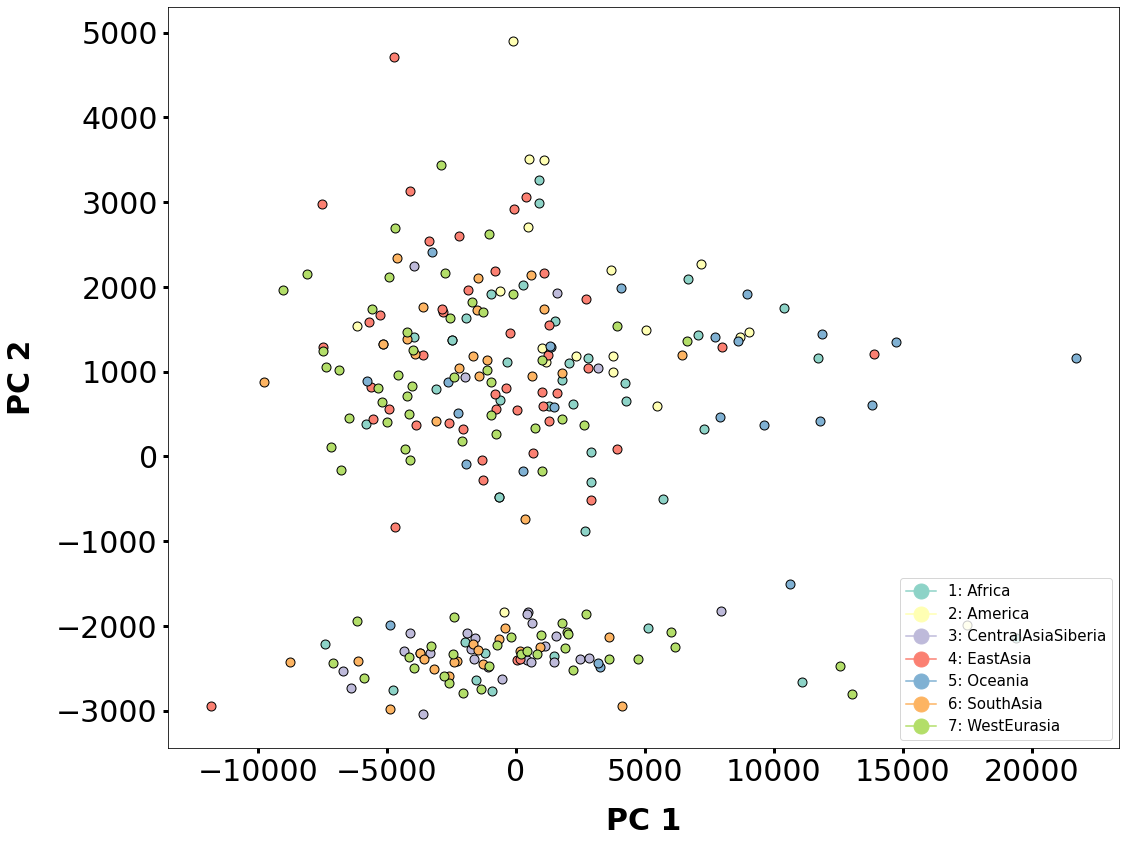

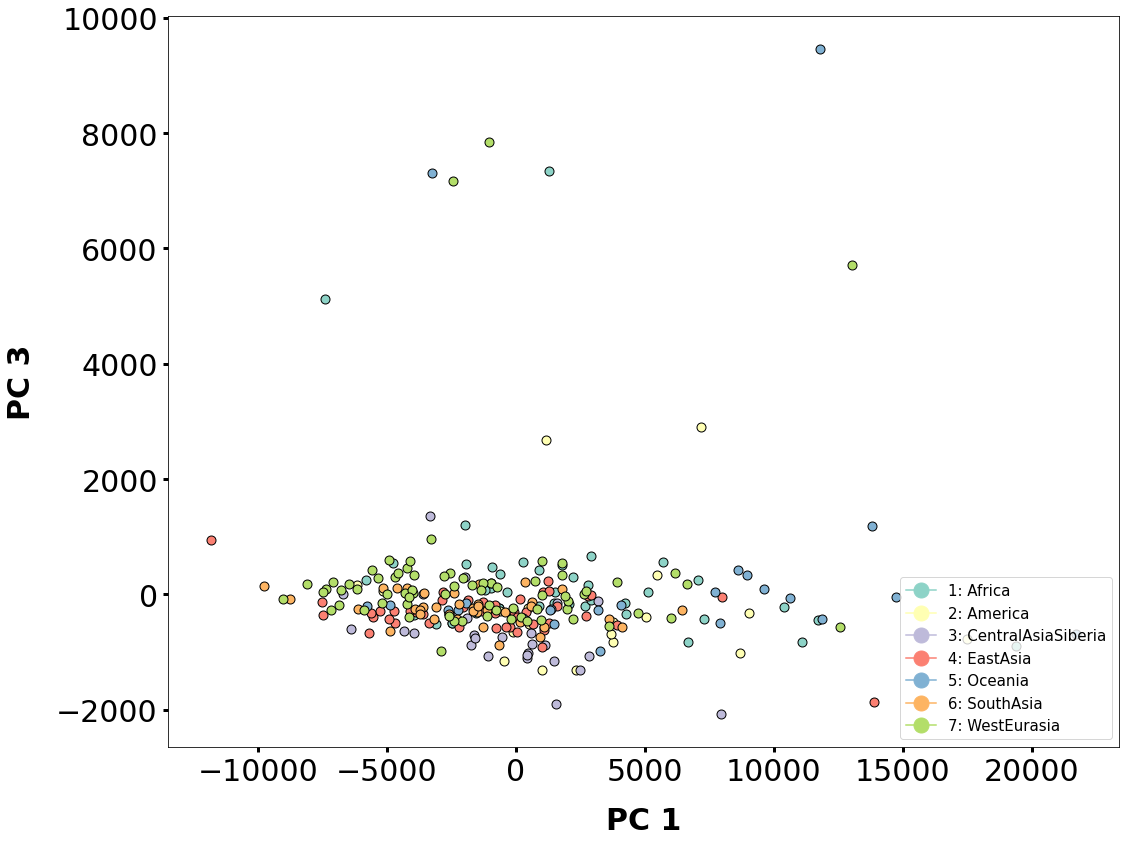

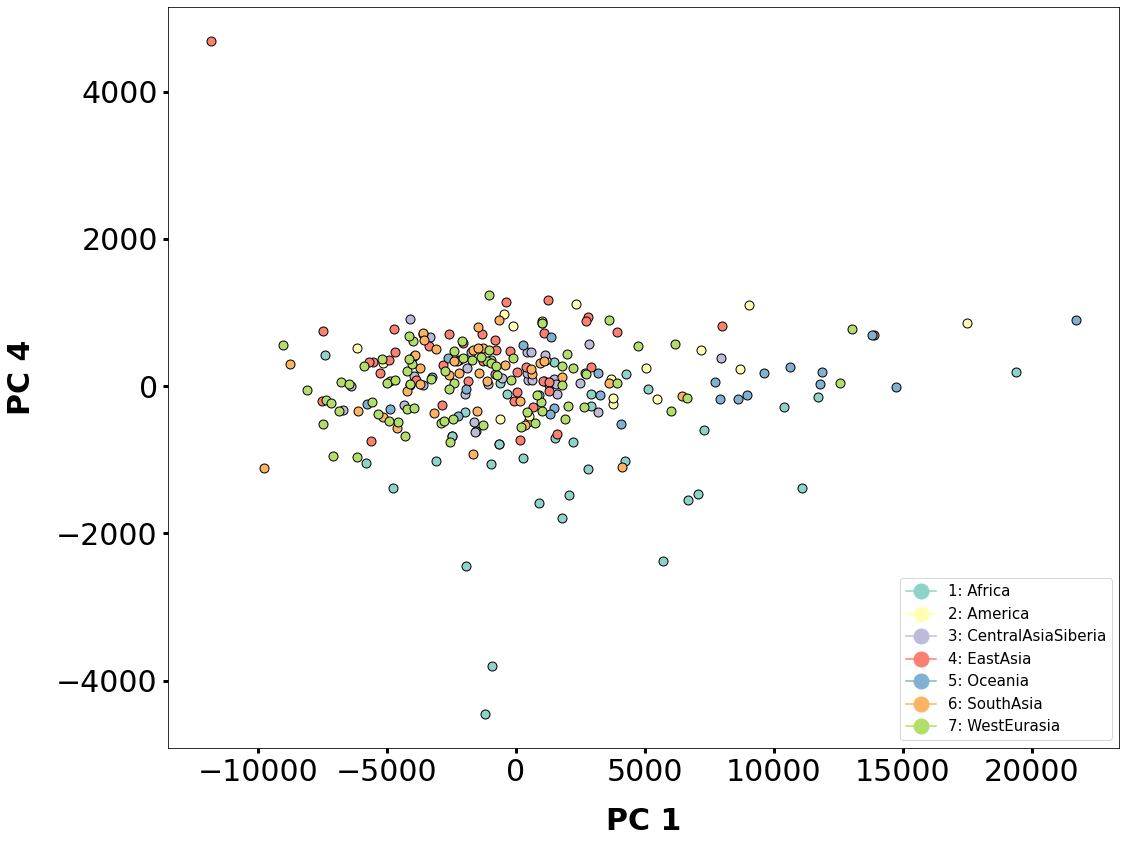

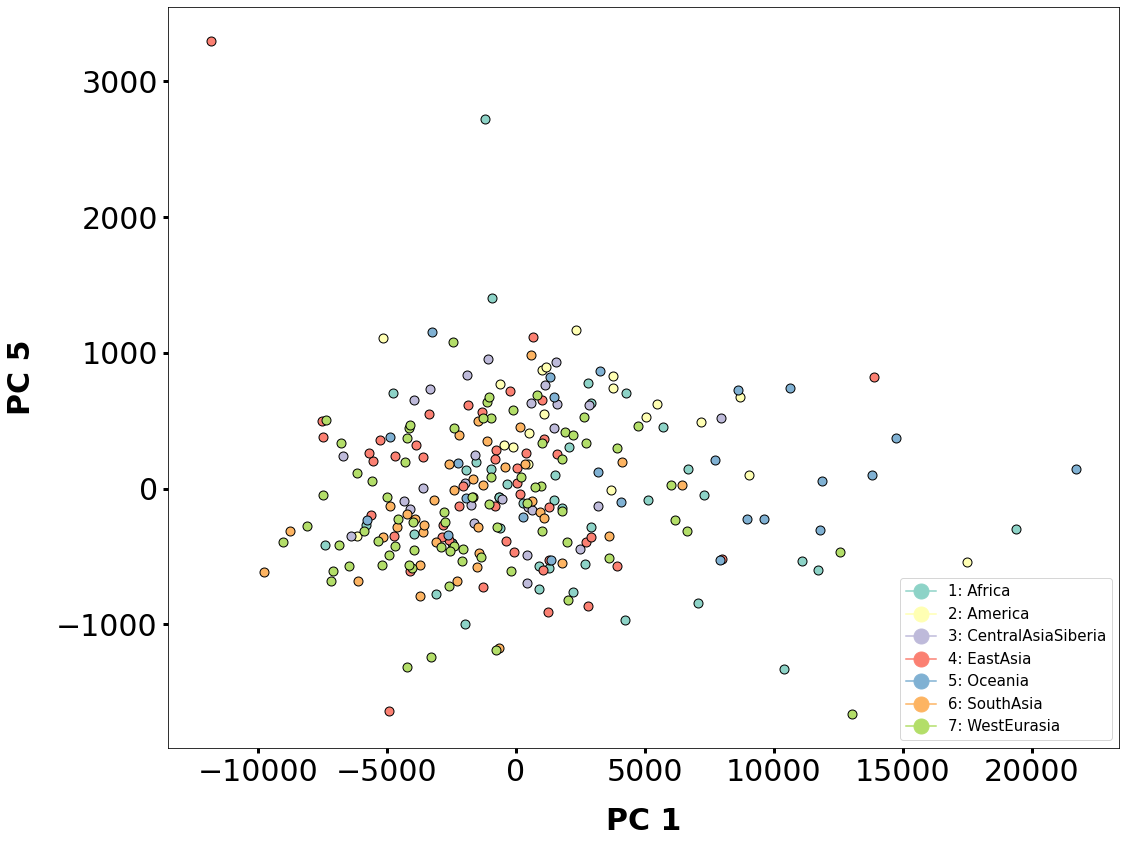

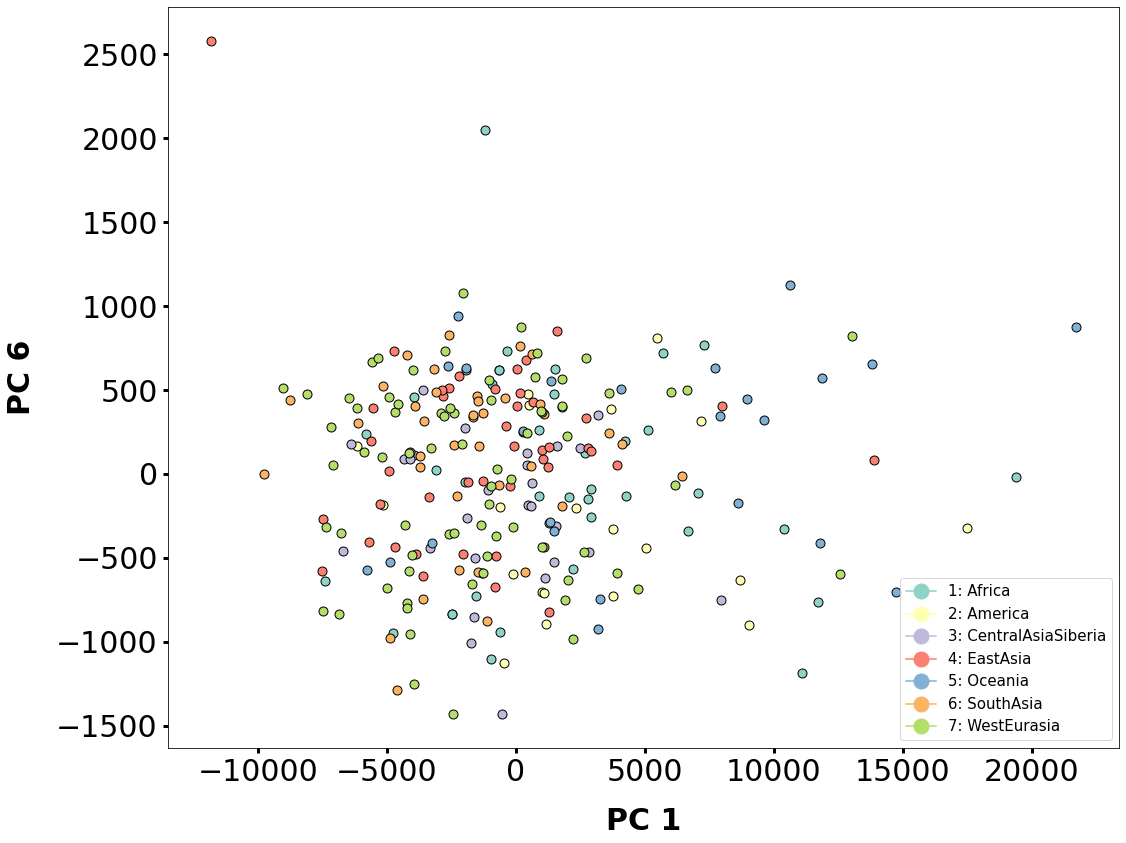

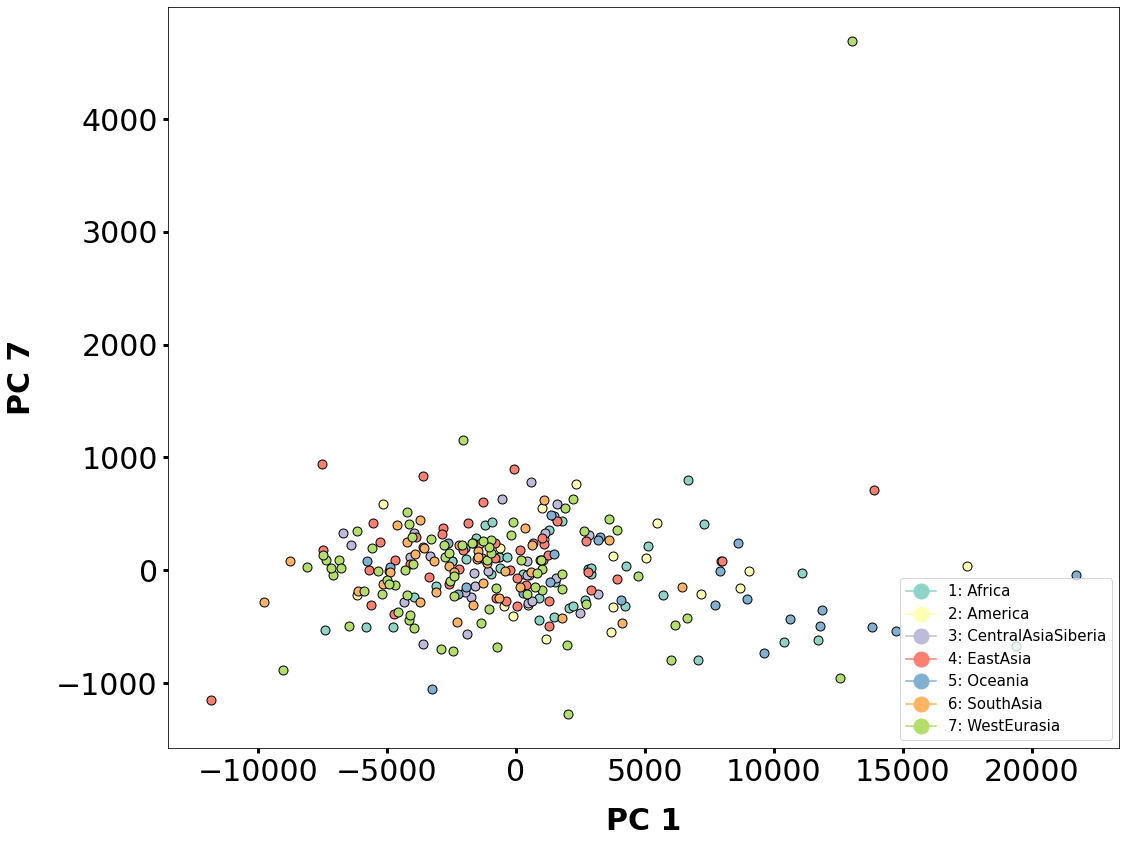

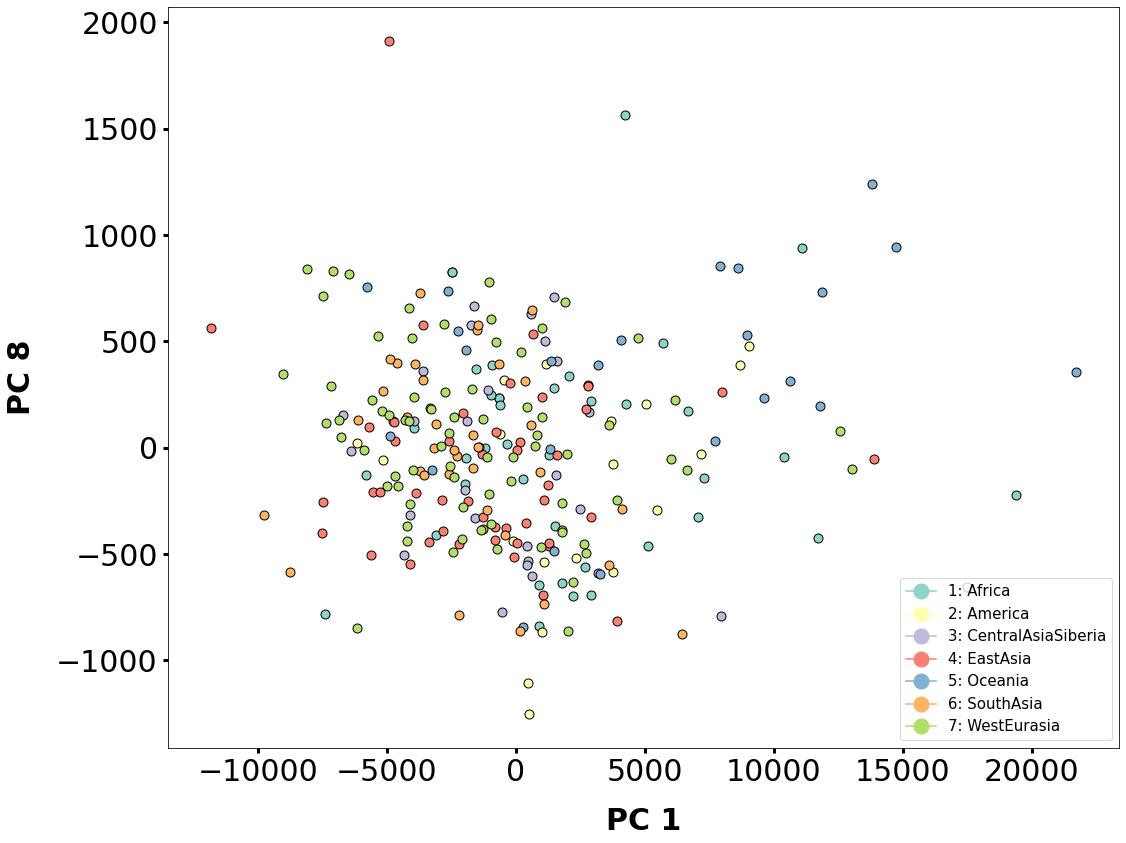

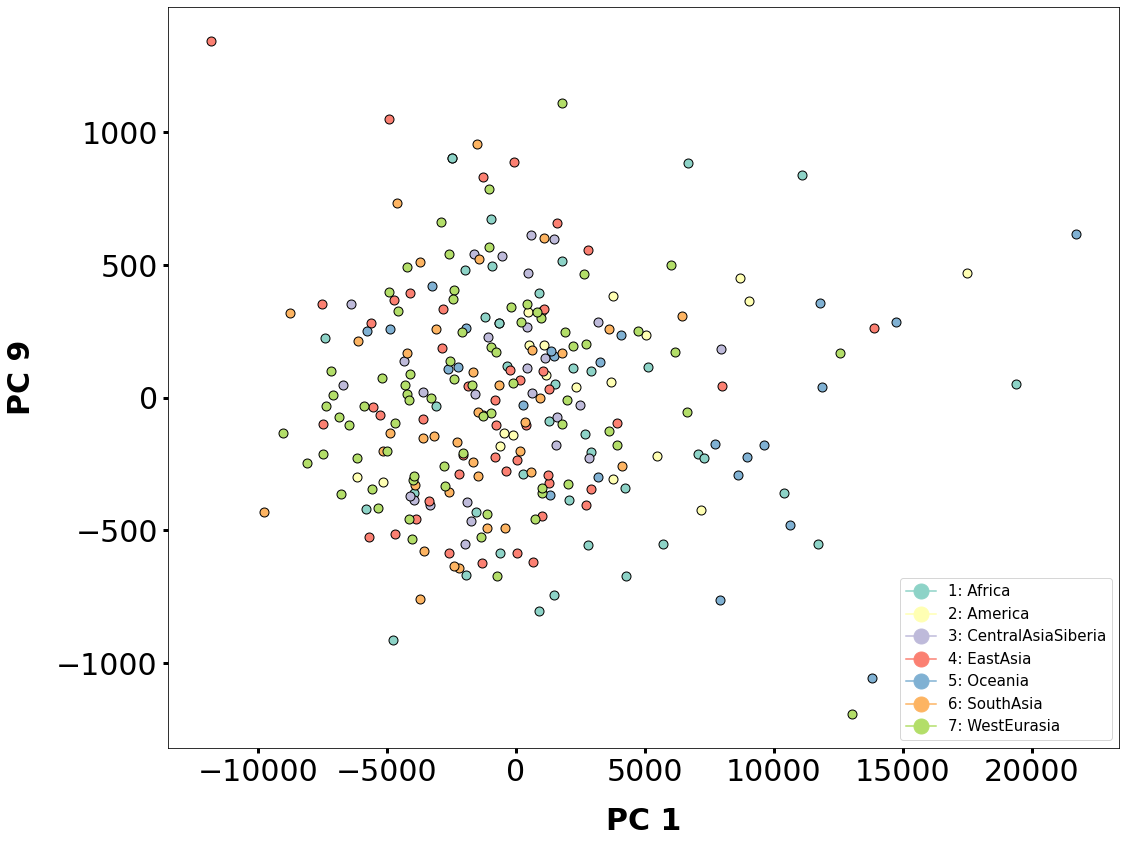

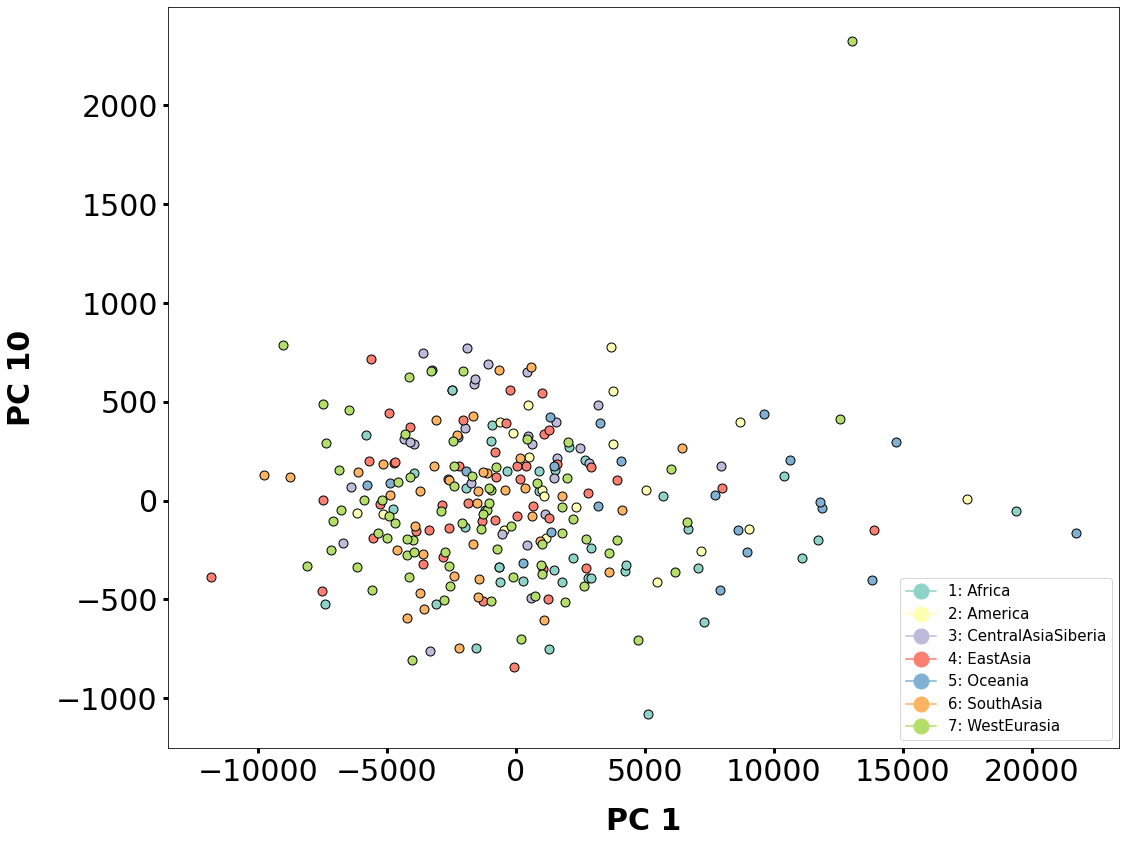

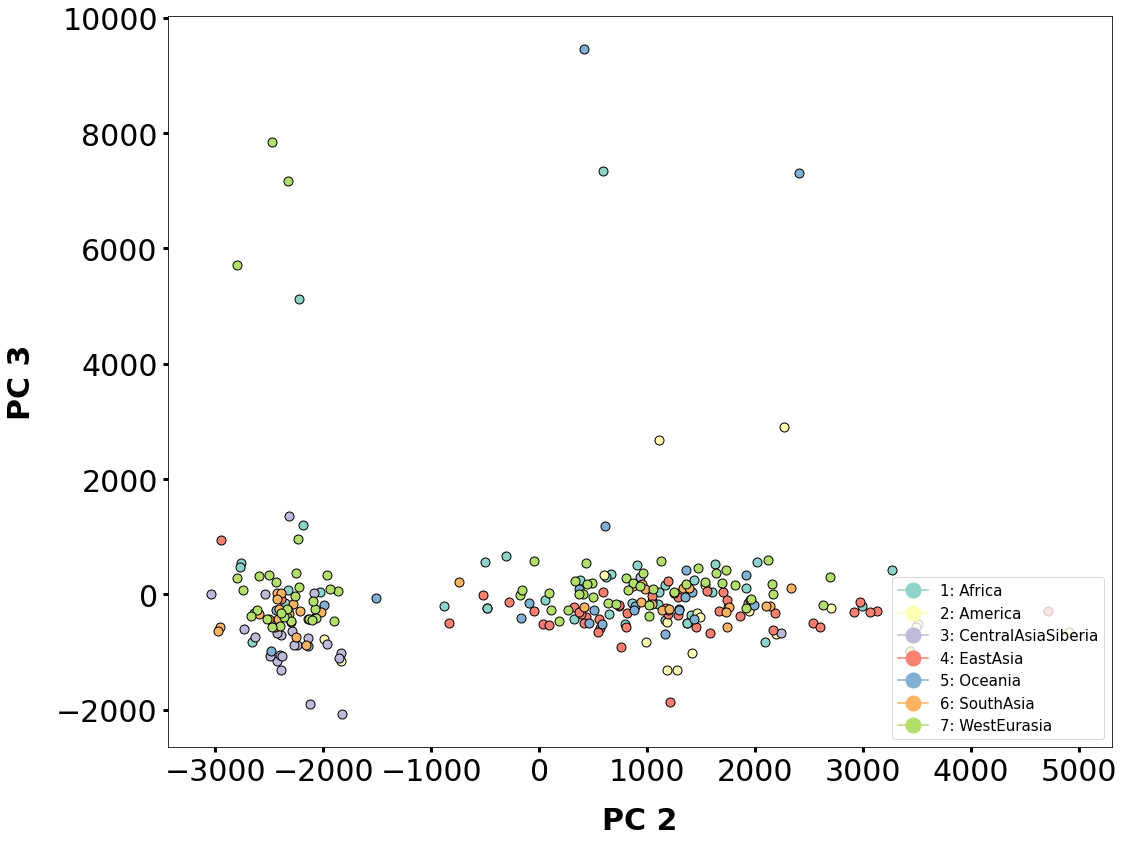

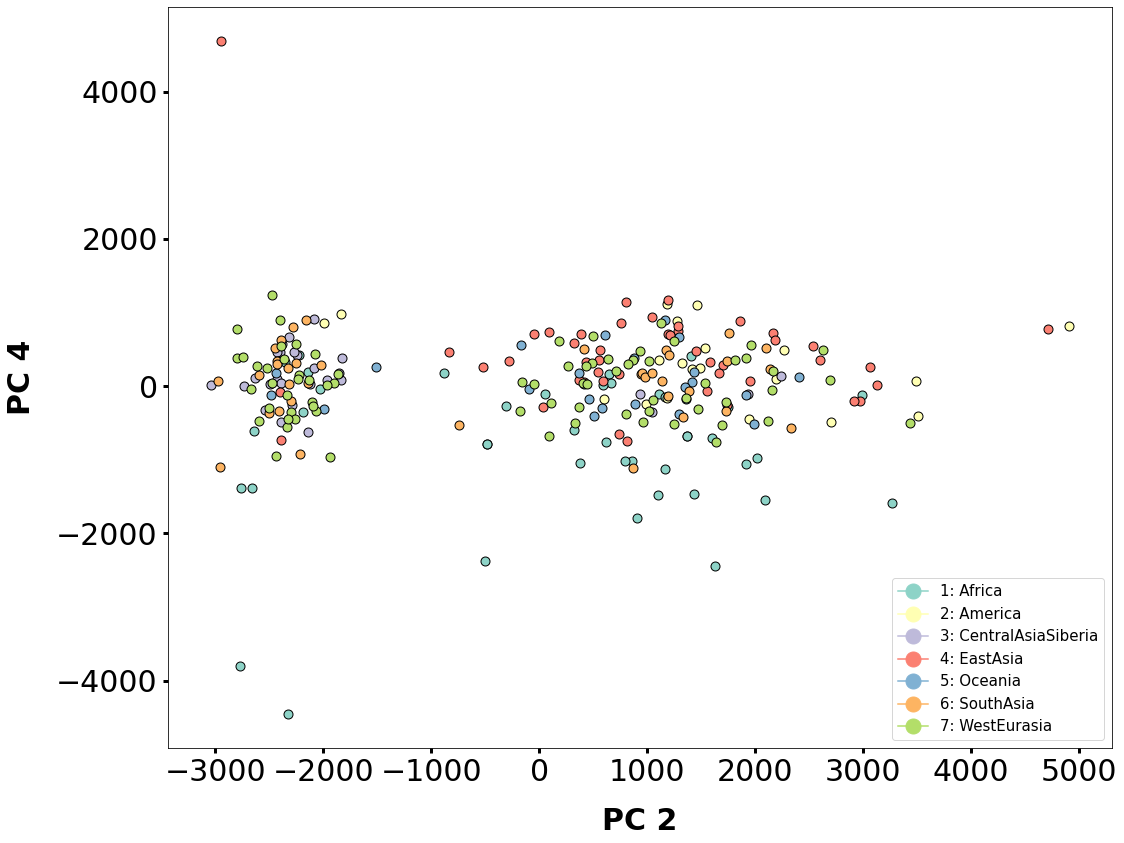

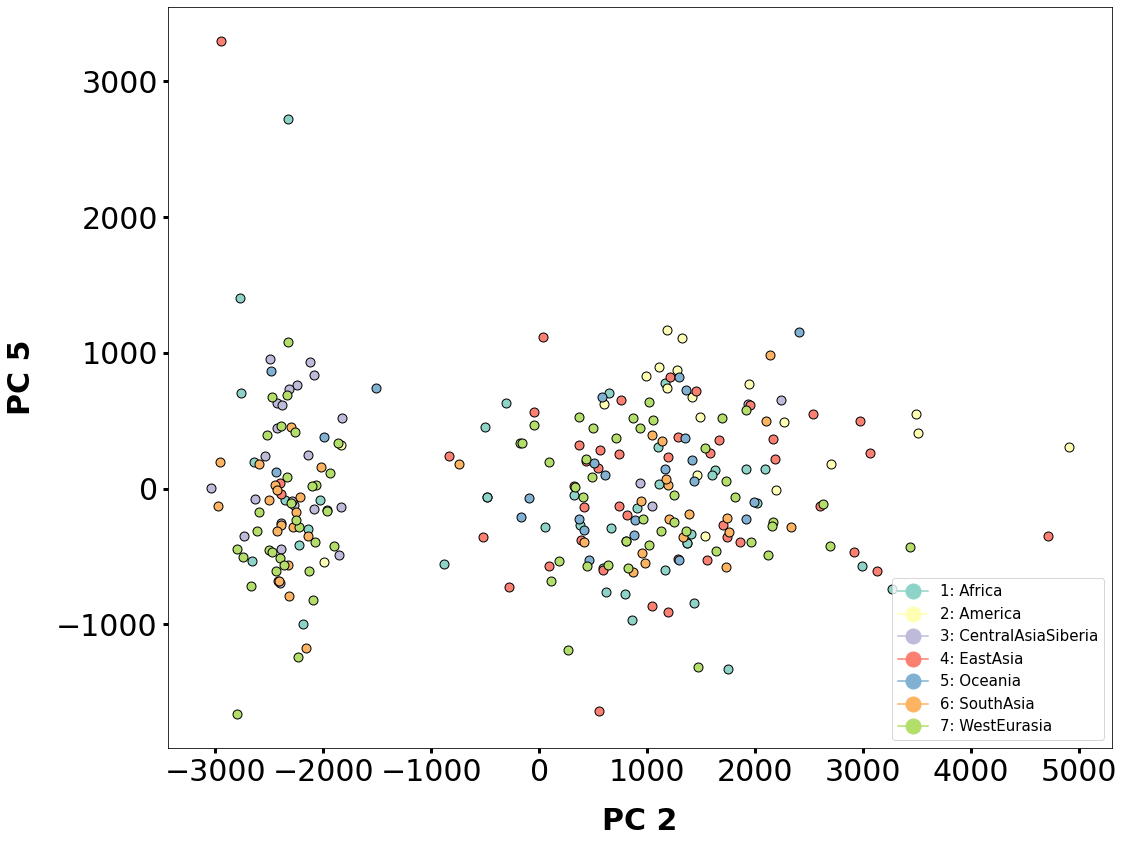

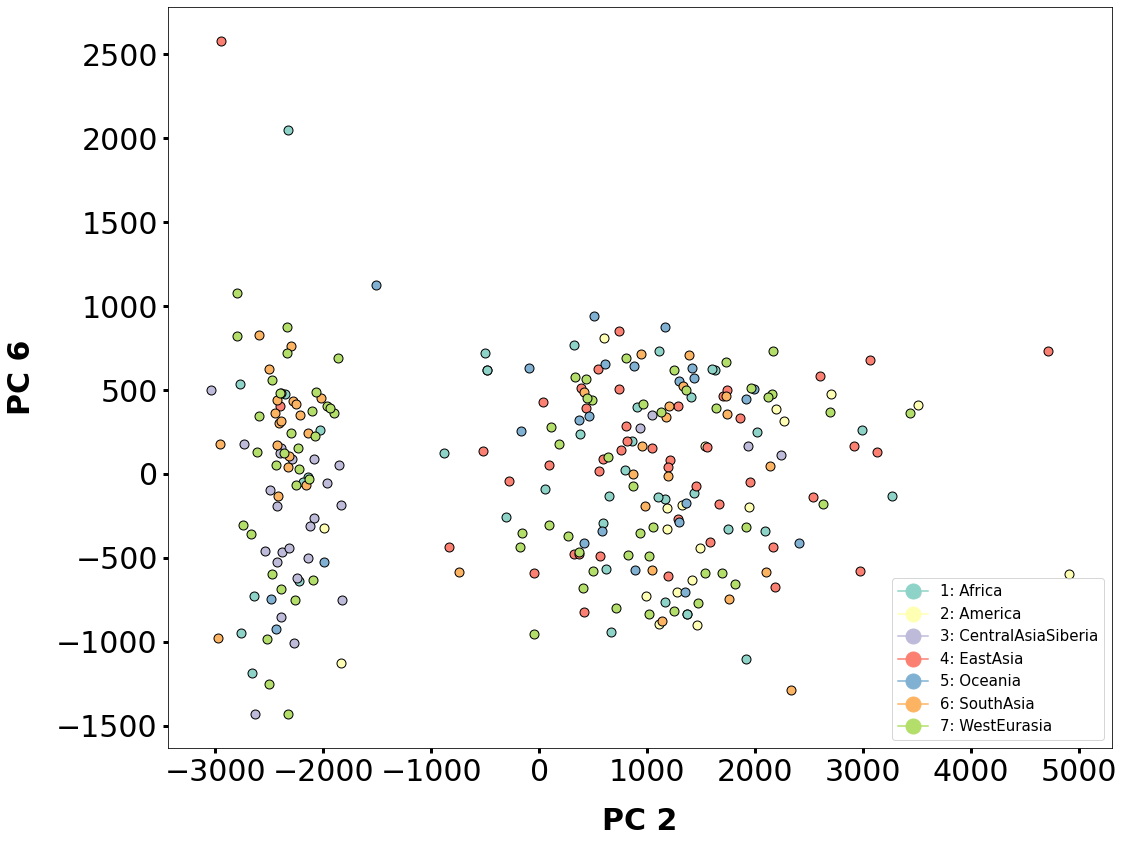

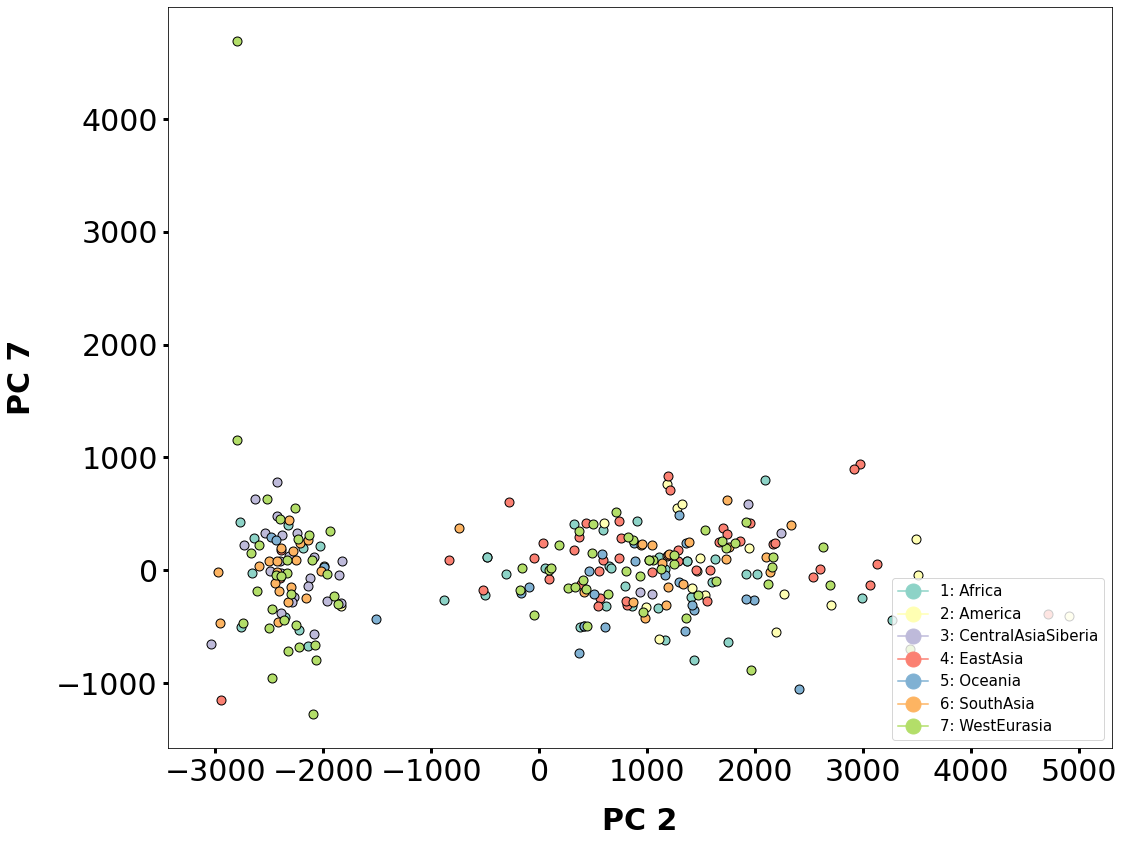

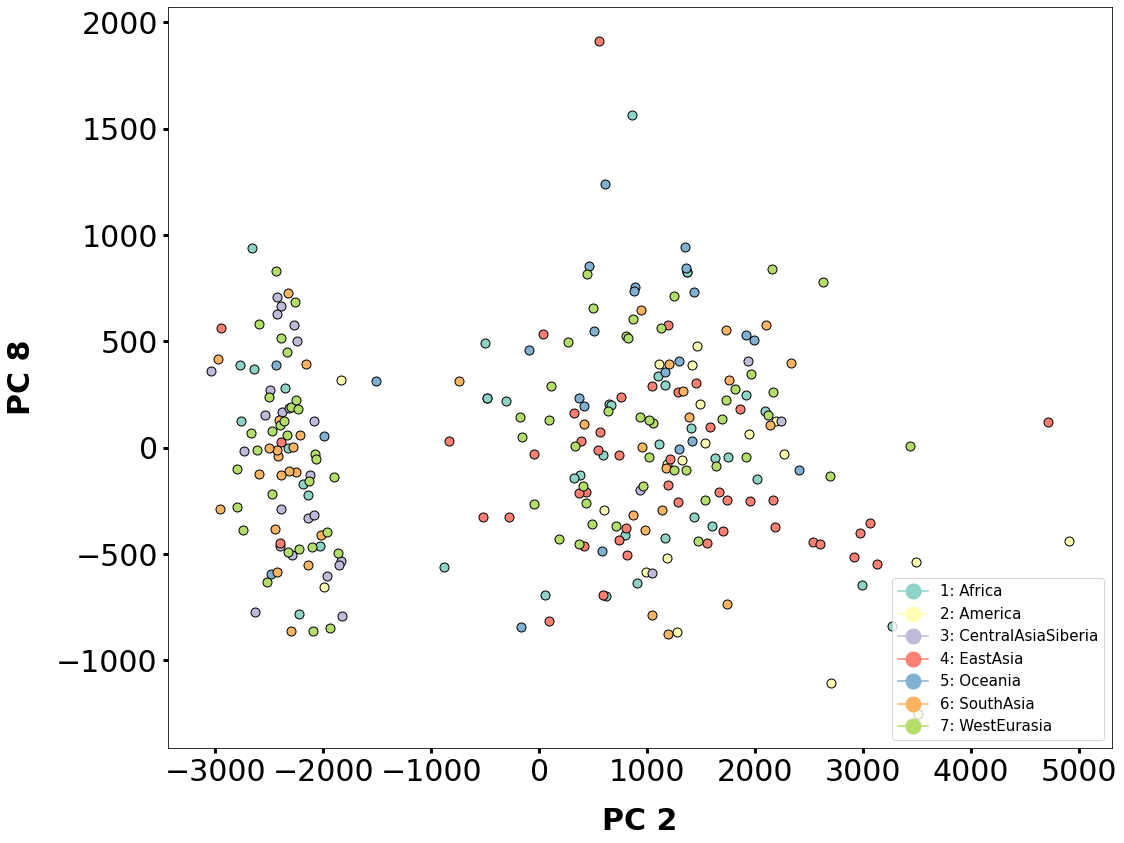

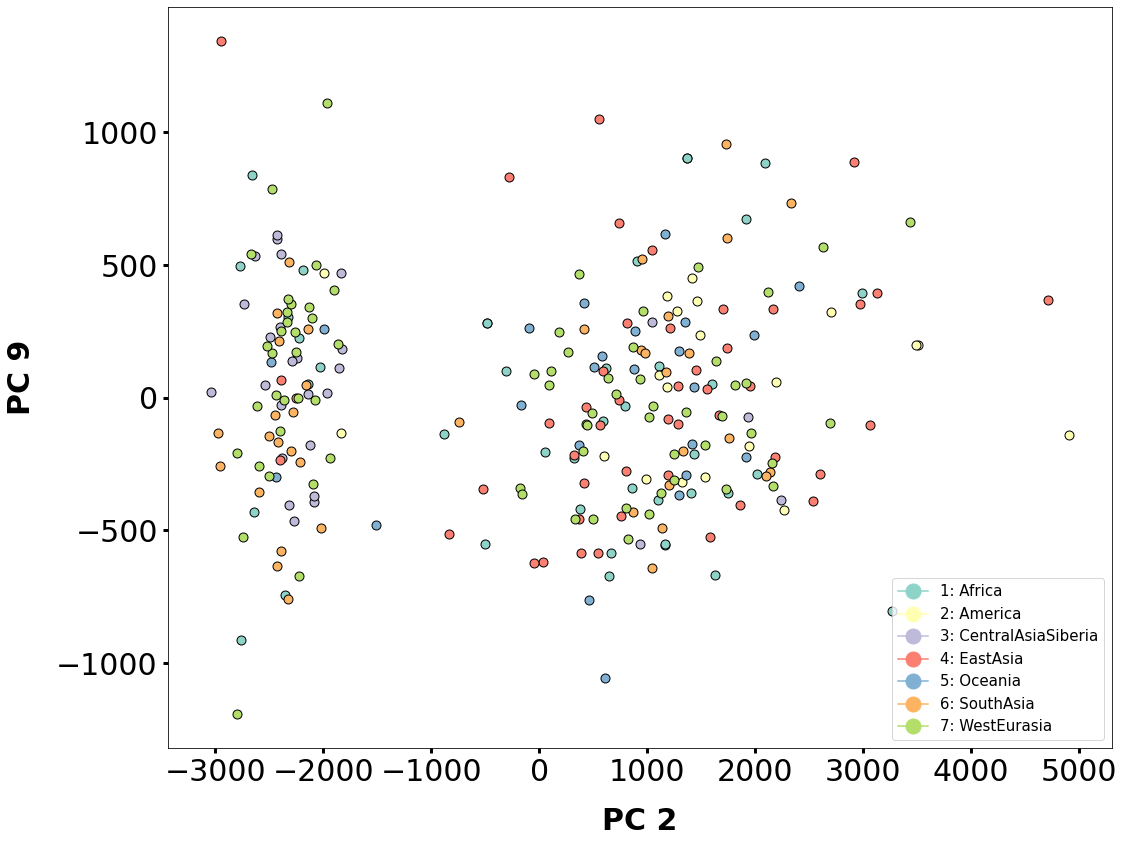

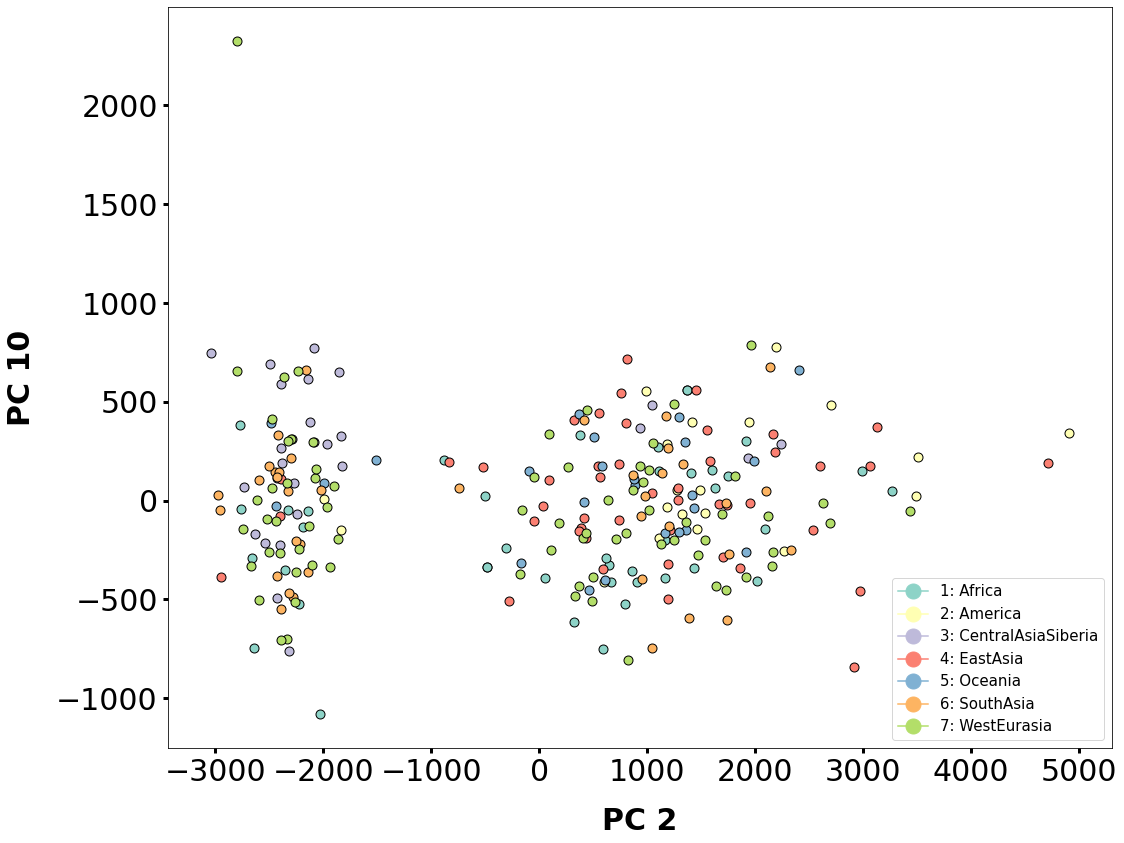

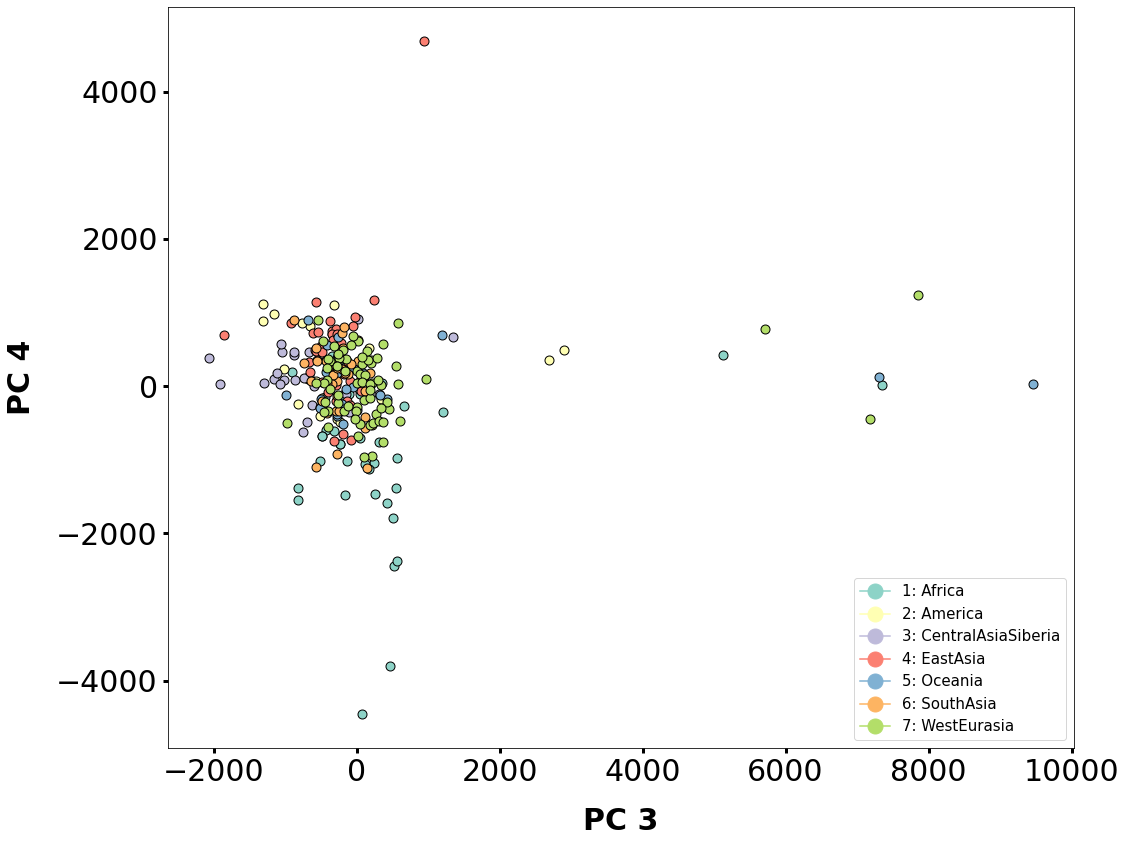

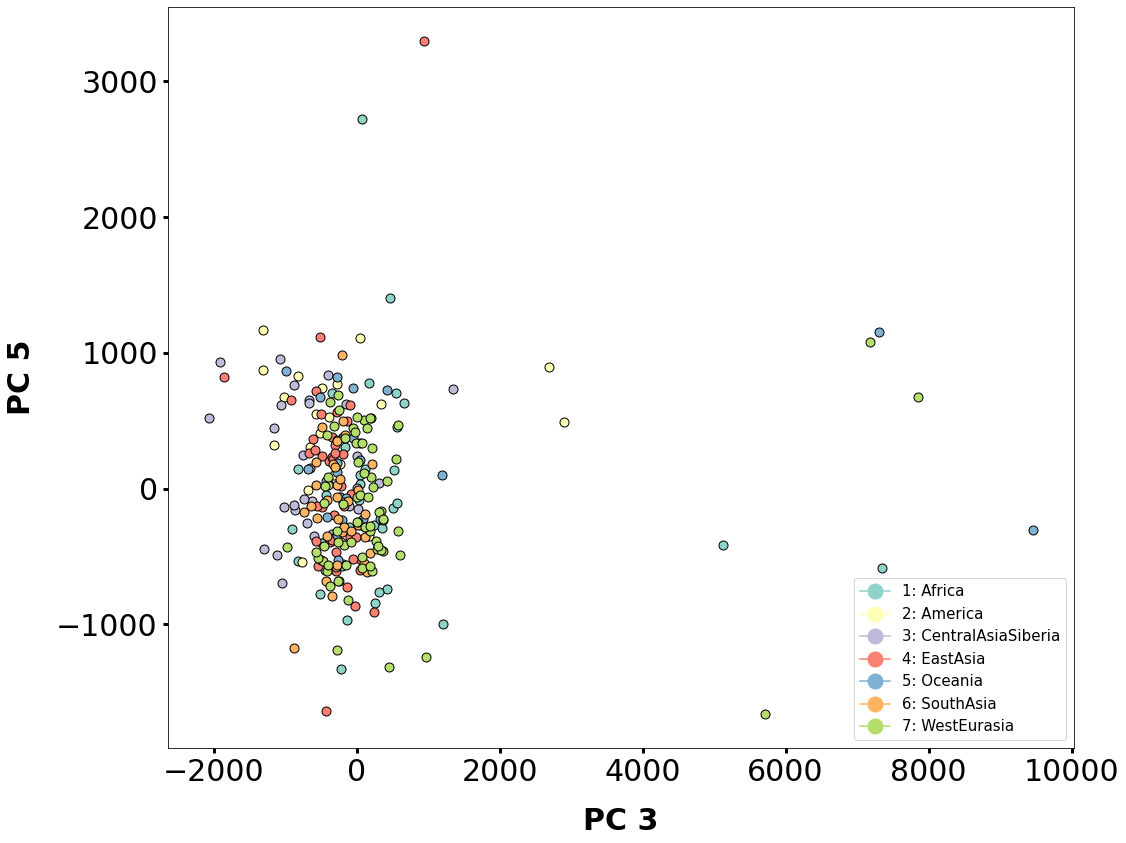

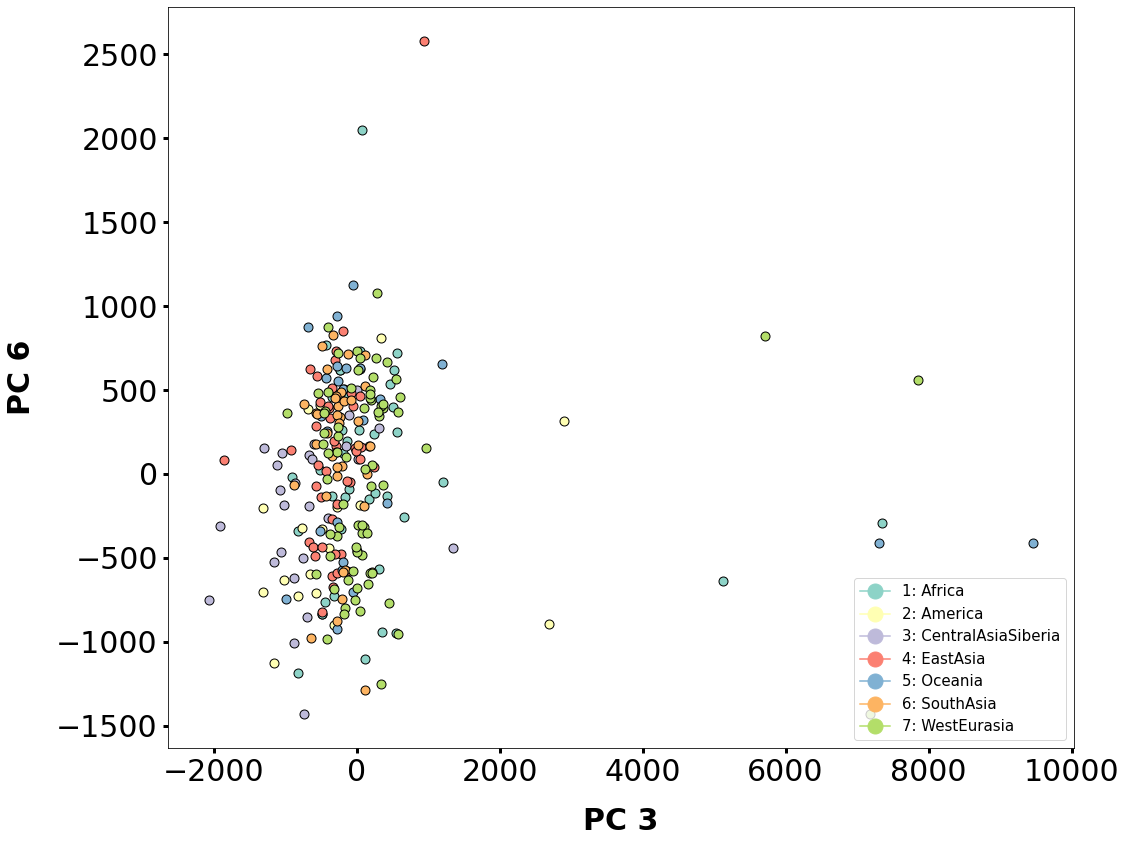

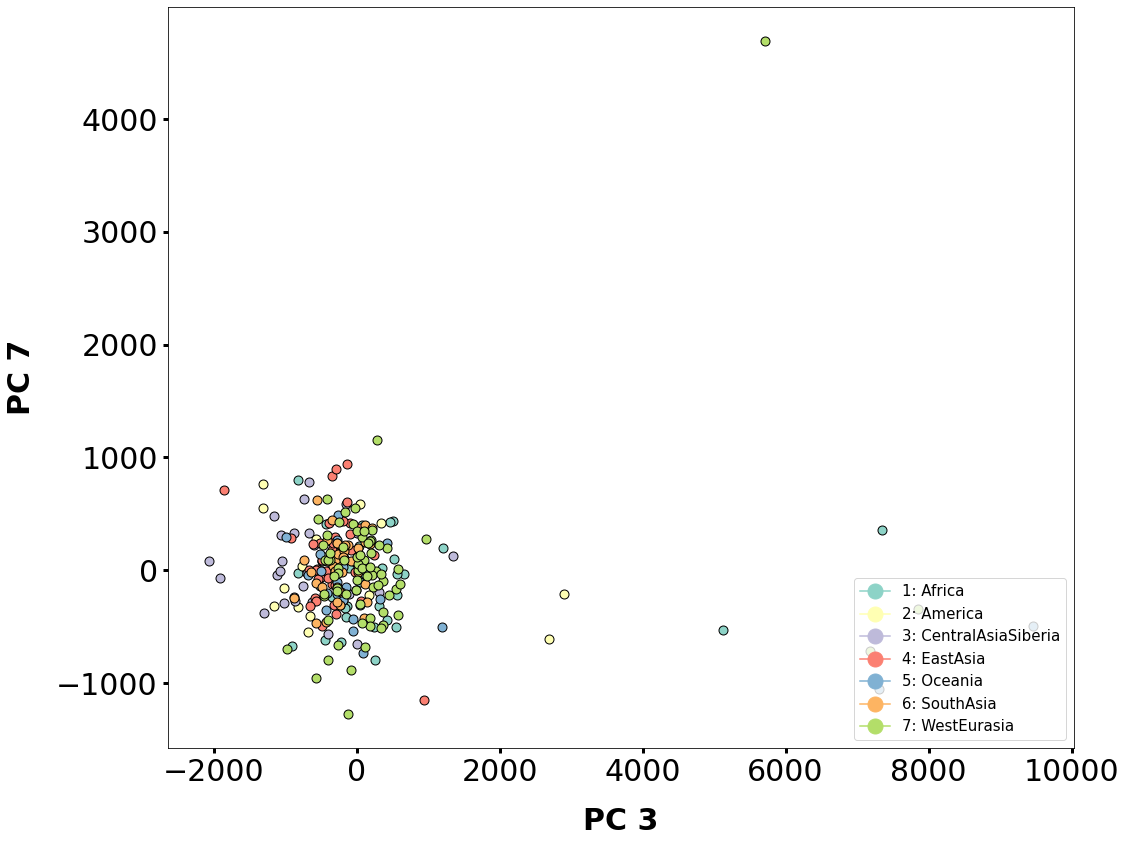

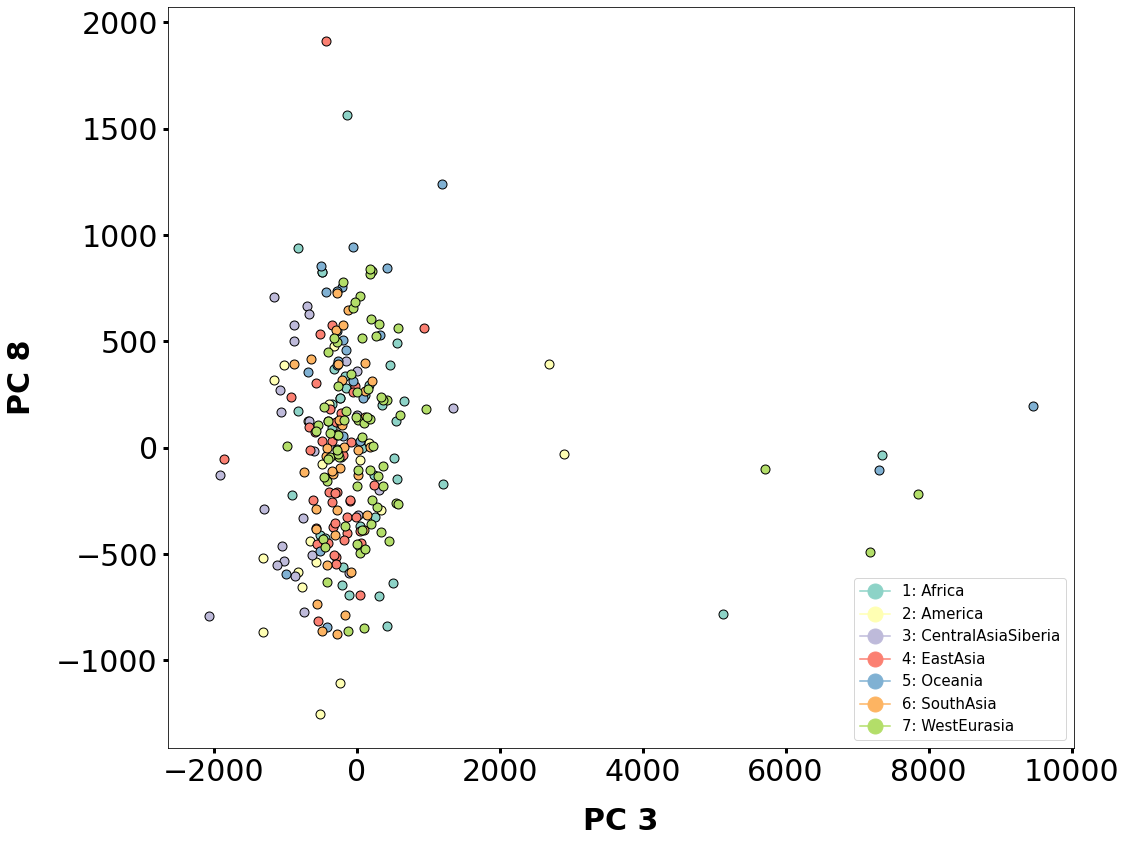

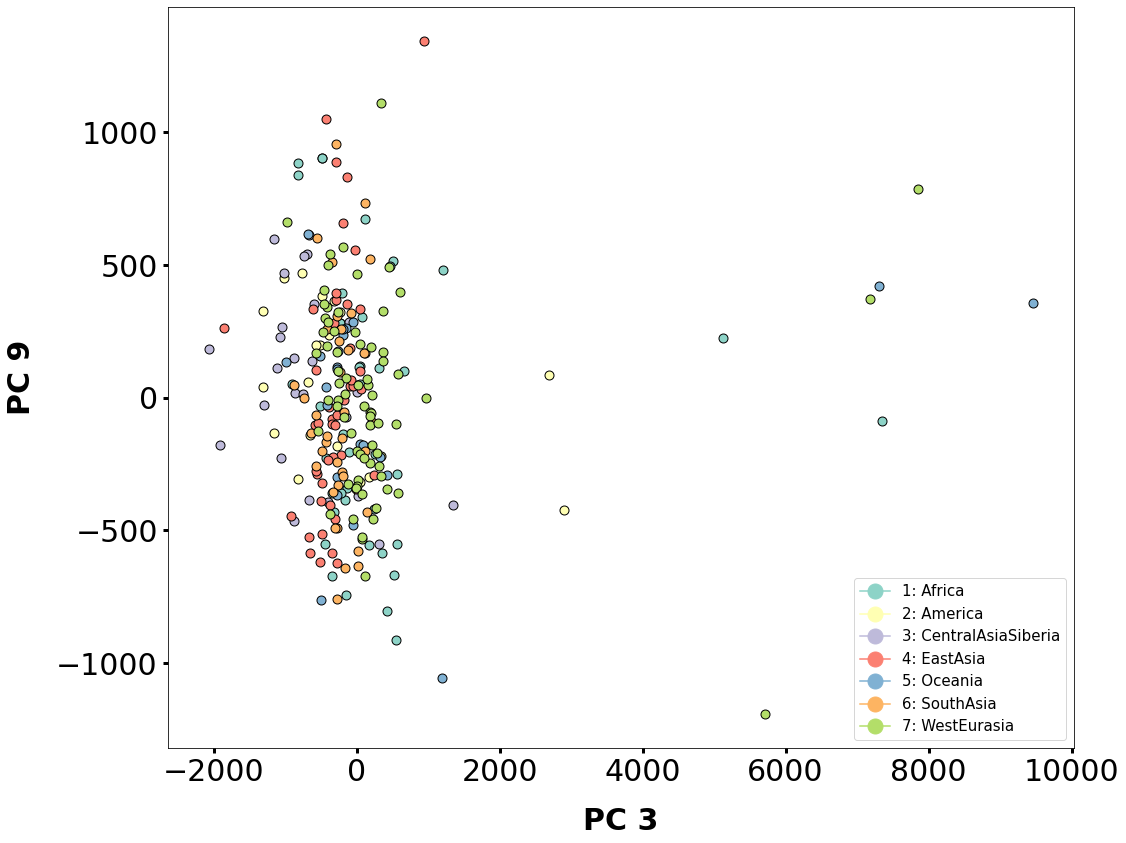

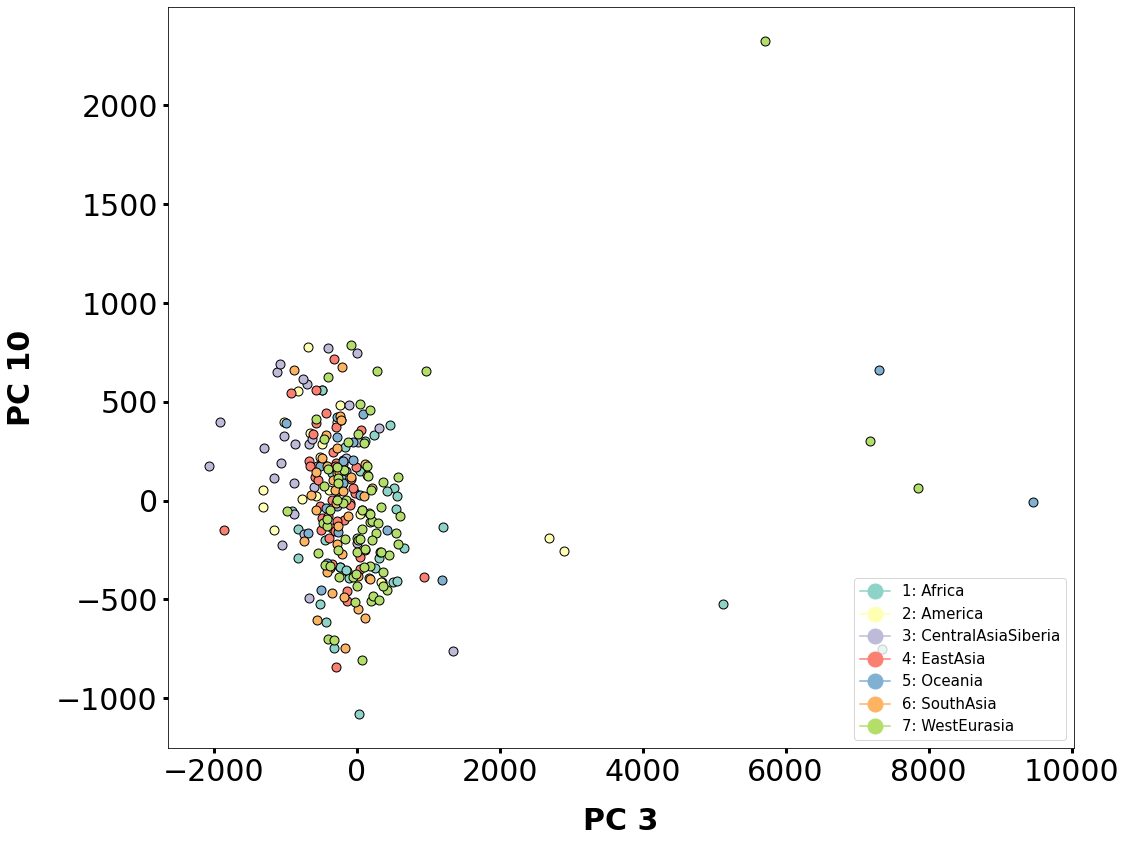

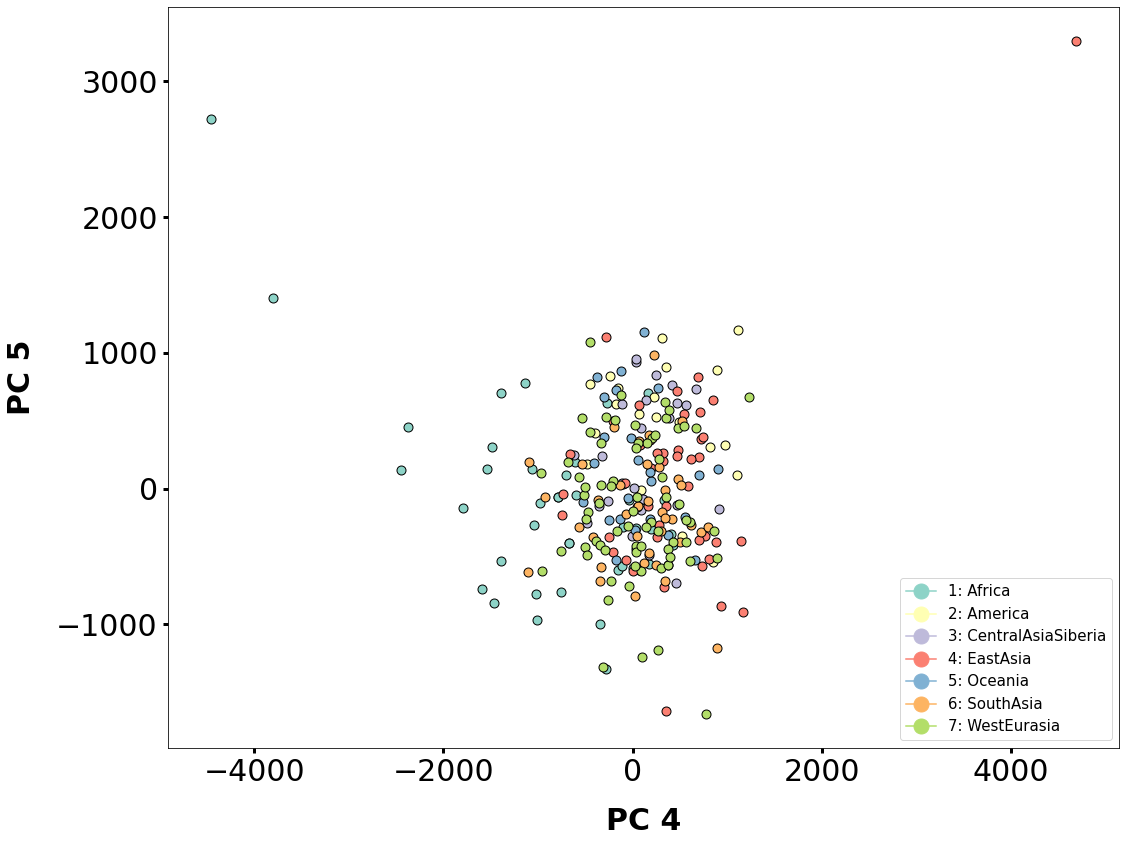

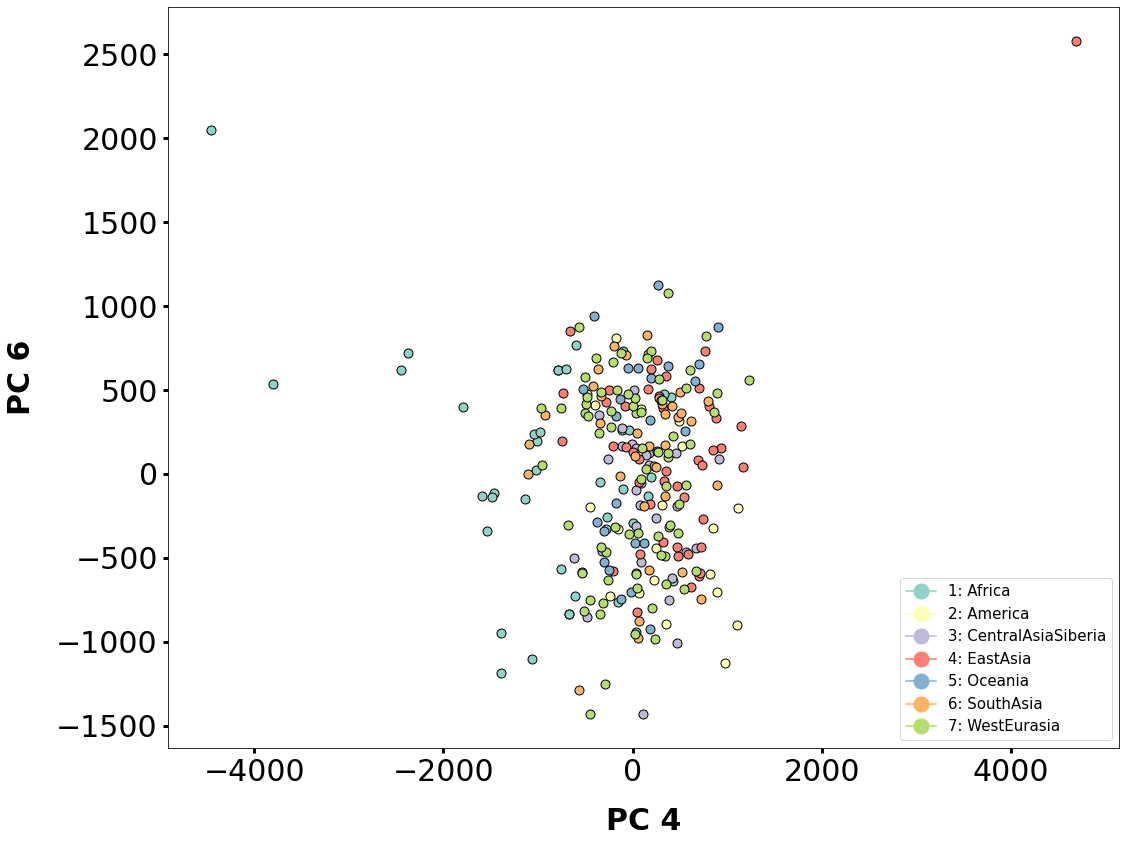

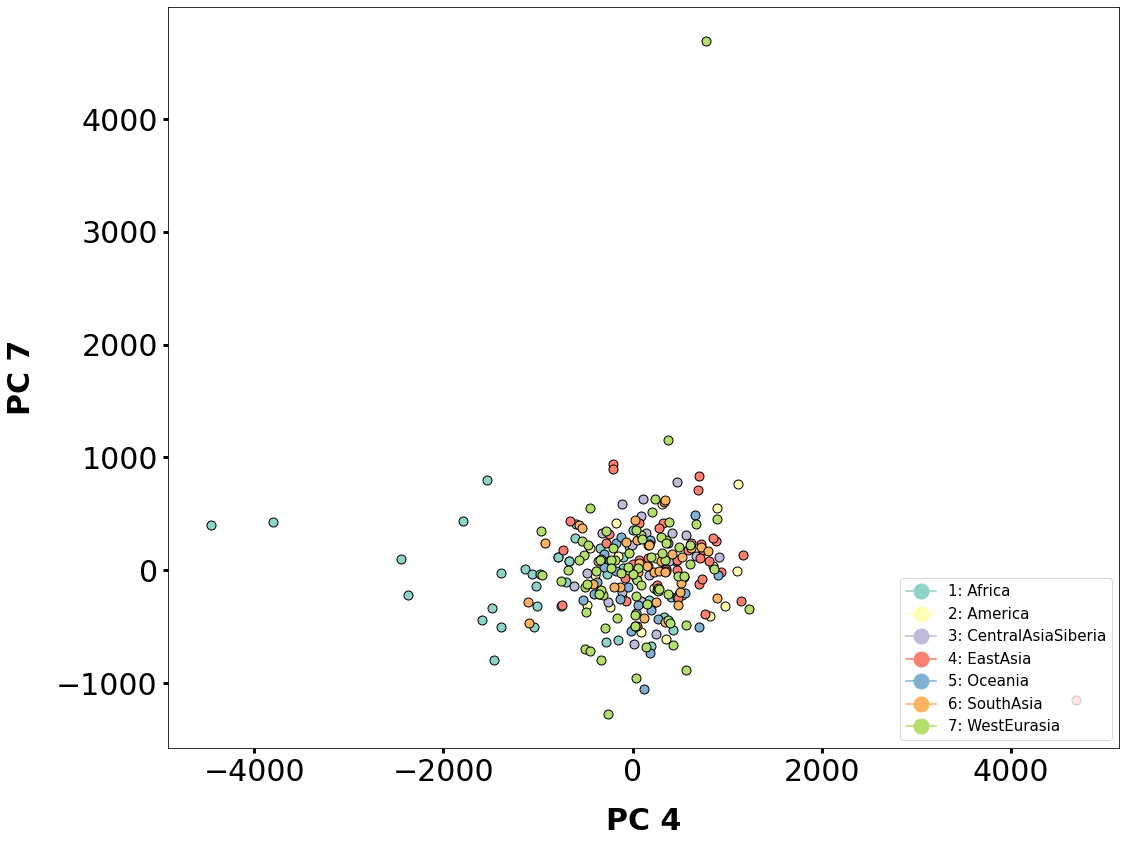

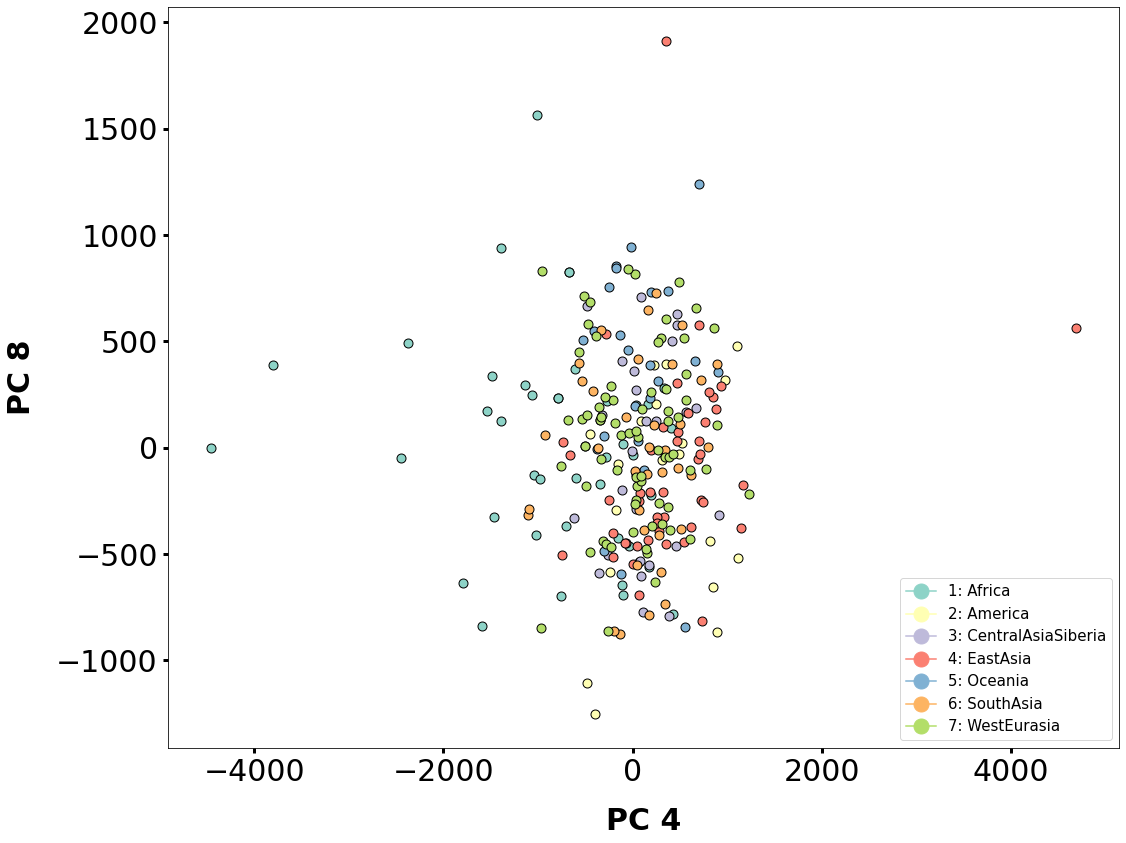

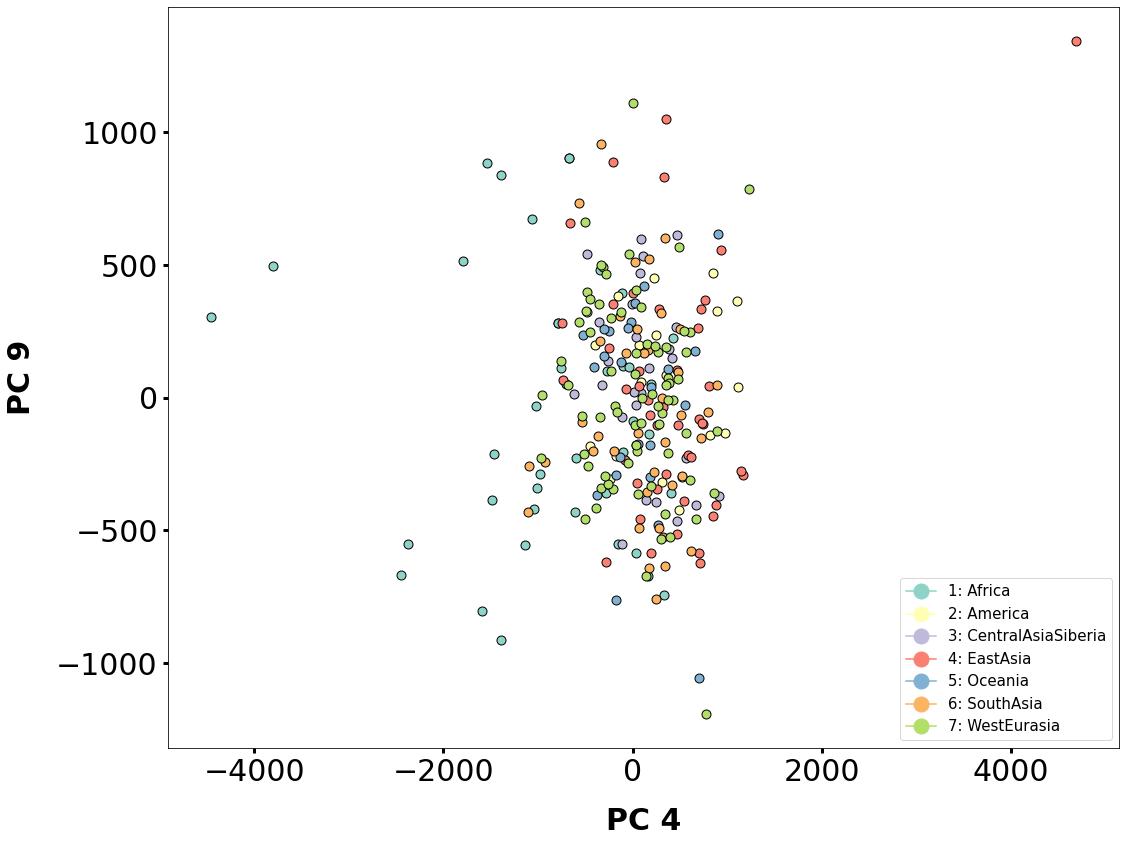

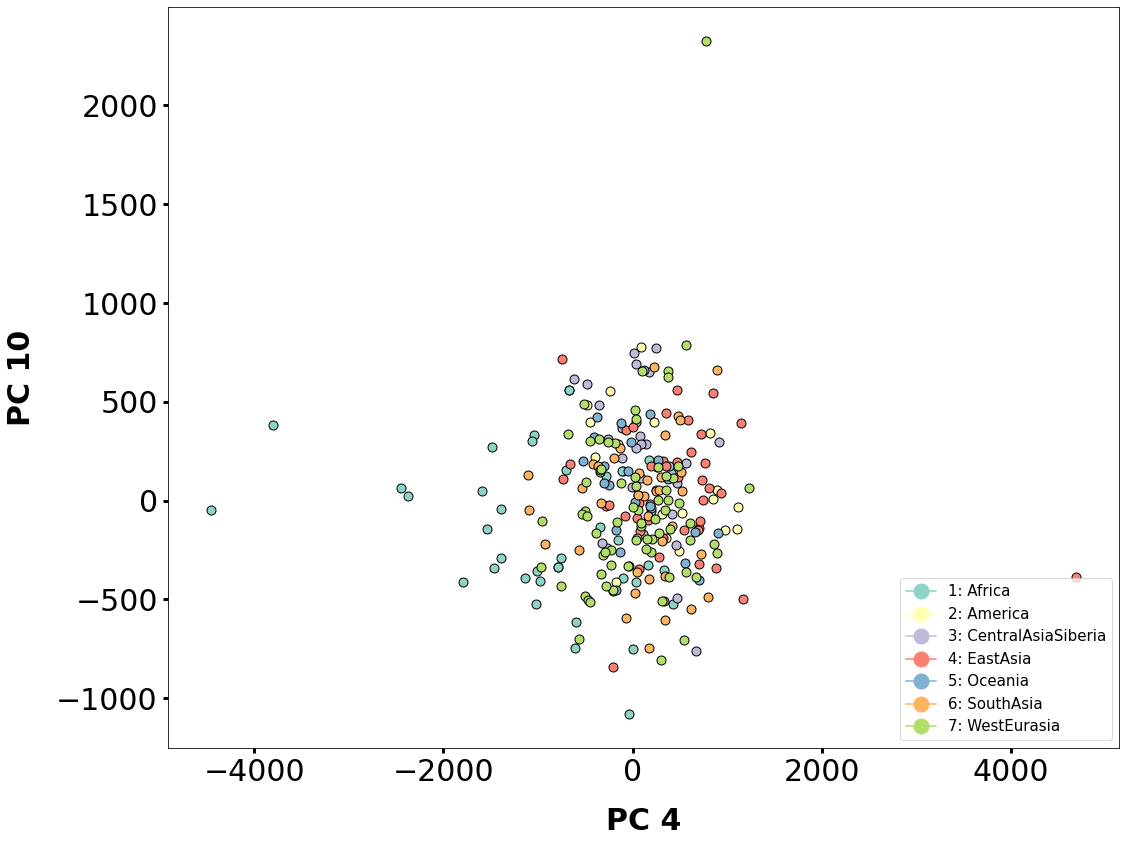

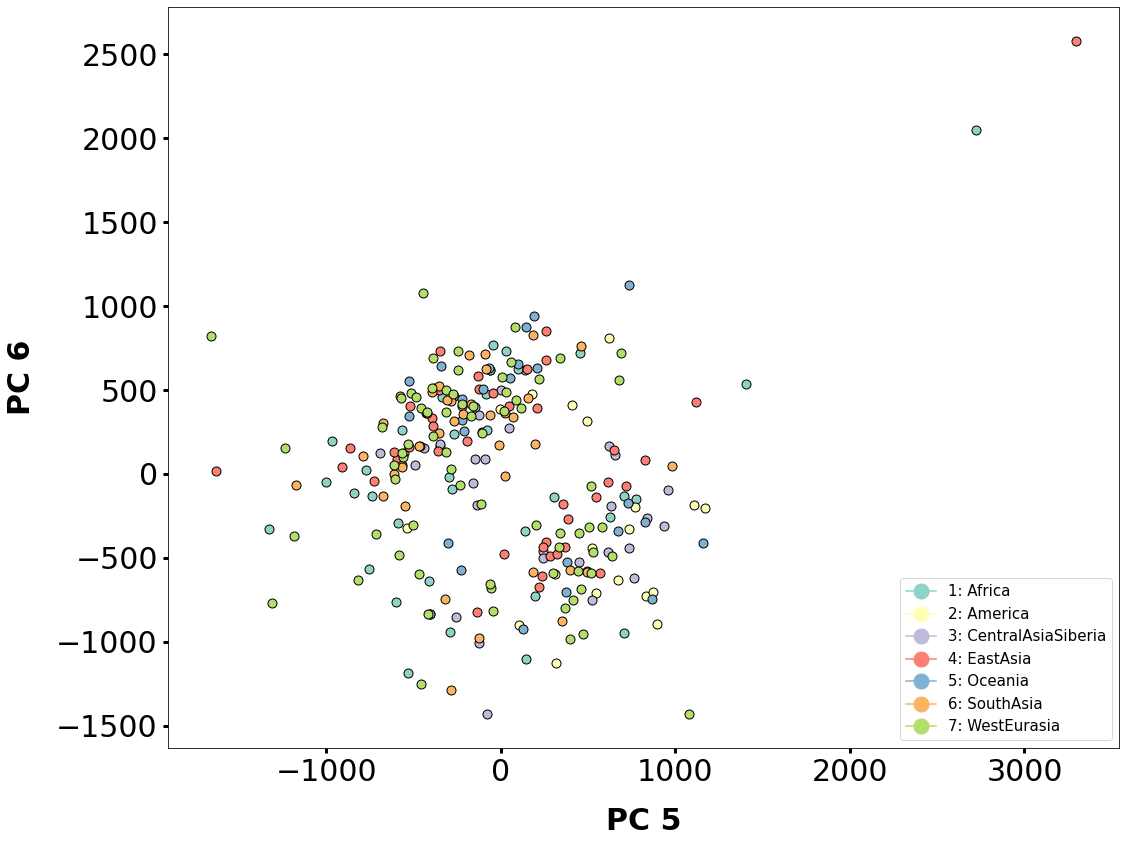

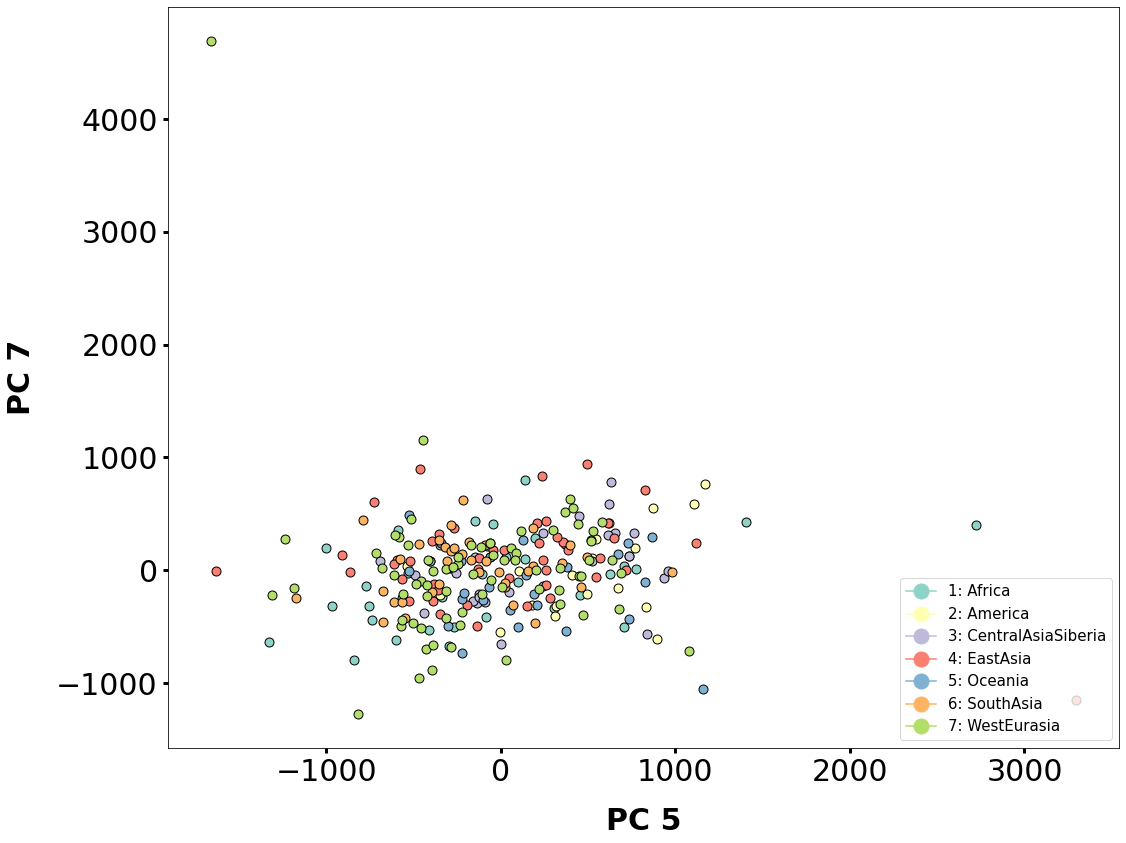

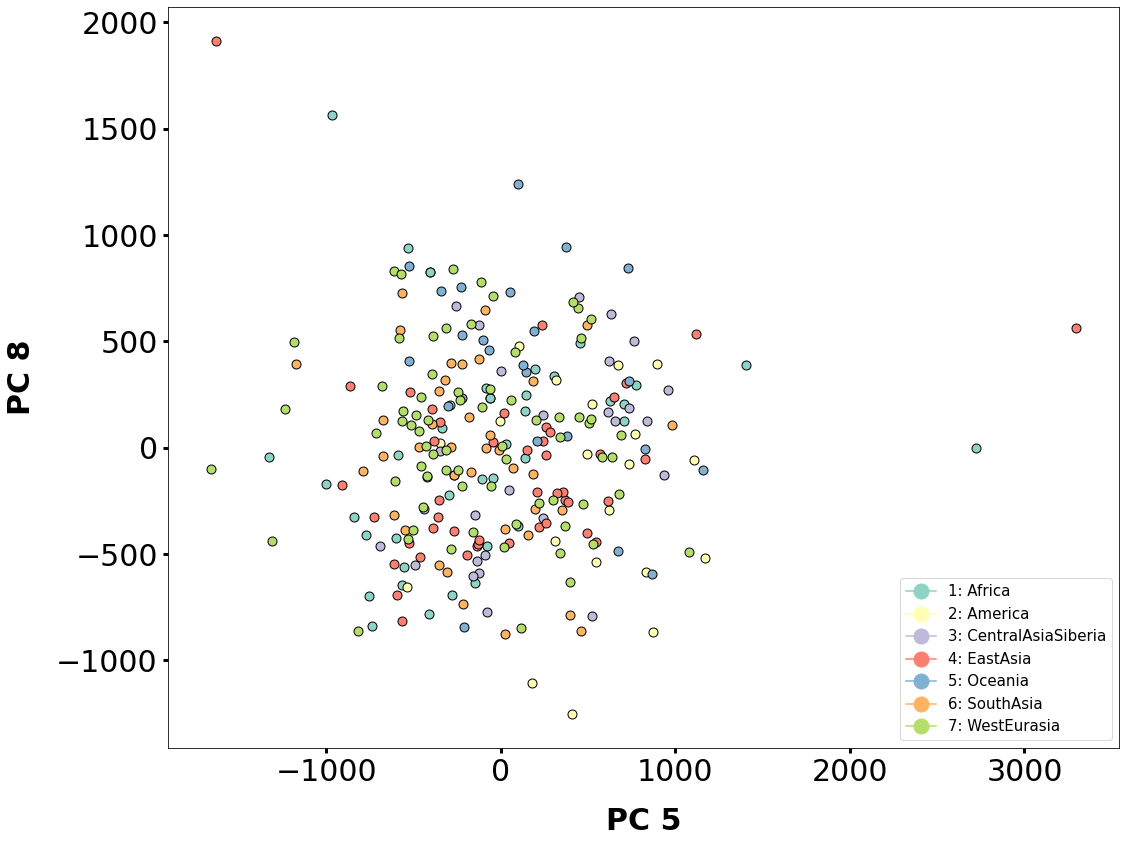

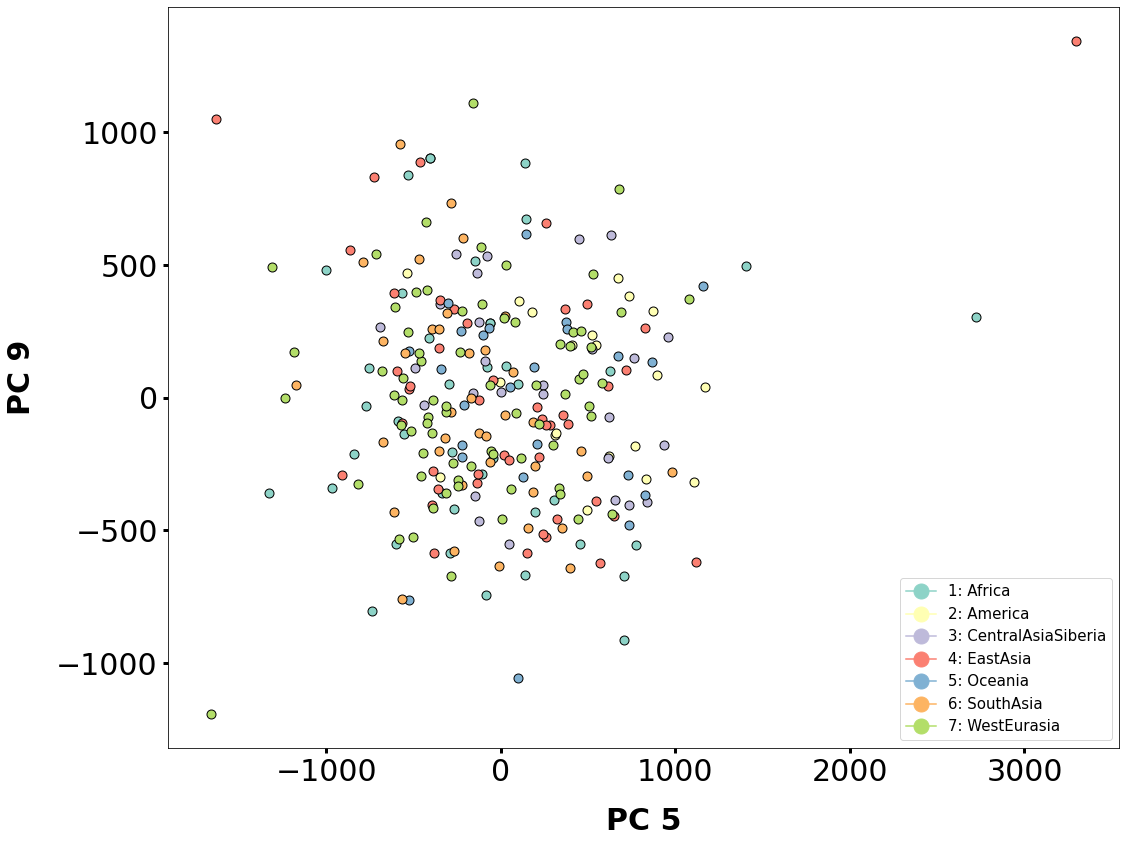

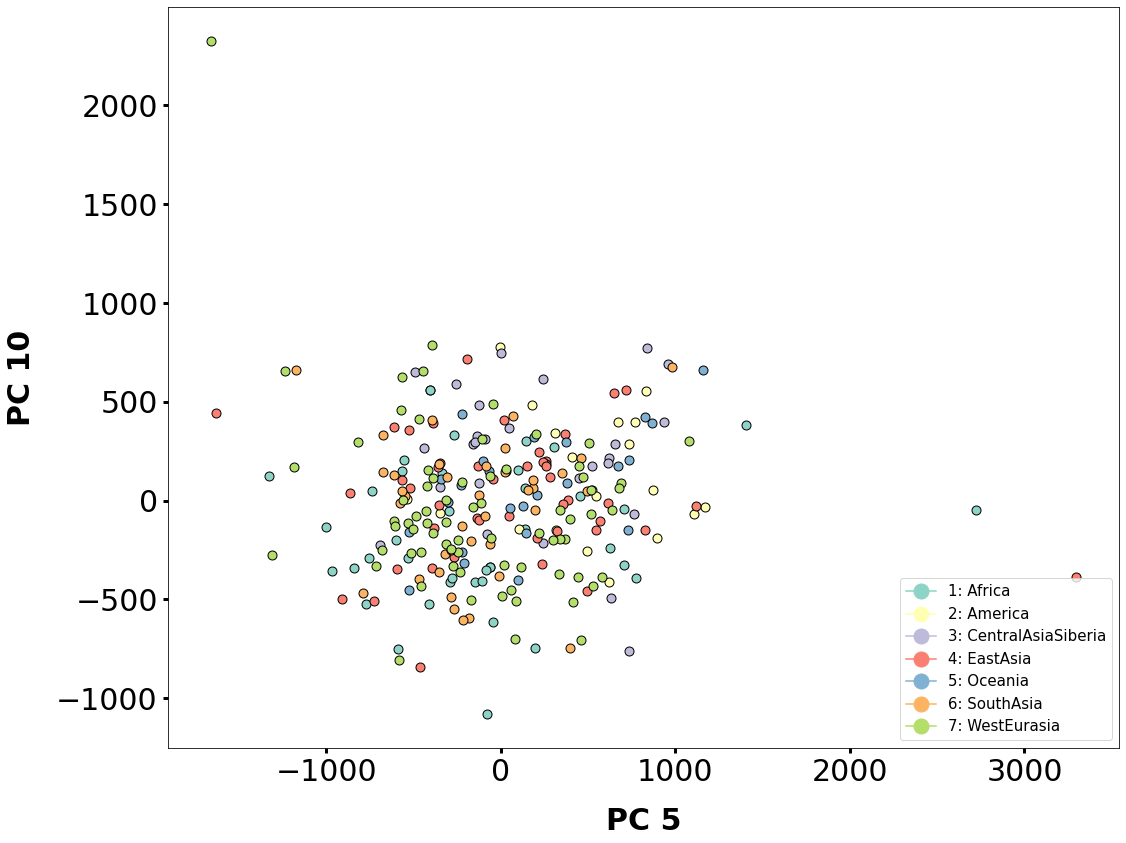

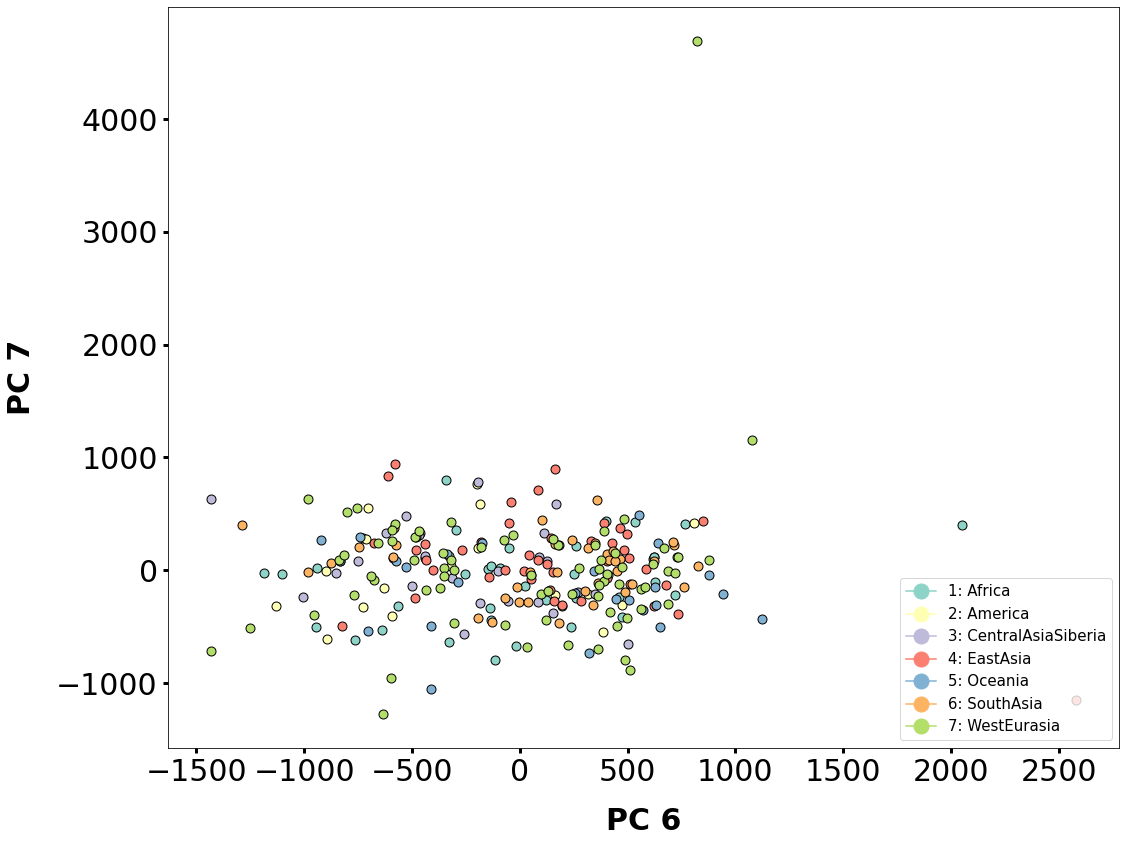

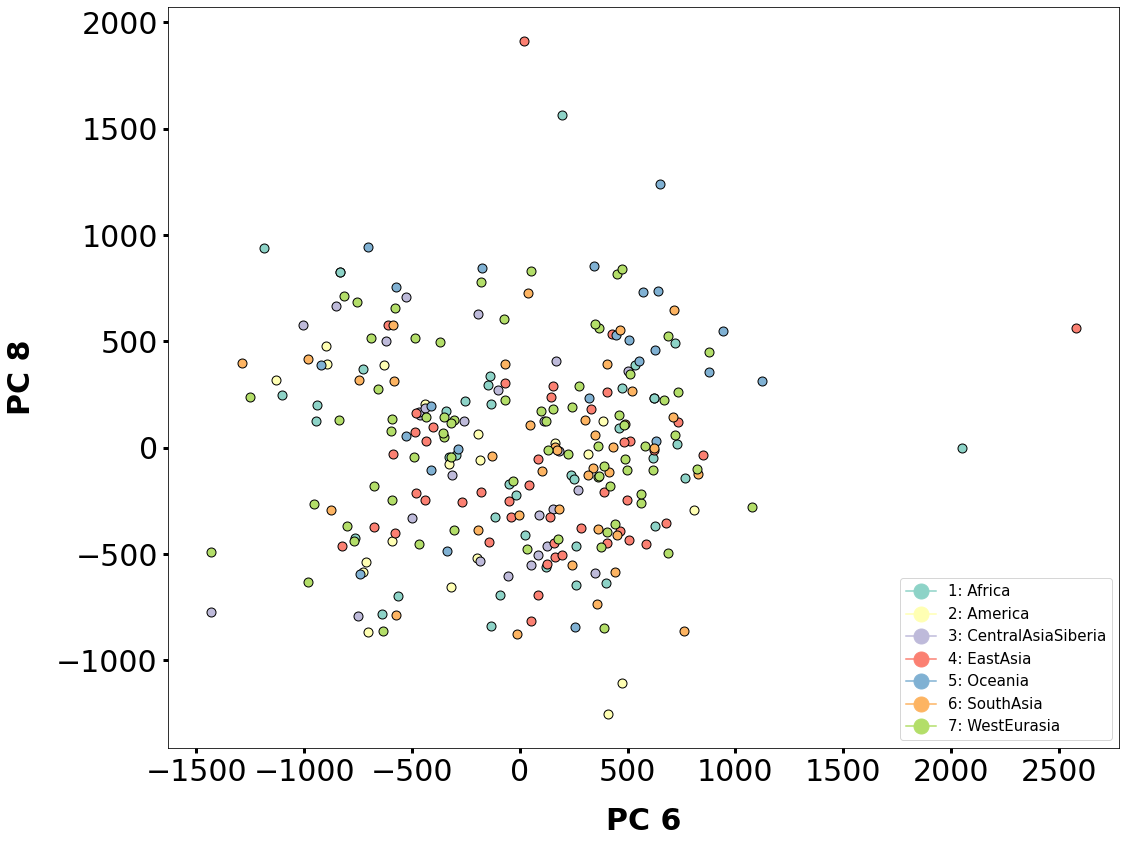

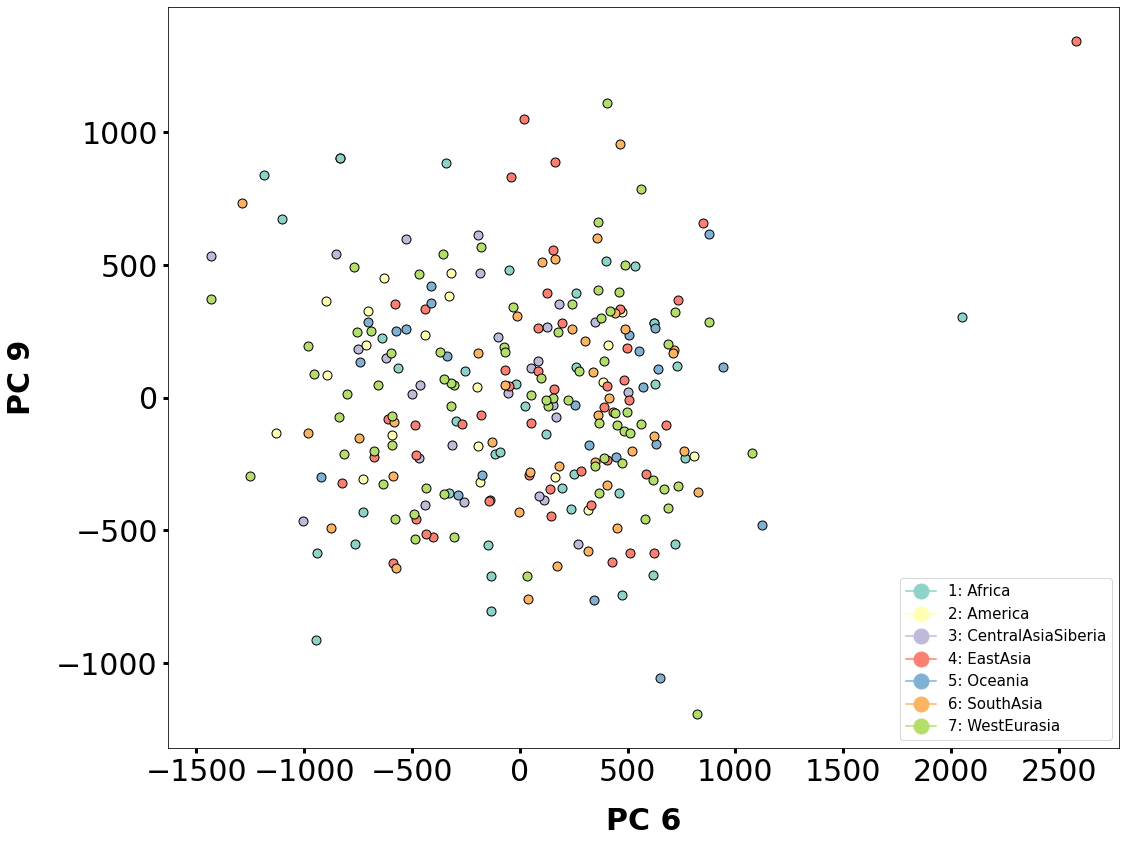

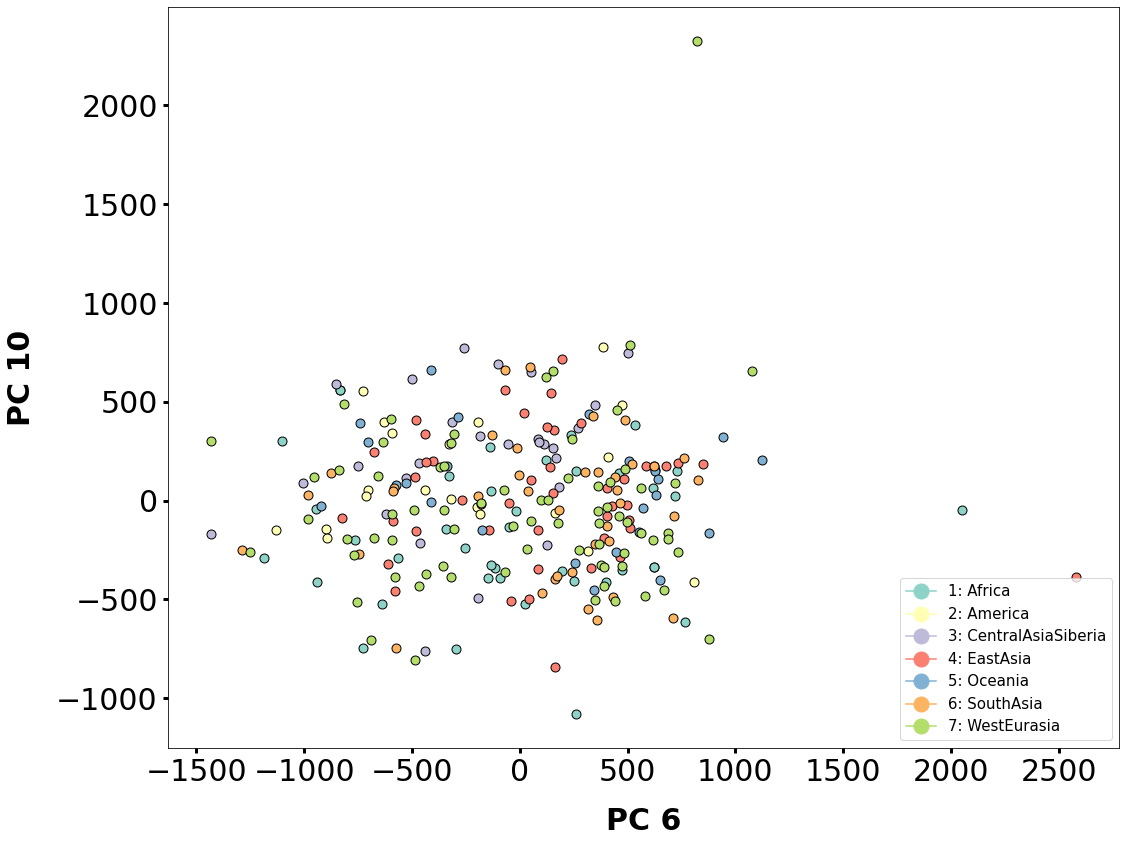

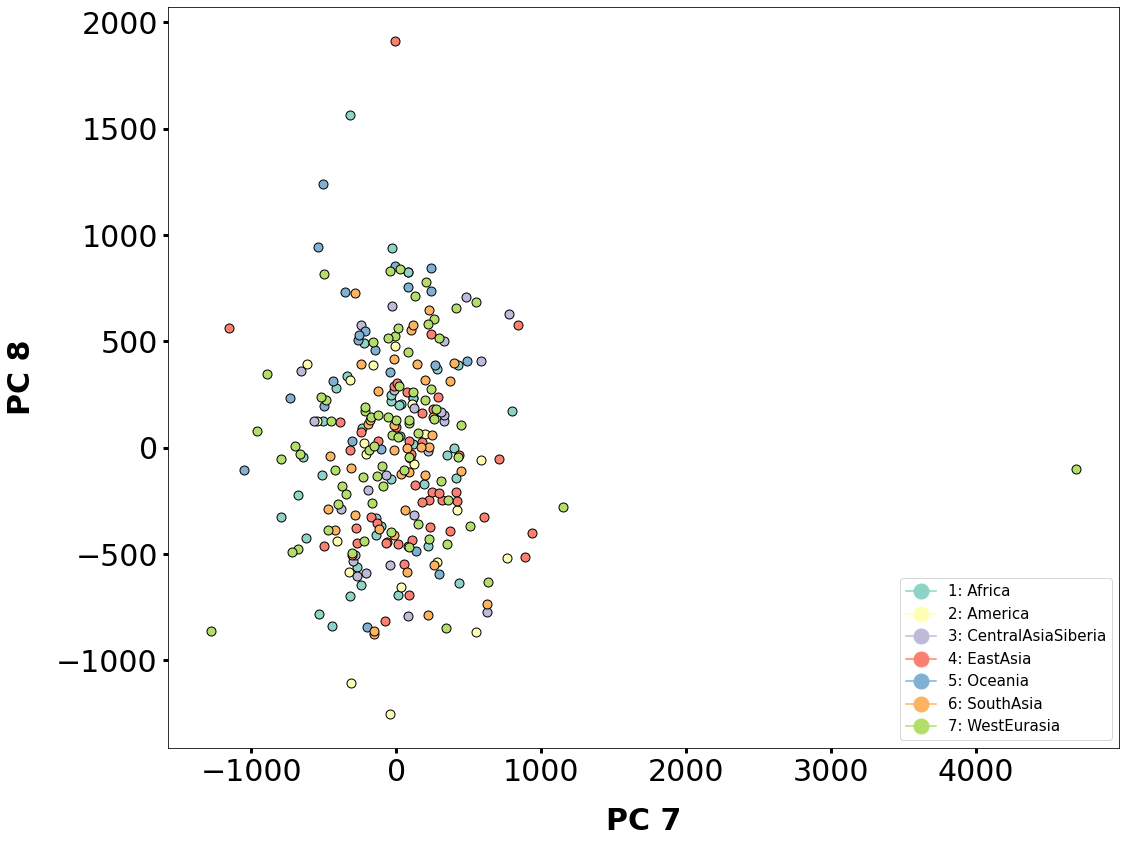

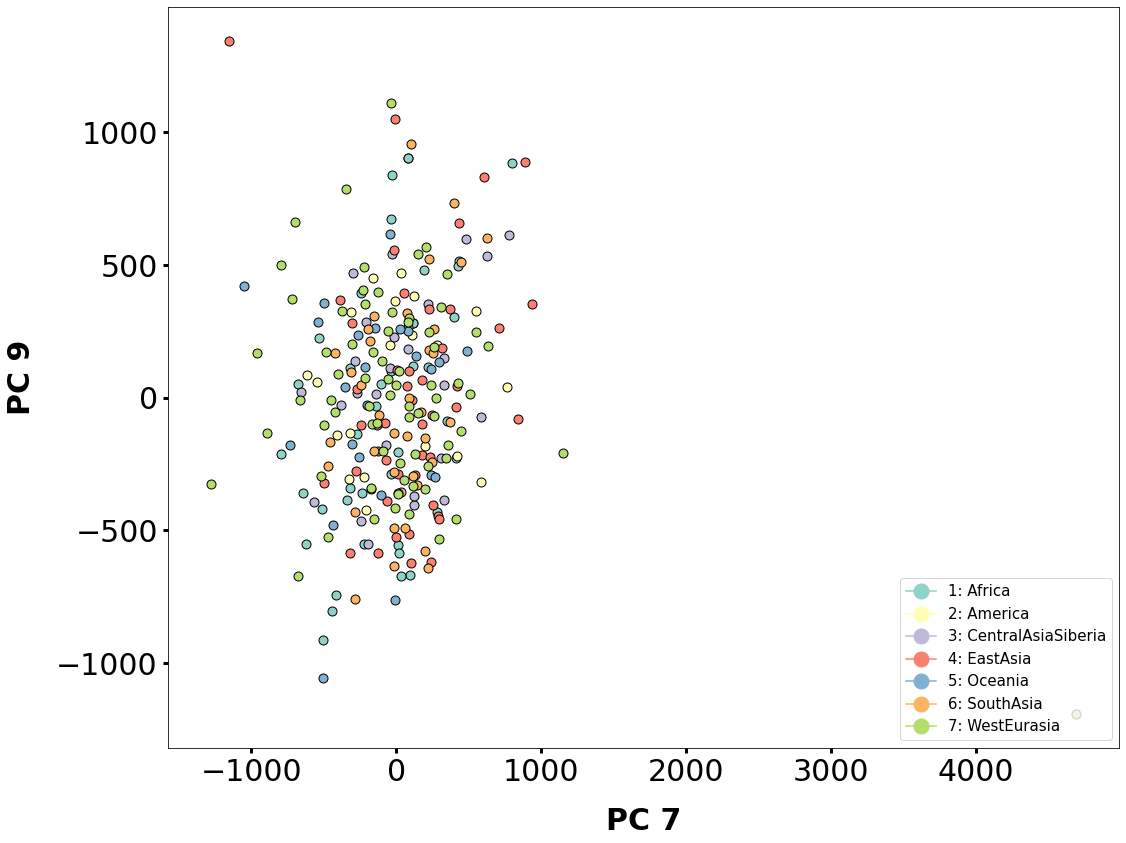

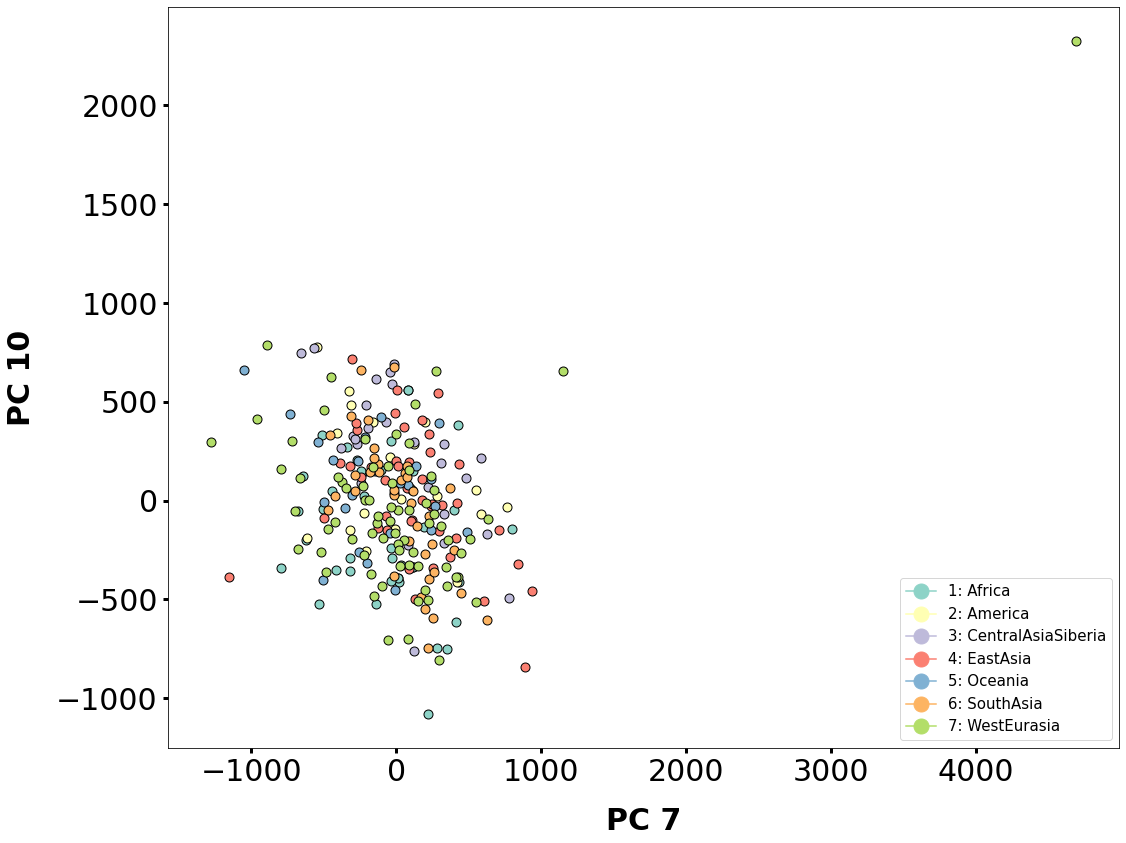

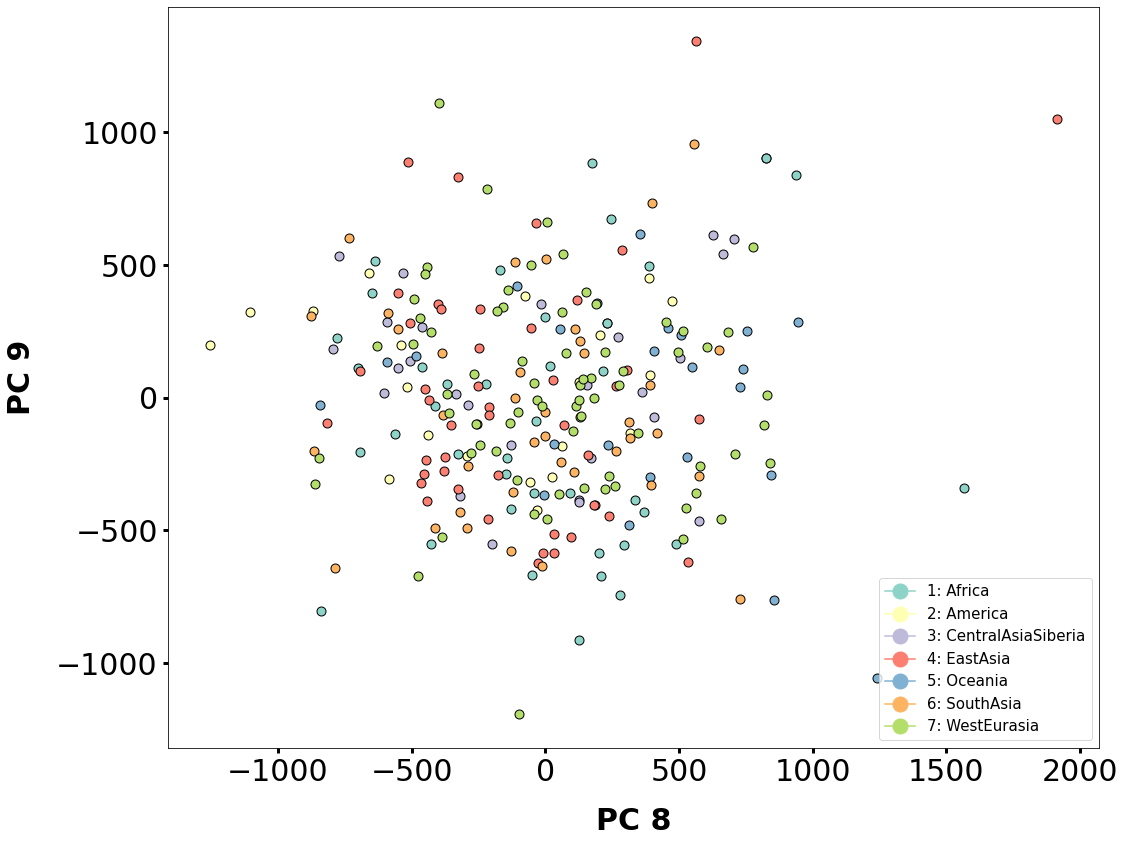

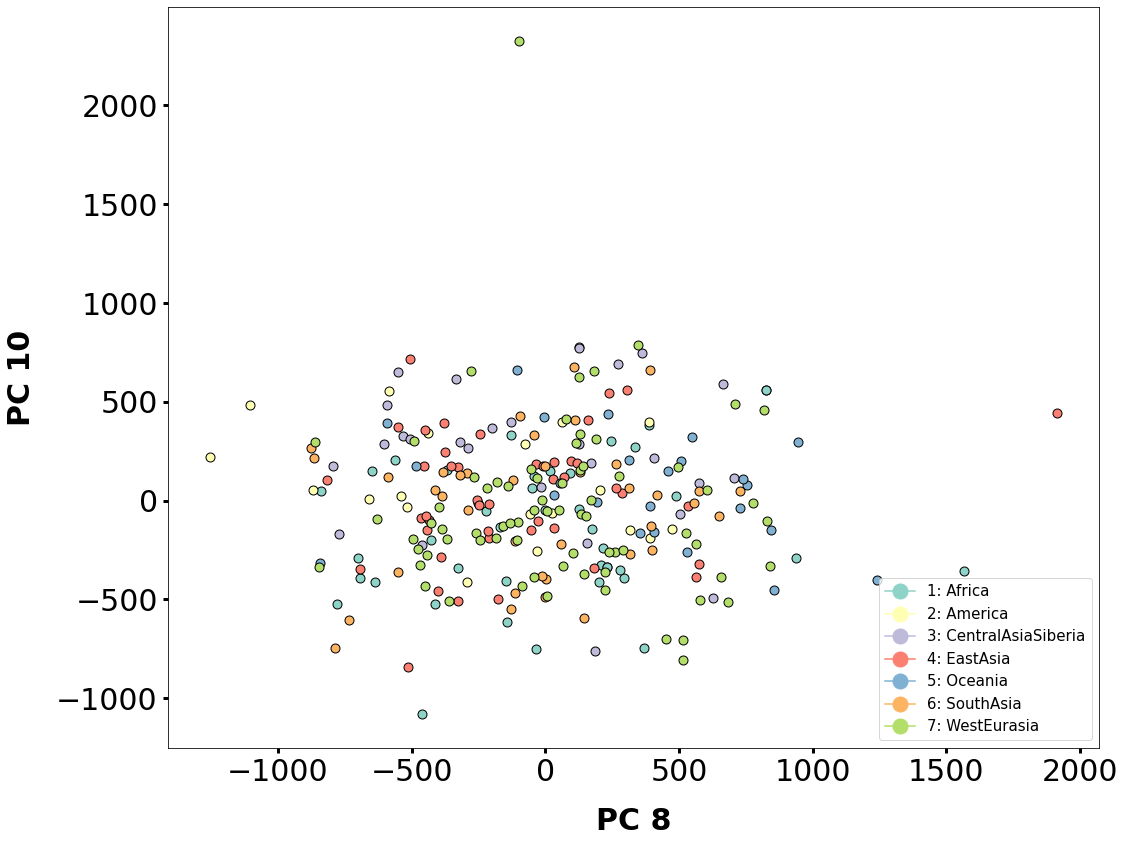

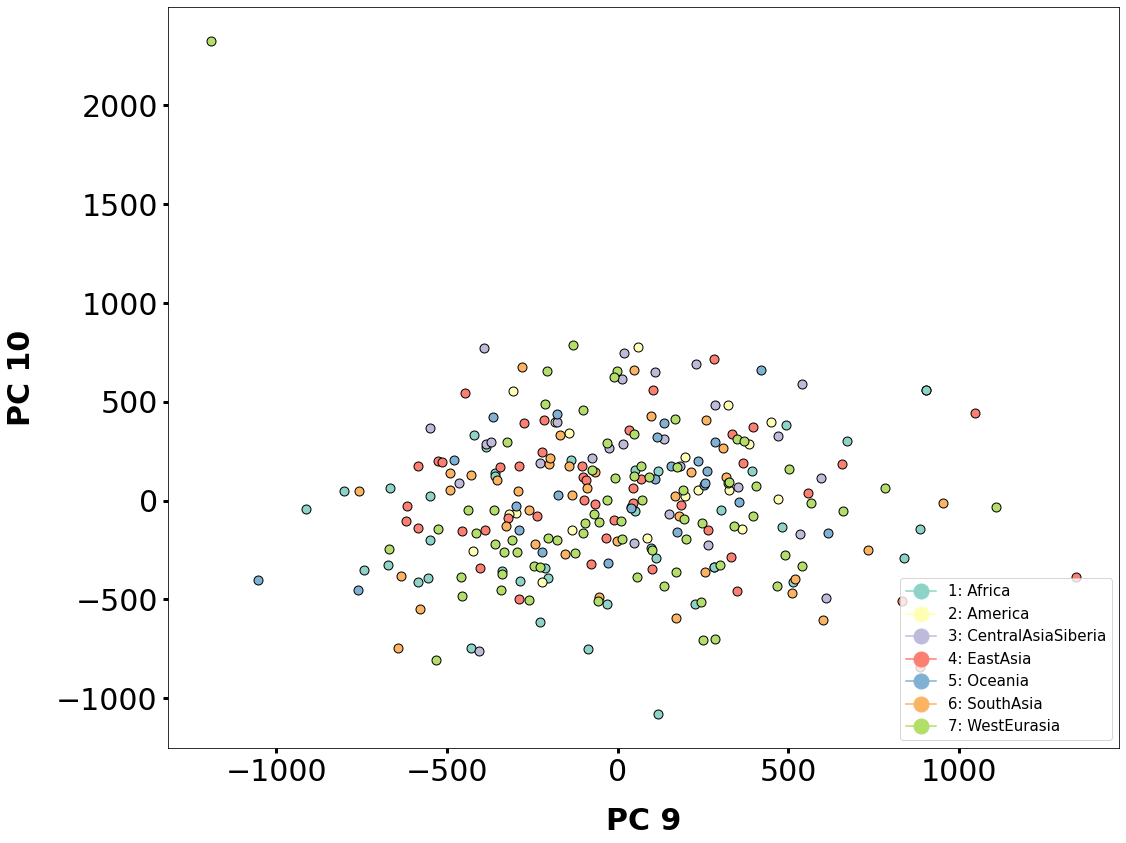

In [63]:
components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='REGION', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))